In [1]:
from google.colab import drive
import zipfile

# Google Drive mounten
drive.mount('/content/drive')

# Pfad zur ZIP-Datei
zip_path = '/content/drive/MyDrive/dataset_autoencoder.zip'

# Entpacken der ZIP-Datei
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

print("Dataset entpackt!")

Mounted at /content/drive
Dataset entpackt!


In [3]:
import os

dataset_path = '/content/dataset'
print("Dataset-Inhalt:")
for root, dirs, files in os.walk(dataset_path):
    print(root, "enthält", len(files), "Dateien.")


Dataset-Inhalt:
/content/dataset enthält 0 Dateien.
/content/dataset/train enthält 0 Dateien.
/content/dataset/train/links_abbiegen enthält 0 Dateien.
/content/dataset/train/links_abbiegen/output enthält 553 Dateien.
/content/dataset/train/links_abbiegen/input enthält 553 Dateien.
/content/dataset/train/geradeaus enthält 0 Dateien.
/content/dataset/train/geradeaus/output enthält 553 Dateien.
/content/dataset/train/geradeaus/input enthält 553 Dateien.
/content/dataset/train/rechts_abbiegen enthält 0 Dateien.
/content/dataset/train/rechts_abbiegen/output enthält 553 Dateien.
/content/dataset/train/rechts_abbiegen/input enthält 553 Dateien.
/content/dataset/train/geradeaus_rechts enthält 0 Dateien.
/content/dataset/train/geradeaus_rechts/output enthält 553 Dateien.
/content/dataset/train/geradeaus_rechts/input enthält 553 Dateien.
/content/dataset/train/zebrastreifen enthält 0 Dateien.
/content/dataset/train/zebrastreifen/output enthält 553 Dateien.
/content/dataset/train/zebrastreifen/in

In [4]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Custom Dataset-Klasse
class TrafficSignDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Basisverzeichnis des Datensatzes (z.B. '/content/dataset/train').
            transform (callable, optional): Transformationen für die Bilder.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.data = []

        # Klassen durchgehen
        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)

            # Ordner für output und input
            output_dir = os.path.join(class_dir, "output")
            input_dir = os.path.join(class_dir, "input")

            # Alle Dateien im output-Ordner
            for file_name in os.listdir(output_dir):
                if file_name.startswith("clear_") and file_name.endswith(".png"):
                    base_name = file_name.split("_")[1].split(".")[0]  # Extrahiere die Nummer

                    # Pfade für das Output-Bild und das zugehörige Input-Bild
                    output_path = os.path.join(output_dir, file_name)
                    input_path = os.path.join(input_dir, f"mask_{base_name}.png")

                    # Prüfen, ob die zugehörige Maske existiert
                    if os.path.exists(input_path):
                        self.data.append({
                            "output": output_path,
                            "input": input_path,
                            "class": class_name
                        })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Daten für den Index abrufen
        item = self.data[idx]

        # Bilder laden
        output_image = Image.open(item["output"]).convert("RGB")
        input_image = Image.open(item["input"]).convert("RGB")

        # Transformationen anwenden
        if self.transform:
            output_image = self.transform(output_image)
            input_image = self.transform(input_image)

        # Rückgabe der Bilder und der Klasse
        return {
            "output": output_image,
            "input": input_image,
            "class": item["class"]
        }

# Datenvorverarbeitung definieren
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalisierung auf [-1, 1]
])

# Dataset initialisieren
train_dataset = TrafficSignDataset(root_dir="/content/dataset/train", transform=transform)
val_dataset = TrafficSignDataset(root_dir="/content/dataset/val", transform=transform)

# DataLoader erstellen
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Dataset überprüfen
print(f"Trainingsbeispiele: {len(train_dataset)}")
print(f"Validierungsbeispiele: {len(val_dataset)}")

# Beispiel-Durchlauf durch den DataLoader
for batch in train_loader:
    print("Batch-Größe:", len(batch["output"]))
    print("Output-Shape:", batch["output"].shape)
    print("Input-Shape:", batch["input"].shape)
    print("Klassen:", batch["class"][:5])
    break


Trainingsbeispiele: 3318
Validierungsbeispiele: 582
Batch-Größe: 32
Output-Shape: torch.Size([32, 3, 64, 64])
Input-Shape: torch.Size([32, 3, 64, 64])
Klassen: ['geradeaus_rechts', 'zebrastreifen', 'geradeaus_rechts', 'geradeaus', 'zebrastreifen']


In [5]:
import torch

# Globale Variablen für Maximal- und Minimalwerte
global_max = float('-inf')
global_min = float('inf')

# Iteriere durch den DataLoader
for batch in train_loader:
    input_images = batch["input"]  # Maskiertes Bild
    target_images = batch["output"]  # Originalbild

    # Finde Maximal- und Minimalwerte für das aktuelle Batch
    batch_max_input = torch.max(input_images)
    batch_min_input = torch.min(input_images)

    batch_max_target = torch.max(target_images)
    batch_min_target = torch.min(target_images)

    # Aktualisiere globale Maximal- und Minimalwerte
    global_max = max(global_max, batch_max_input.item(), batch_max_target.item())
    global_min = min(global_min, batch_min_input.item(), batch_min_target.item())

# Ausgabe der Ergebnisse
print(f"Globaler Maximalwert im Dataset: {global_max}")
print(f"Globaler Minimalwert im Dataset: {global_min}")


Globaler Maximalwert im Dataset: 1.0
Globaler Minimalwert im Dataset: -1.0


In [6]:
import torch.nn as nn
class MaskedAutoencoder(nn.Module):
    def __init__(self):
        super(MaskedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.Tanh(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Modell initialisieren
# Gerät definieren
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Verwendetes Gerät: {device}")

# Modell initialisieren
model = MaskedAutoencoder().to(device)
print("Modell erfolgreich initialisiert und auf das Gerät geladen.")



Verwendetes Gerät: cuda
Modell erfolgreich initialisiert und auf das Gerät geladen.


In [7]:
# Optimierer, Scheduler und Loss-Funktion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Epochenanzahl
epochs = 50

for epoch in range(epochs):
    model.train()
    train_loss = 0

    print(f"\nEpoch {epoch + 1}/{epochs}")

    # Training
    for batch in train_loader:
        # Eingaben und Zielbilder
        input_images = batch["input"].to(device)  # Maskierte Eingabebilder
        target_images = batch["output"].to(device)  # Klare Zielbilder

        # Vorwärtsdurchlauf
        reconstructed_images = model(input_images)

        # Verlust berechnen
        loss = criterion(reconstructed_images, target_images)

        # Rückwärtsdurchlauf und Optimierung
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Training Loss: {avg_train_loss:.4f}")

    # Validierung
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            # Eingaben und Zielbilder
            input_images = batch["input"].to(device)  # Maskierte Eingabebilder
            target_images = batch["output"].to(device)  # Klare Zielbilder

            # Vorwärtsdurchlauf
            reconstructed_images = model(input_images)

            # Verlust berechnen
            loss = criterion(reconstructed_images, target_images)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")



Epoch 1/50
Training Loss: 0.1542
Validation Loss: 0.1266

Epoch 2/50
Training Loss: 0.1012
Validation Loss: 0.1072

Epoch 3/50
Training Loss: 0.0828
Validation Loss: 0.0982

Epoch 4/50
Training Loss: 0.0743
Validation Loss: 0.0798

Epoch 5/50
Training Loss: 0.0678
Validation Loss: 0.0749

Epoch 6/50
Training Loss: 0.0655
Validation Loss: 0.0753

Epoch 7/50
Training Loss: 0.0625
Validation Loss: 0.0706

Epoch 8/50
Training Loss: 0.0589
Validation Loss: 0.0685

Epoch 9/50
Training Loss: 0.0572
Validation Loss: 0.0698

Epoch 10/50
Training Loss: 0.0549
Validation Loss: 0.0685

Epoch 11/50
Training Loss: 0.0536
Validation Loss: 0.0702

Epoch 12/50
Training Loss: 0.0506
Validation Loss: 0.0704

Epoch 13/50
Training Loss: 0.0484
Validation Loss: 0.0696

Epoch 14/50
Training Loss: 0.0440
Validation Loss: 0.0706

Epoch 15/50
Training Loss: 0.0409
Validation Loss: 0.0742

Epoch 16/50
Training Loss: 0.0388
Validation Loss: 0.0745

Epoch 17/50
Training Loss: 0.0345
Validation Loss: 0.0766

Epoch

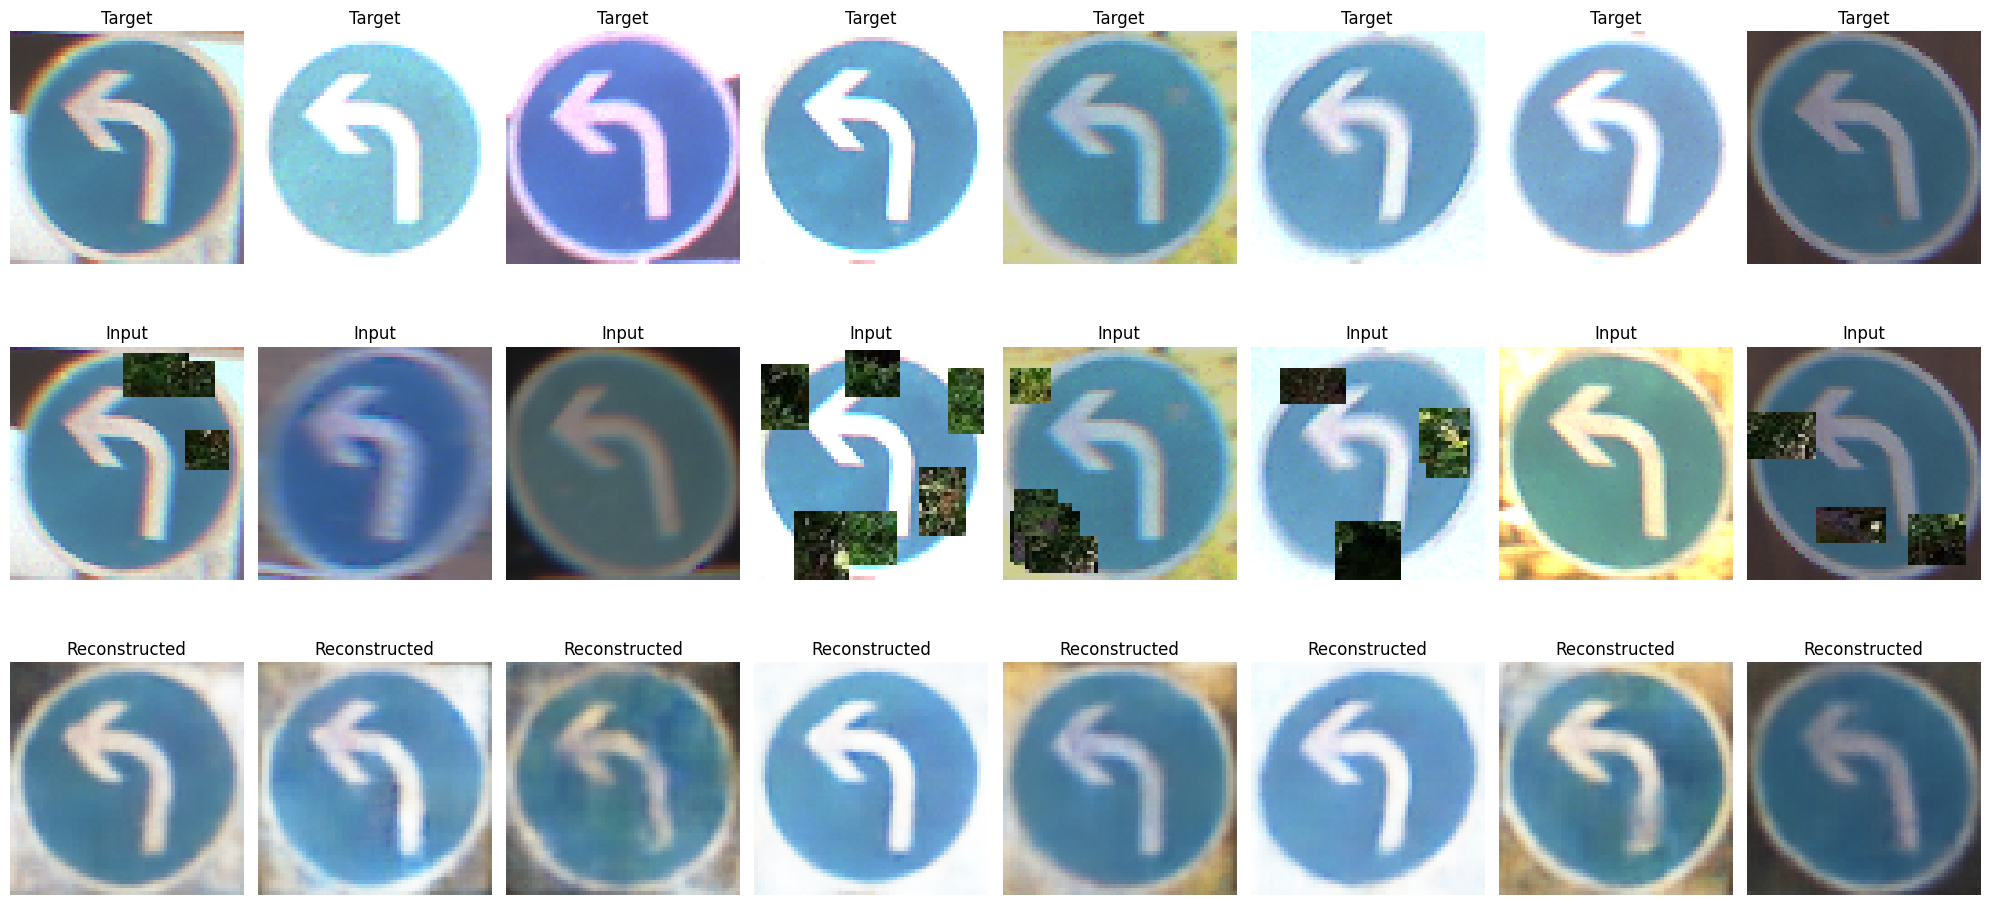

In [10]:
from PIL import Image
import matplotlib.pyplot as plt

# Modell in den Evaluierungsmodus setzen
model.eval()

# Visualisierung aus der Validierung
with torch.no_grad():
    for batch in val_loader:
        # Eingabebilder und Zielbilder auf das Gerät laden
        input_images = batch["input"].to(device)  # Maskierte Eingabebilder
        target_images = batch["output"].to(device)  # Klare Zielbilder

        # Modellvorhersagen
        reconstructed_images = model(input_images)

        # Normalisierung rückgängig machen
        target_images = (target_images.cpu().numpy() * 0.5 + 0.5).clip(0, 1)
        input_images = (input_images.cpu().numpy() * 0.5 + 0.5).clip(0, 1)
        reconstructed_images = (reconstructed_images.cpu().numpy() * 0.5 + 0.5).clip(0, 1)

        # Visualisierung der Bilder
        fig, axes = plt.subplots(3, 8, figsize=(20, 10))  # 3 Zeilen: Target, Input, Reconstructed

        for i in range(8):  # Zeige 8 Bilder
            # Zielbilder
            axes[0, i].imshow(target_images[i].transpose(1, 2, 0))
            axes[0, i].set_title("Target")
            axes[0, i].axis("off")

            # Eingabebilder (maskierte Bilder)
            axes[1, i].imshow(input_images[i].transpose(1, 2, 0))
            axes[1, i].set_title("Input")
            axes[1, i].axis("off")

            # Rekonstruierte Bilder
            axes[2, i].imshow(reconstructed_images[i].transpose(1, 2, 0))
            axes[2, i].set_title("Reconstructed")
            axes[2, i].axis("off")

        plt.tight_layout()
        plt.show()
        break  # Zeige nur den ersten Batch


In [11]:
# Modell speichern
torch.save(model.state_dict(), "autoencoder.pth")
print("Modell wurde erfolgreich gespeichert.")

Modell wurde erfolgreich gespeichert.


In [12]:
pip install onnx onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.7 MB/s eta 0:00:00


In [13]:
import torch
import torch.onnx
import onnx
import onnxruntime

# Exportiere das Modell ins ONNX-Format
def export_to_onnx(model, export_path="autoencoder.onnx"):
    # Dummy-Eingabe erstellen (Größe des Eingabebildes, z. B. Batchgröße=1, 3 Kanäle, 64x64)
    dummy_input = torch.randn(1, 3, 64, 64).to(device)  # Batchgröße=1, RGB-Kanäle, Bildgröße 64x64

    # Exportieren
    torch.onnx.export(
        model,  # Das trainierte Modell
        dummy_input,  # Dummy-Eingabe
        export_path,  # Zielpfad
        export_params=True,  # Parameter mit dem Modell exportieren
        opset_version=11,  # ONNX-Standard-OpSet (TensorRT unterstützt OpSet 11 gut)
        do_constant_folding=True,  # Konstanten falten, um das Modell zu optimieren
        input_names=["input"],  # Eingabename im ONNX-Graphen
        output_names=["output"],  # Ausgabename im ONNX-Graphen
        dynamic_axes={  # Dynamische Größen (Batchgröße variabel machen)
            "input": {0: "batch_size"},
            "output": {0: "batch_size"}
        }
    )
    print(f"Modell erfolgreich als ONNX exportiert: {export_path}")

# Teste das exportierte ONNX-Modell



In [14]:
# Exportiere das trainierte Modell
model.eval()  # Modell in Evaluierungsmodus setzen
export_to_onnx(model, export_path="autoencoder.onnx")

Modell erfolgreich als ONNX exportiert: autoencoder.onnx


In [15]:
import onnx
import onnxruntime as ort
import numpy as np

# ONNX-Modell laden
onnx_model = "autoencoder.onnx"
onnx.checker.check_model(onnx_model)  # Überprüft die Korrektheit
print("ONNX-Modell erfolgreich geladen und überprüft.")

# ONNX Runtime-Sitzung erstellen
ort_session = ort.InferenceSession(onnx_model)

# Dummy-Eingabe (z. B. ein Testbild mit der gleichen Form wie die Trainingsbilder)
dummy_input = np.random.randn(1, 3, 64, 64).astype(np.float32)

# Vorhersage mit ONNX Runtime
outputs = ort_session.run(
    None,  # Alle Ausgaben
    {"input": dummy_input}  # Eingaben mit Namen
)

print(f"ONNX-Vorhersage erfolgreich. Ausgabeform: {outputs[0].shape}")


ONNX-Modell erfolgreich geladen und überprüft.
ONNX-Vorhersage erfolgreich. Ausgabeform: (1, 3, 64, 64)


In [19]:
import zipfile
import os

# Pfad zur ZIP-Datei
zip_path = "/content/test1.zip"

# Zielverzeichnis, in das die Dateien extrahiert werden sollen
extract_path = "/content/extracted1"

# ZIP-Datei entpacken
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dateien wurden erfolgreich nach {extract_path} extrahiert.")

Dateien wurden erfolgreich nach /content/extracted1 extrahiert.


ONNX-Modell erfolgreich geladen.
Vergleich für Bild: 3


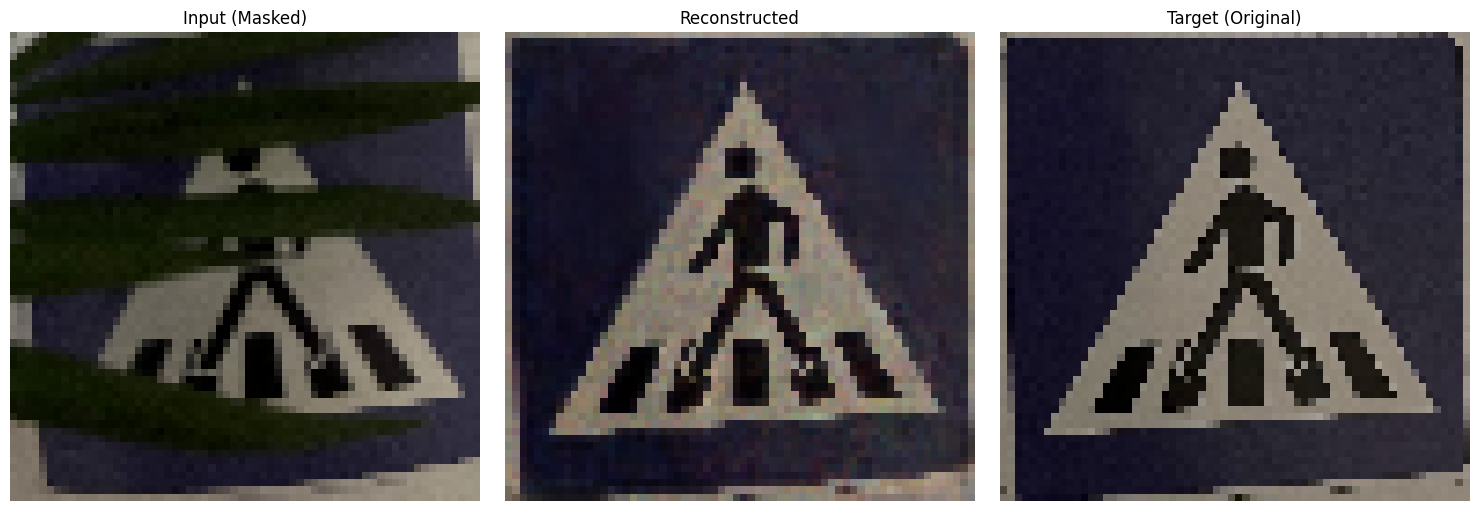

Vergleich für Bild: 10


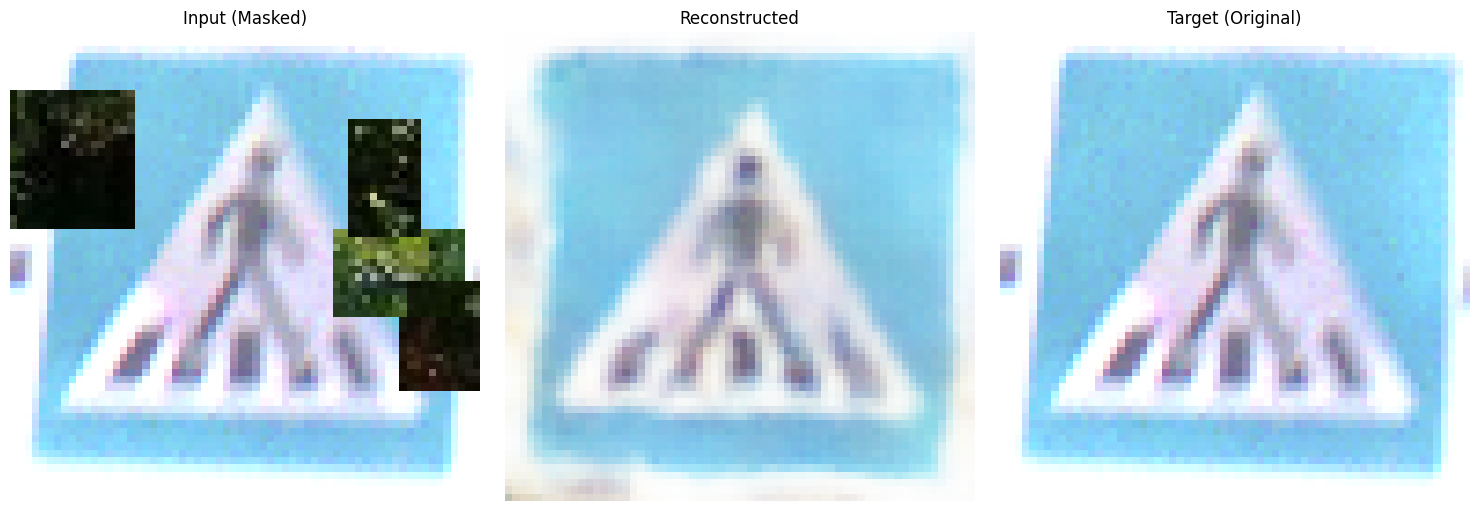

Vergleich für Bild: 12


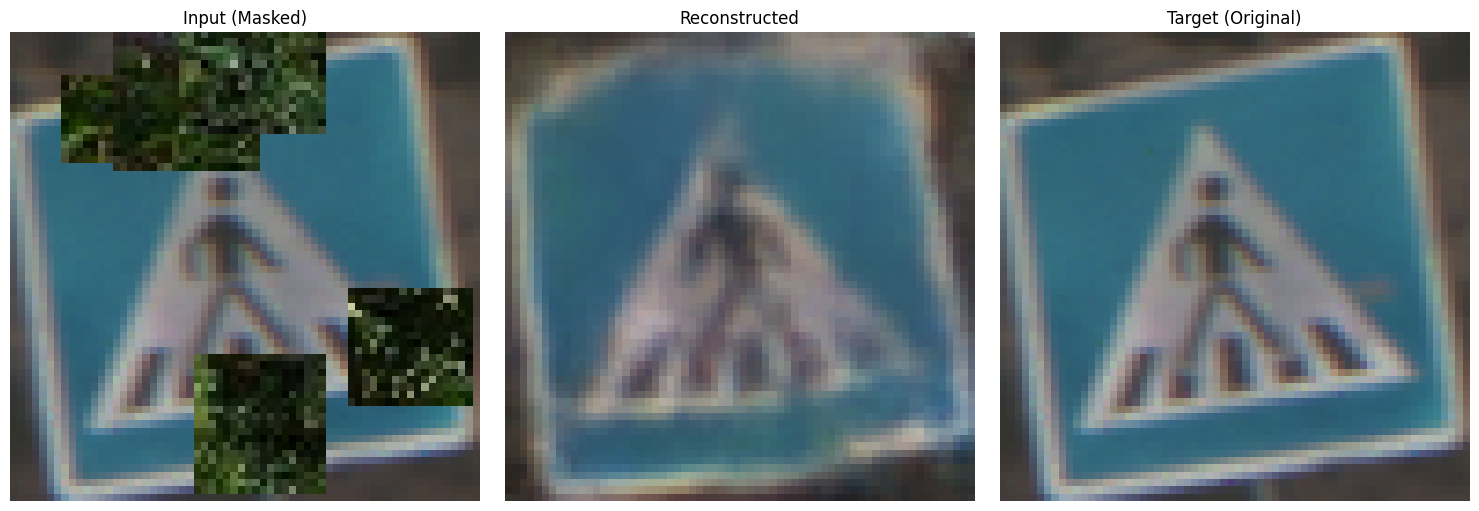

Vergleich für Bild: 5


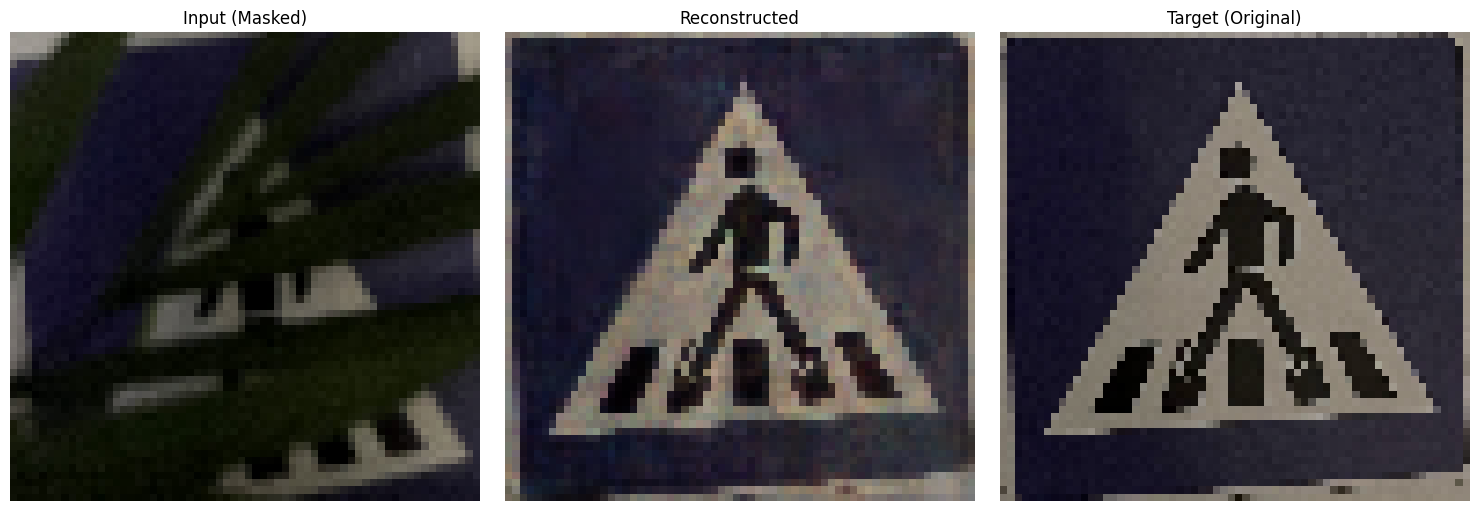

Vergleich für Bild: 14


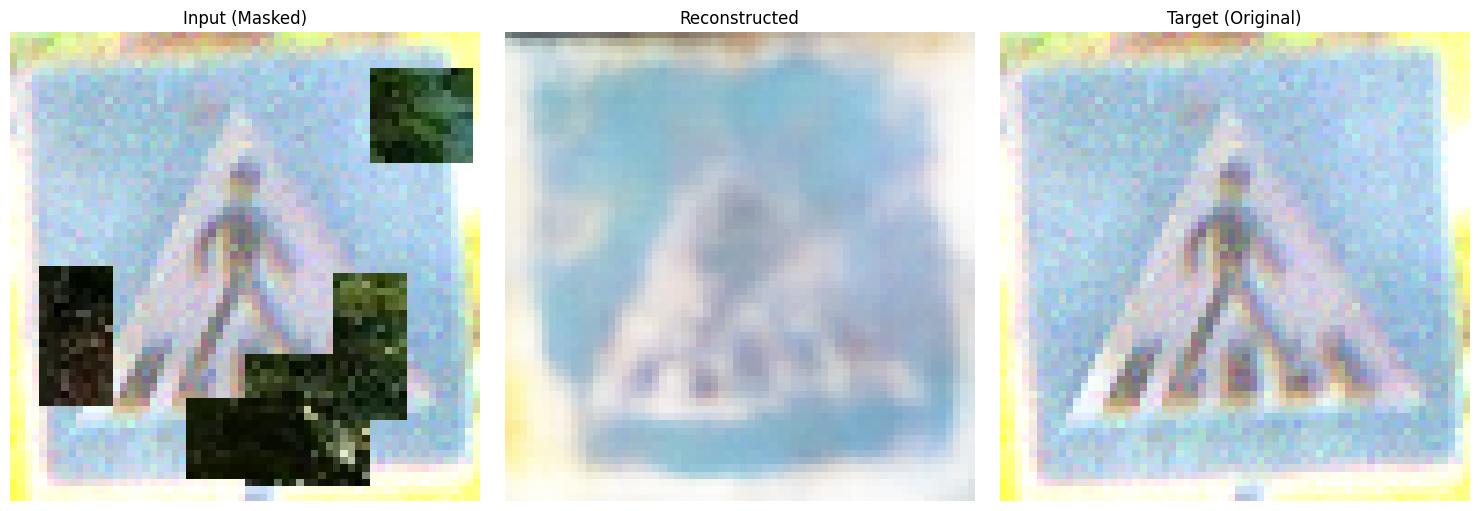

Vergleich für Bild: 19


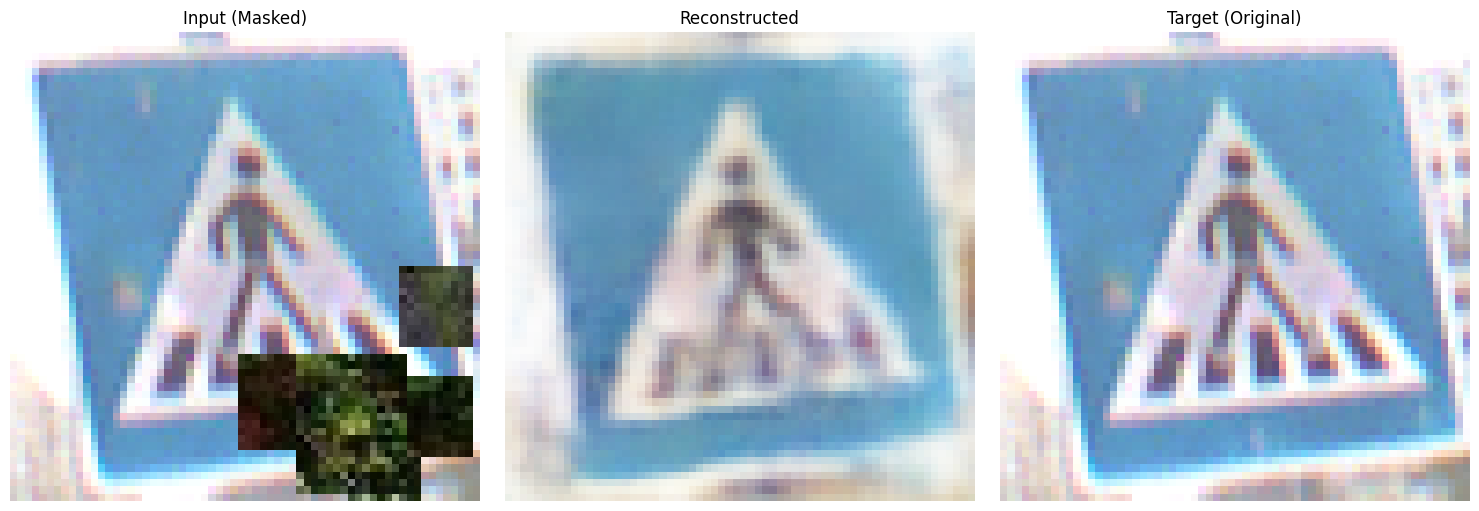

Vergleich für Bild: 18


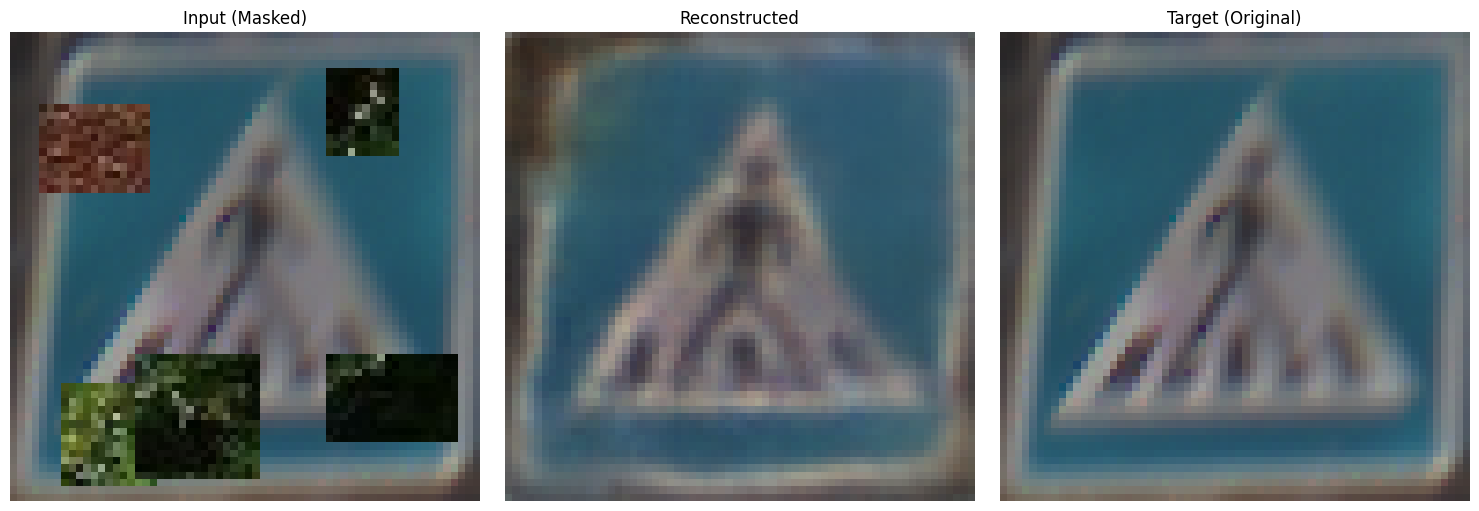

Vergleich für Bild: 15


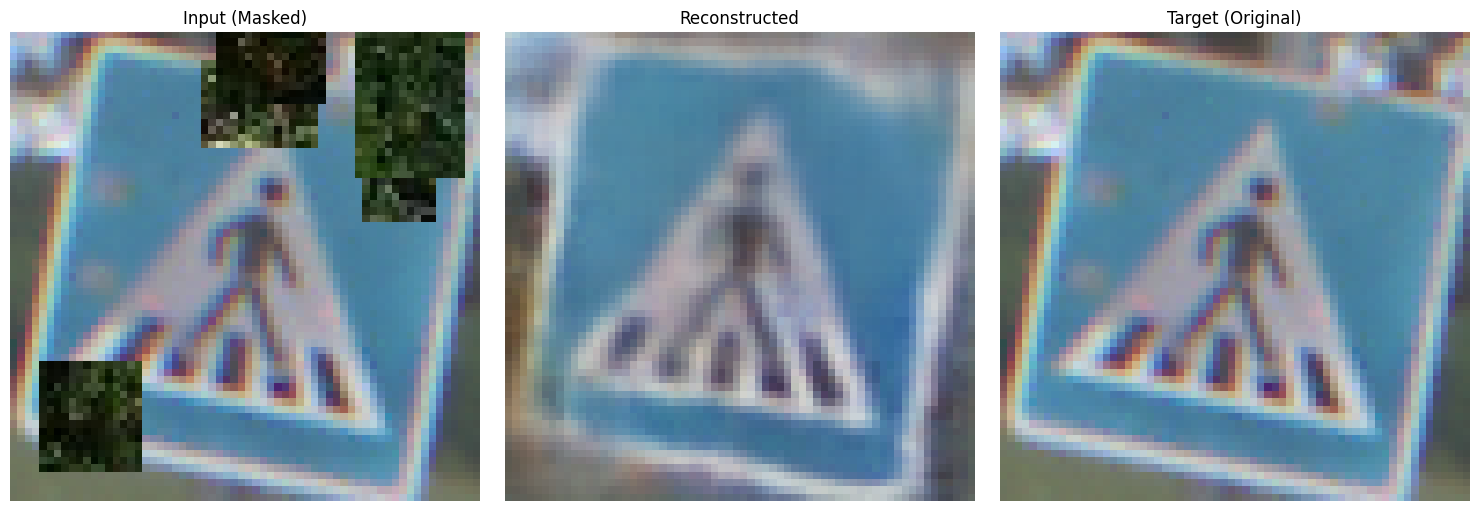

Vergleich für Bild: 8


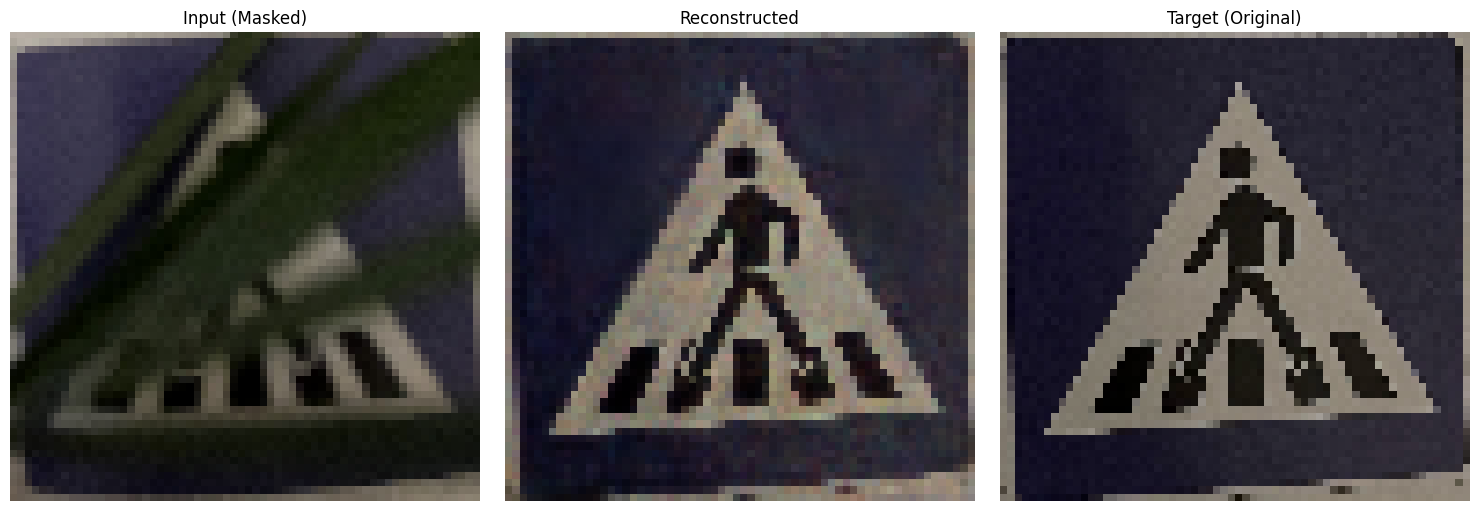

Vergleich für Bild: 11


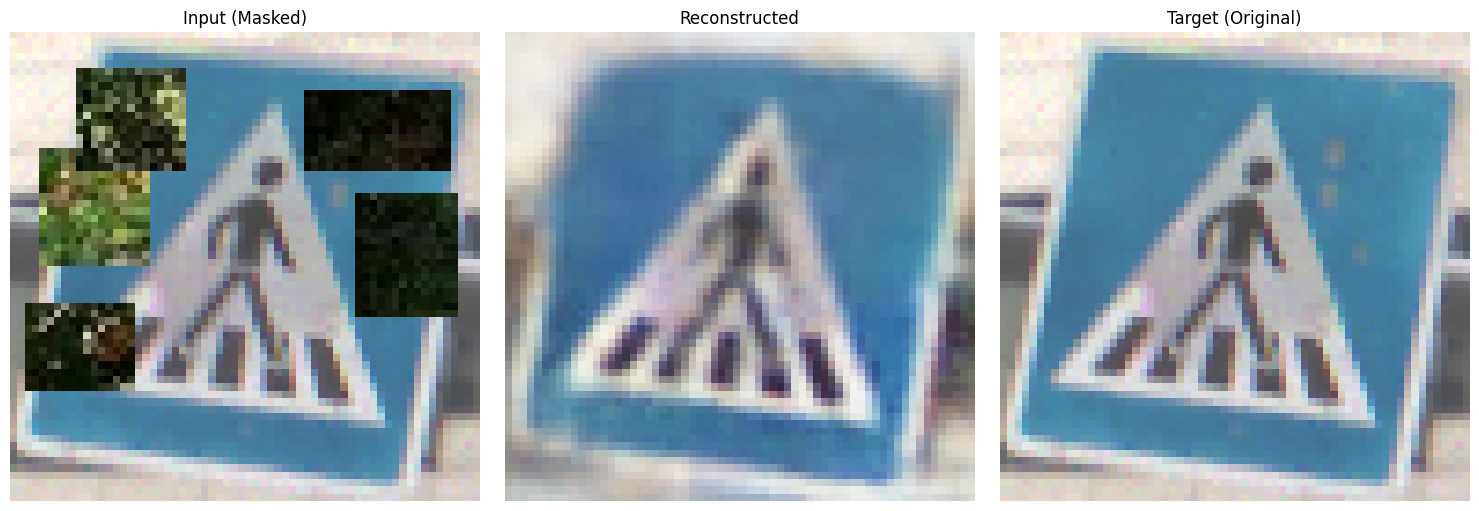

Vergleich für Bild: 16


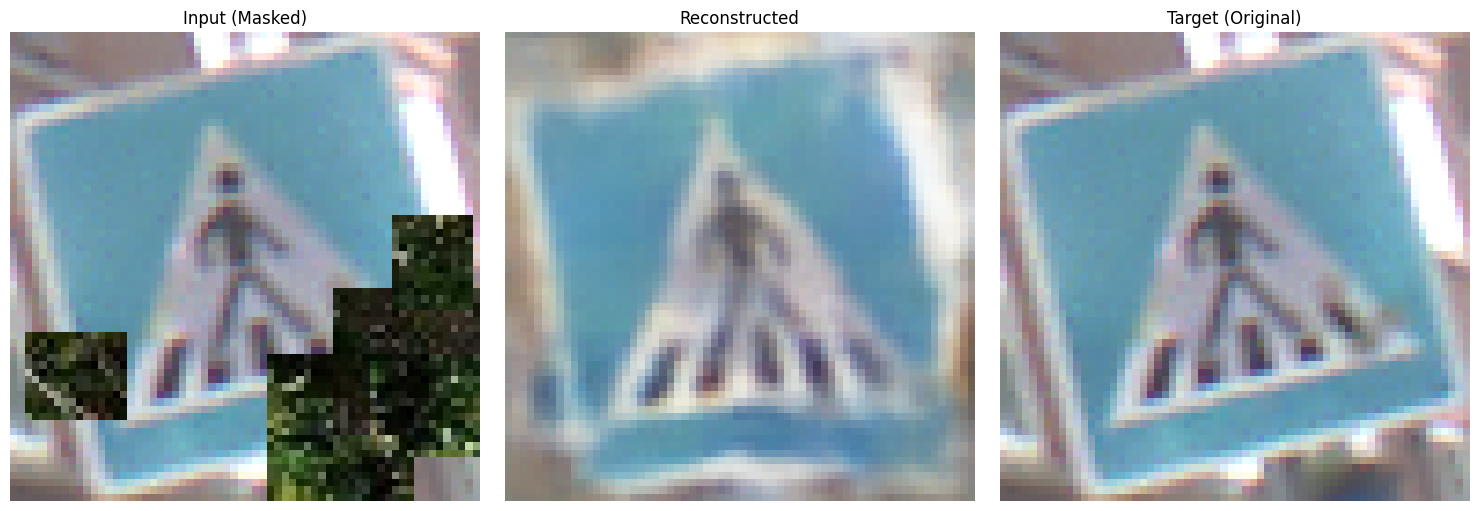

Vergleich für Bild: 4


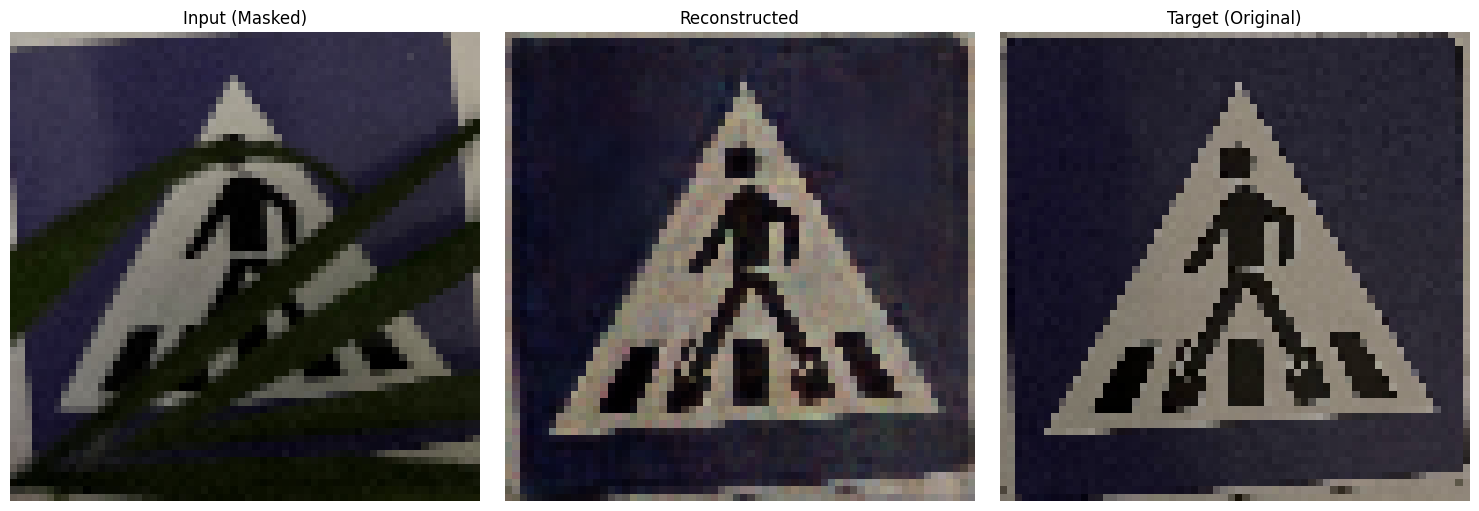

Vergleich für Bild: 1


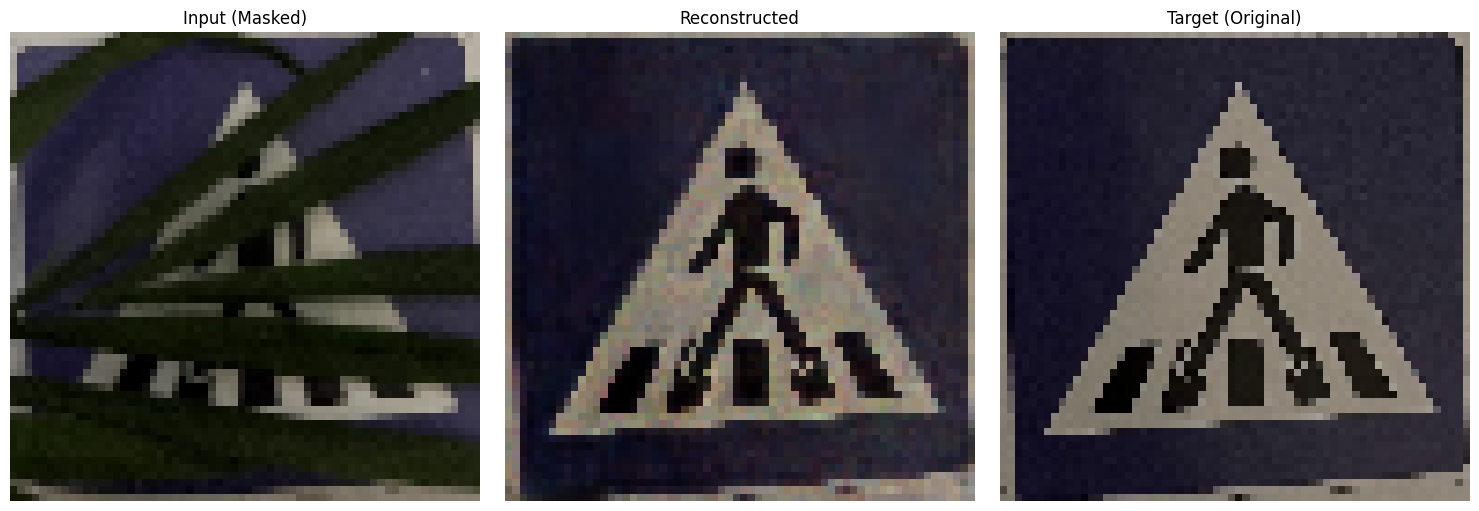

Vergleich für Bild: 17


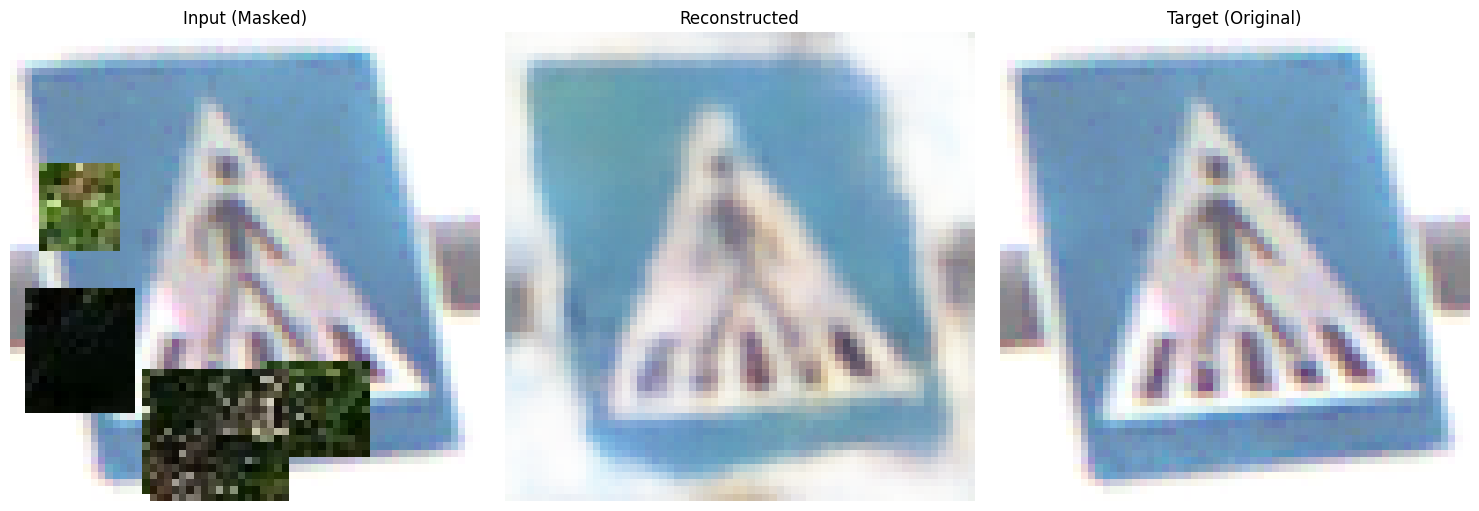

Vergleich für Bild: 6


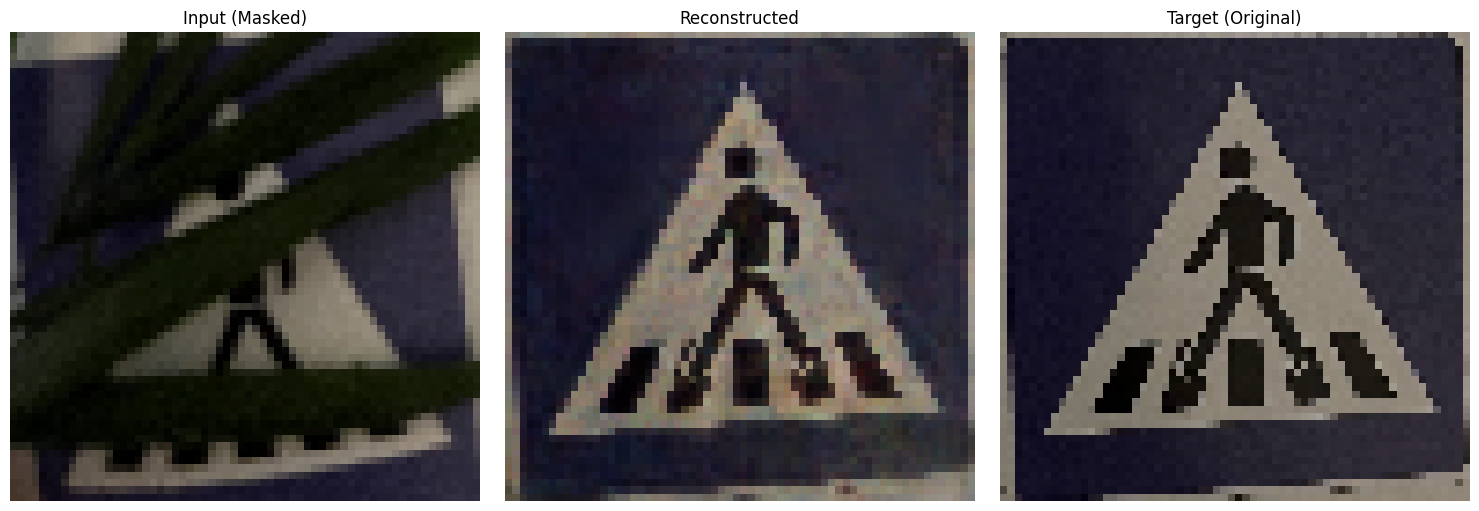

Vergleich für Bild: 13


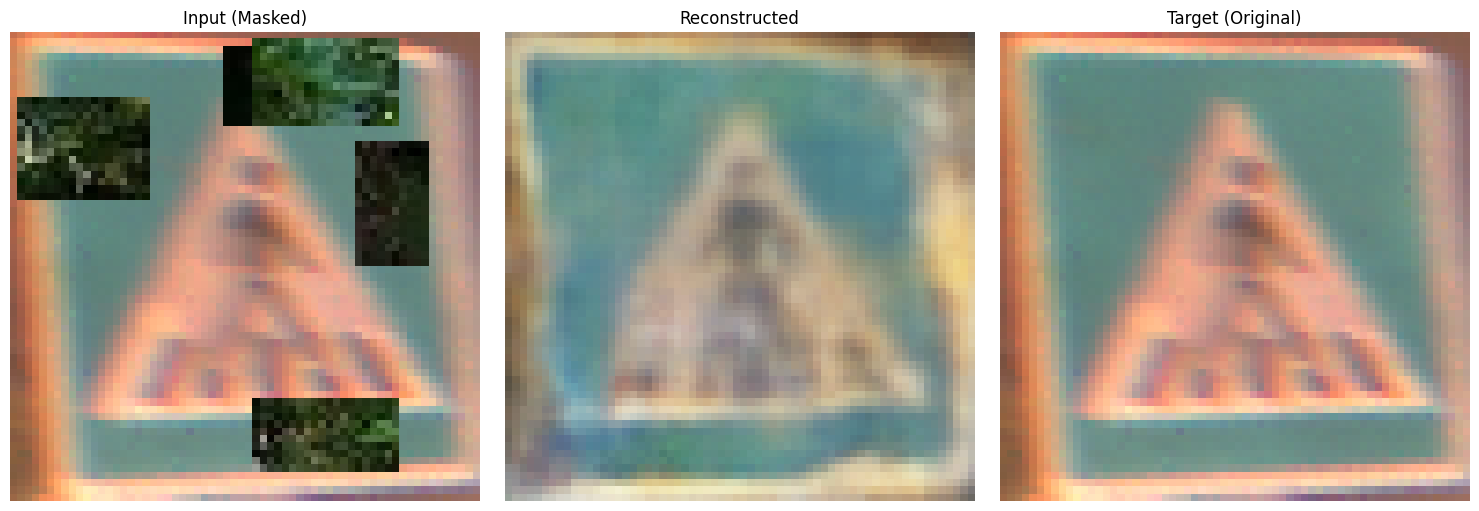

Vergleich für Bild: 7


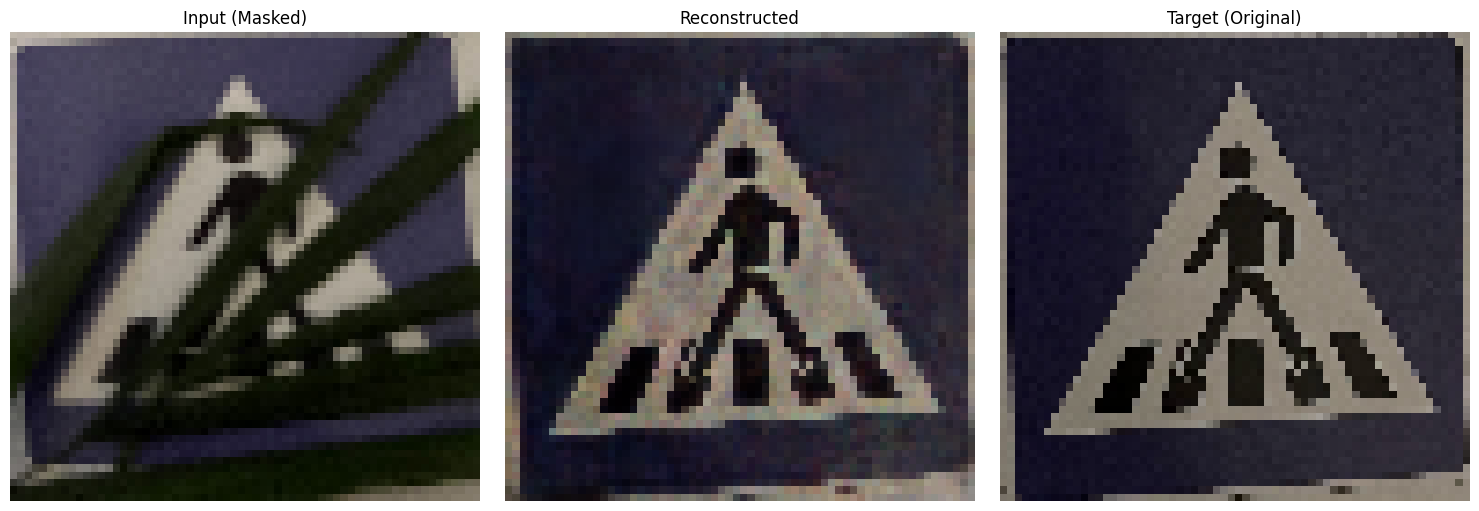

Vergleich für Bild: 2


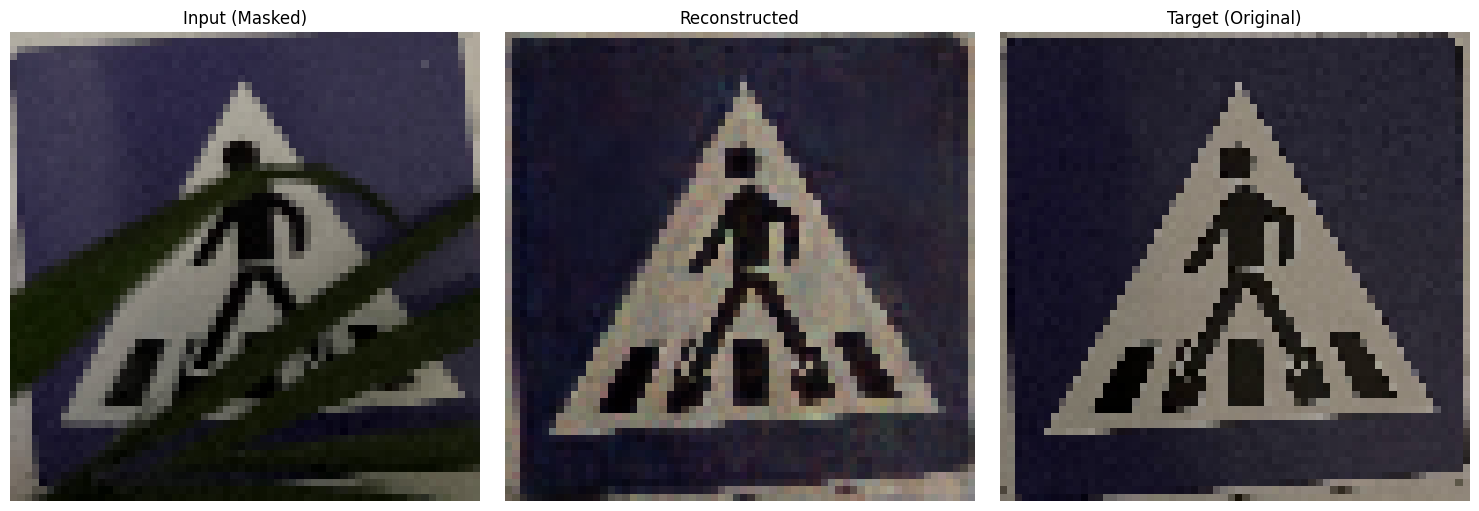

Vergleich für Bild: 9


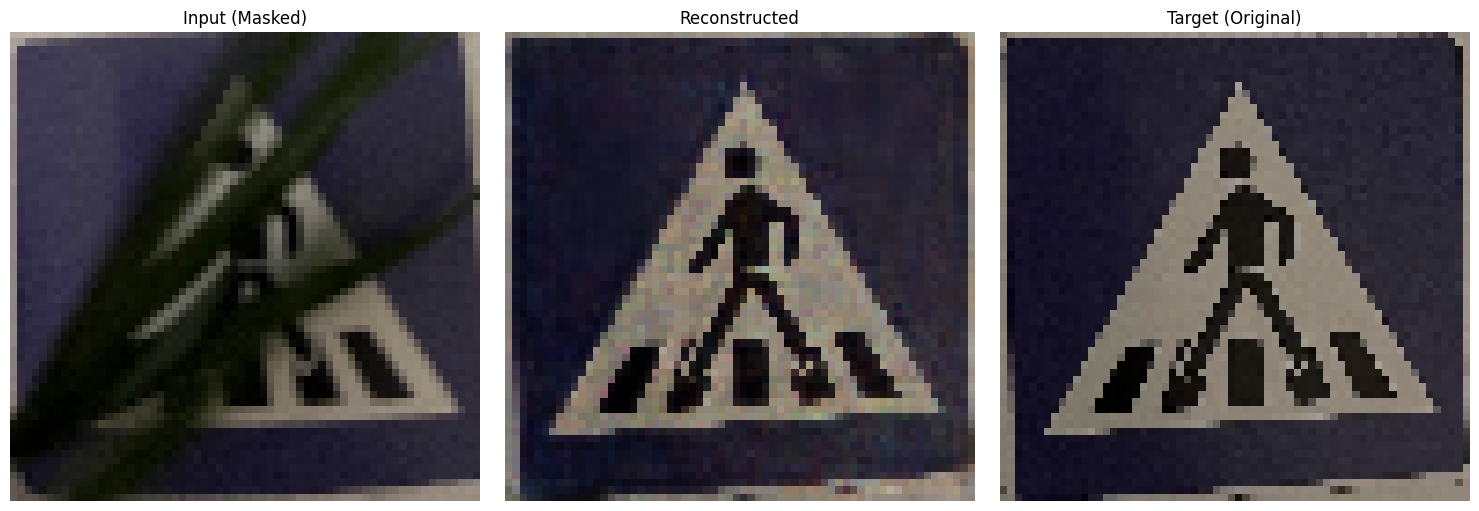

In [20]:
import os
import numpy as np
import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# ONNX-Modellpfad
onnx_model_path = "/content/autoencoder.onnx"

# Testbilder Verzeichnisse
input_dir = "/content/extracted1/input"
output_dir = "/content/extracted1/output"

# Bildvorverarbeitung
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalisierung auf [-1, 1]
])

# Rücknormalisierung für Visualisierung
def denormalize(image_tensor):
    return (image_tensor * 0.5 + 0.5).clip(0, 1)  # Rückumwandlung in den Bereich [0, 1]

# ONNX-Modell laden und Inferenz-Session erstellen
onnx_session = ort.InferenceSession(onnx_model_path)
print("ONNX-Modell erfolgreich geladen.")

# Funktion, um ein Bild zu laden und vorzubereiten
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0).numpy()  # Bild vorverarbeiten und Batch-Dimension hinzufügen

# Funktion, um die Ausgaben zu vergleichen
def compare_images(input_path, output_path):
    # Bilder laden
    input_image = load_and_preprocess_image(input_path)
    target_image = Image.open(output_path).convert("RGB")

    # ONNX-Inferenz
    reconstructed_image = onnx_session.run(None, {"input": input_image})[0]

    # Rücknormalisierung
    reconstructed_image = denormalize(reconstructed_image[0]).transpose(1, 2, 0)  # Channel-last
    target_image = np.array(target_image) / 255.0  # Zielbild in den Bereich [0, 1] skalieren
    input_image = denormalize(input_image[0]).transpose(1, 2, 0)  # Eingabebild normalisieren

    # Bilder anzeigen
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(input_image)
    axes[0].set_title("Input (Masked)")
    axes[0].axis("off")

    axes[1].imshow(reconstructed_image)
    axes[1].set_title("Reconstructed")
    axes[1].axis("off")

    axes[2].imshow(target_image)
    axes[2].set_title("Target (Original)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Alle Testbilder vergleichen
for file_name in os.listdir(input_dir):
    if file_name.endswith(".png"):  # Nur PNG-Bilder verarbeiten
        # Basisnamen extrahieren (z. B. mask_0)
        base_name = file_name.replace("mask_", "").replace(".png", "")

        # Pfade zu den Bildern
        input_path = os.path.join(input_dir, file_name)
        output_path = os.path.join(output_dir, f"clear_{base_name}.png")

        # Sicherstellen, dass beide Bilder existieren
        if os.path.exists(input_path) and os.path.exists(output_path):
            print(f"Vergleich für Bild: {base_name}")
            compare_images(input_path, output_path)
        else:
            print(f"Fehlende Dateien für: {base_name}")


In [27]:
import os
import torch
import torch.nn as nn

# Definition des MaskedAutoencoder-Modells
class MaskedAutoencoder(nn.Module):
    def __init__(self):
        super(MaskedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.Tanh(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Gerät auswählen (GPU oder CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Verwendetes Gerät: {device}")

# Modell laden
model_path = "/content/autoencoder.pth"  # Ersetze durch den Pfad zu deinem .pth-Modell
model = MaskedAutoencoder()
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
print("Modell erfolgreich geladen und auf das Gerät verschoben.")


Verwendetes Gerät: cuda
Modell erfolgreich geladen und auf das Gerät verschoben.


<ipython-input-27-d6d7c9aab7af>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [28]:
# Root-Verzeichnis des Trainingsdatensatzes
train_root = "/content/dataset/train"  # Passe den Pfad an

# Überprüfe die Struktur
for class_name in os.listdir(train_root):
    class_dir = os.path.join(train_root, class_name)
    input_dir = os.path.join(class_dir, "input")
    output_file = os.path.join(class_dir, "output", "clear_image.png")

    print(f"Klasse: {class_name}")
    print(f"  Input-Bilder: {len(os.listdir(input_dir))} gefunden")
    print(f"  Zielbild vorhanden: {os.path.exists(output_file)}")


Klasse: links_abbiegen
  Input-Bilder: 553 gefunden
  Zielbild vorhanden: True
Klasse: geradeaus
  Input-Bilder: 553 gefunden
  Zielbild vorhanden: True
Klasse: rechts_abbiegen
  Input-Bilder: 553 gefunden
  Zielbild vorhanden: True
Klasse: geradeaus_rechts
  Input-Bilder: 553 gefunden
  Zielbild vorhanden: True
Klasse: zebrastreifen
  Input-Bilder: 553 gefunden
  Zielbild vorhanden: True
Klasse: geradeaus_links
  Input-Bilder: 553 gefunden
  Zielbild vorhanden: True


In [29]:
from PIL import Image
from torch.utils.data import Dataset

class FineTuningDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = []
        self.transform = transform

        # Iteriere durch die Klassen
        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            input_dir = os.path.join(class_dir, "input")
            target_path = os.path.join(class_dir, "output", "clear_image.png")

            if not os.path.exists(target_path):
                print(f"Kein Zielbild für Klasse: {class_name}")
                continue

            input_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(".png")]

            for input_file in input_files:
                self.data.append({"input": input_file, "target": target_path, "class": class_name})

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        input_image = Image.open(item["input"]).convert("RGB")
        target_image = Image.open(item["target"]).convert("RGB")

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image


In [30]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

# Transformationen
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Dataset und DataLoader
train_dataset = FineTuningDataset(train_root, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"Anzahl der Trainingsbeispiele: {len(train_dataset)}")


Anzahl der Trainingsbeispiele: 3318


In [31]:
# Loss-Funktion und Optimierer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Feintraining
epochs = 10
model.train()

for epoch in range(epochs):
    train_loss = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Vorwärtsdurchlauf
        outputs = model(inputs)

        # Verlust berechnen
        loss = criterion(outputs, targets)

        # Rückwärtsdurchlauf und Optimierung
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 0.1226
Epoch [2/10], Loss: 0.0282
Epoch [3/10], Loss: 0.0181
Epoch [4/10], Loss: 0.0136
Epoch [5/10], Loss: 0.0111
Epoch [6/10], Loss: 0.0094
Epoch [7/10], Loss: 0.0080
Epoch [8/10], Loss: 0.0068
Epoch [9/10], Loss: 0.0060
Epoch [10/10], Loss: 0.0054


In [32]:
torch.save(model.state_dict(), "finetuned_model.pth")
print("Feintrainiertes Modell erfolgreich gespeichert.")


Feintrainiertes Modell erfolgreich gespeichert.


In [33]:
import torch.onnx

# Dummy-Eingabe für das ONNX-Export
dummy_input = torch.randn(1, 3, 64, 64).to(device)

# Modell exportieren
onnx_export_path = "finetuned_autoencoder.onnx"
torch.onnx.export(
    model,
    dummy_input,
    onnx_export_path,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
)
print(f"Modell erfolgreich als ONNX exportiert: {onnx_export_path}")


Modell erfolgreich als ONNX exportiert: finetuned_autoencoder.onnx


In [34]:
import onnx
import onnxruntime as ort

# ONNX-Modell laden
onnx_model = onnx.load(onnx_export_path)
onnx.checker.check_model(onnx_model)
print("ONNX-Modell erfolgreich validiert.")

# ONNX-Inferenz testen
session = ort.InferenceSession(onnx_export_path)
dummy_input = torch.randn(1, 3, 64, 64).numpy()
outputs = session.run(None, {"input": dummy_input})
print(f"Inferenz erfolgreich. Ausgabeshape: {outputs[0].shape}")


ONNX-Modell erfolgreich validiert.
Inferenz erfolgreich. Ausgabeshape: (1, 3, 64, 64)


Beide ONNX-Modelle erfolgreich geladen.
Verarbeite Bild: mask_3.png


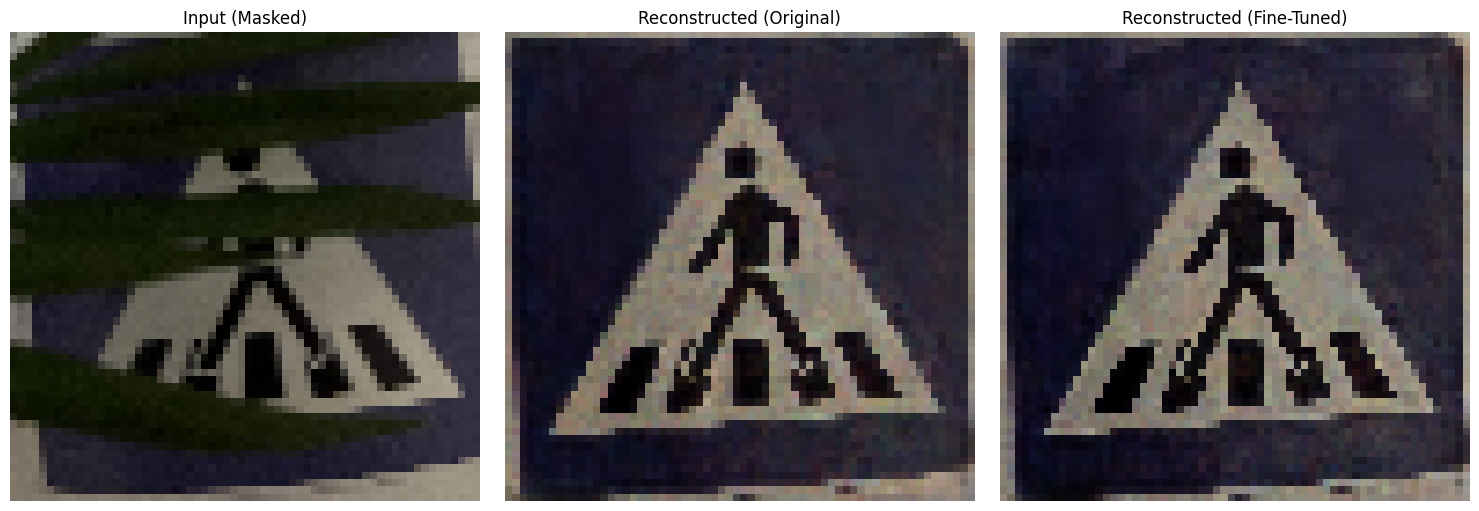

Verarbeite Bild: mask_10.png


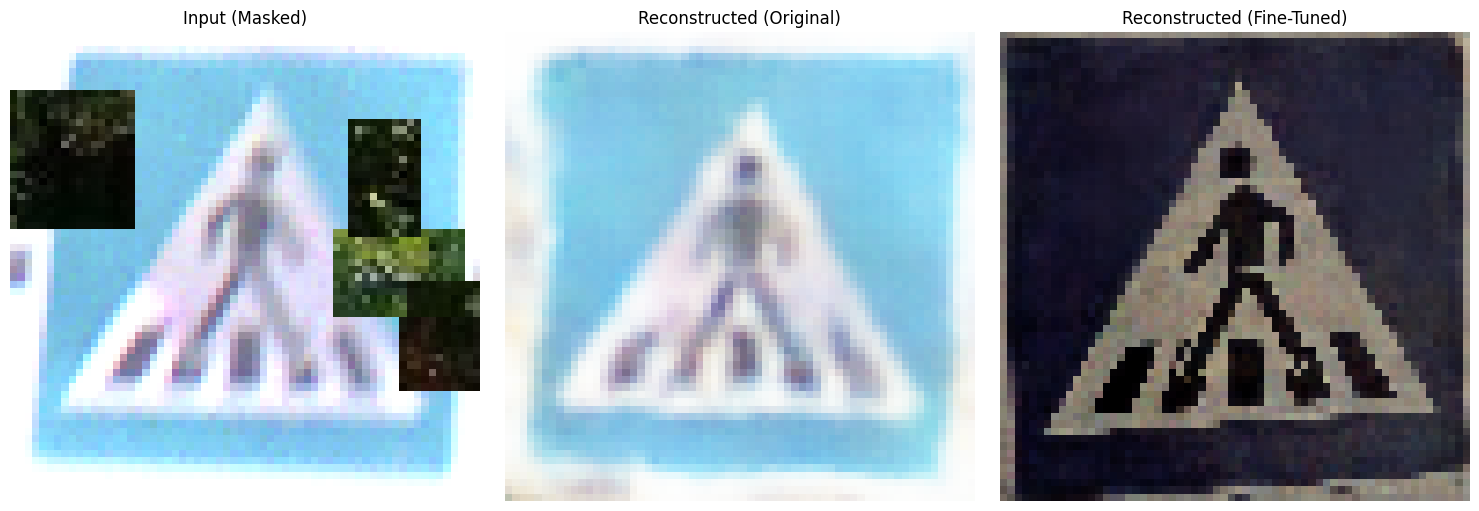

Verarbeite Bild: mask_12.png


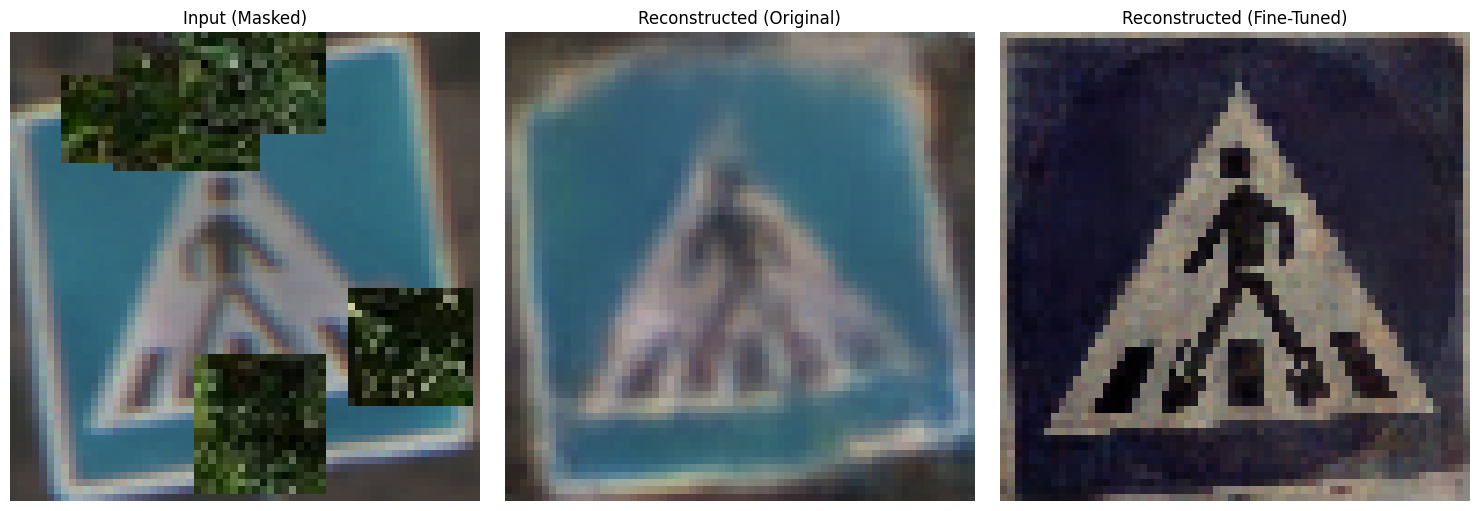

Verarbeite Bild: mask_5.png


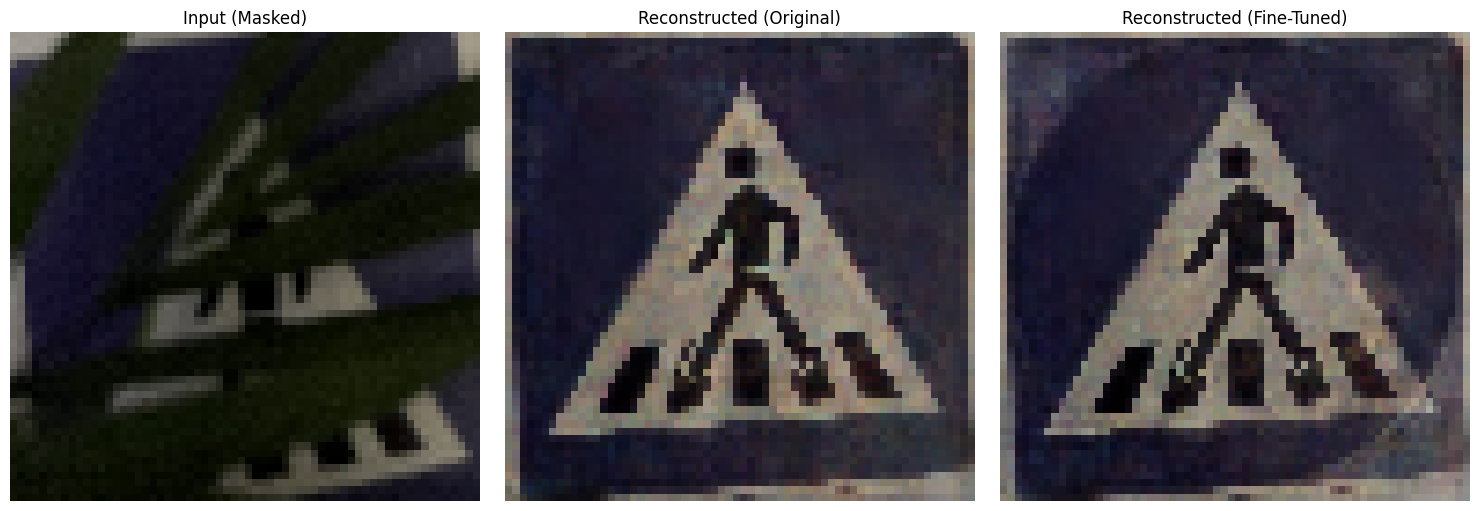

Verarbeite Bild: mask_14.png


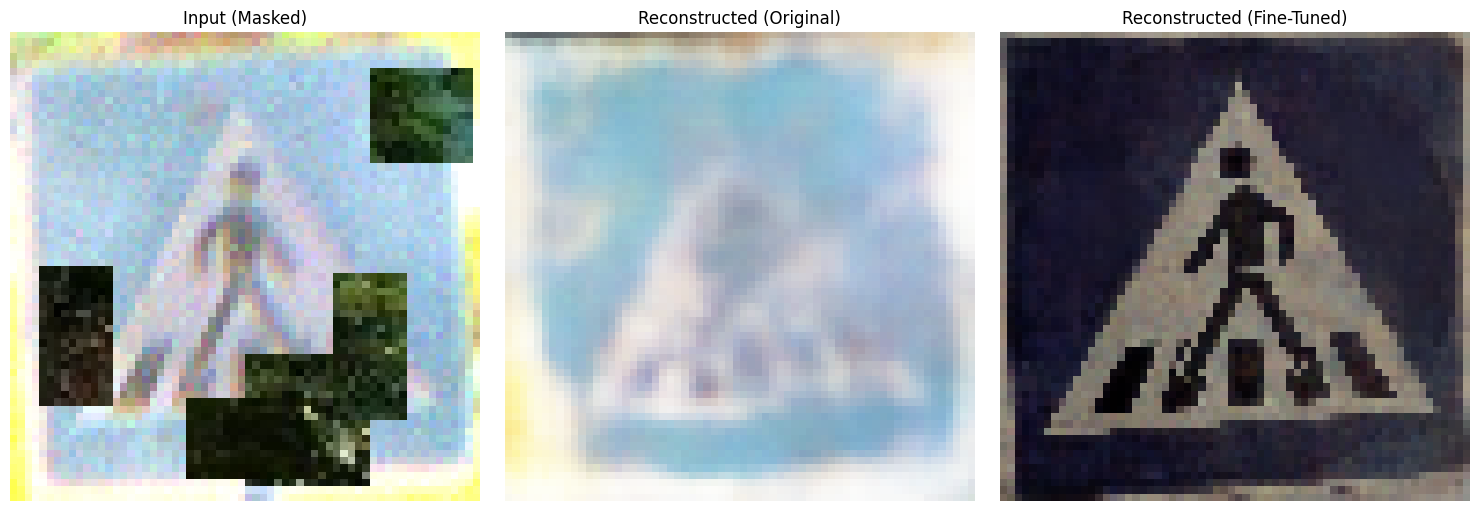

Verarbeite Bild: mask_19.png


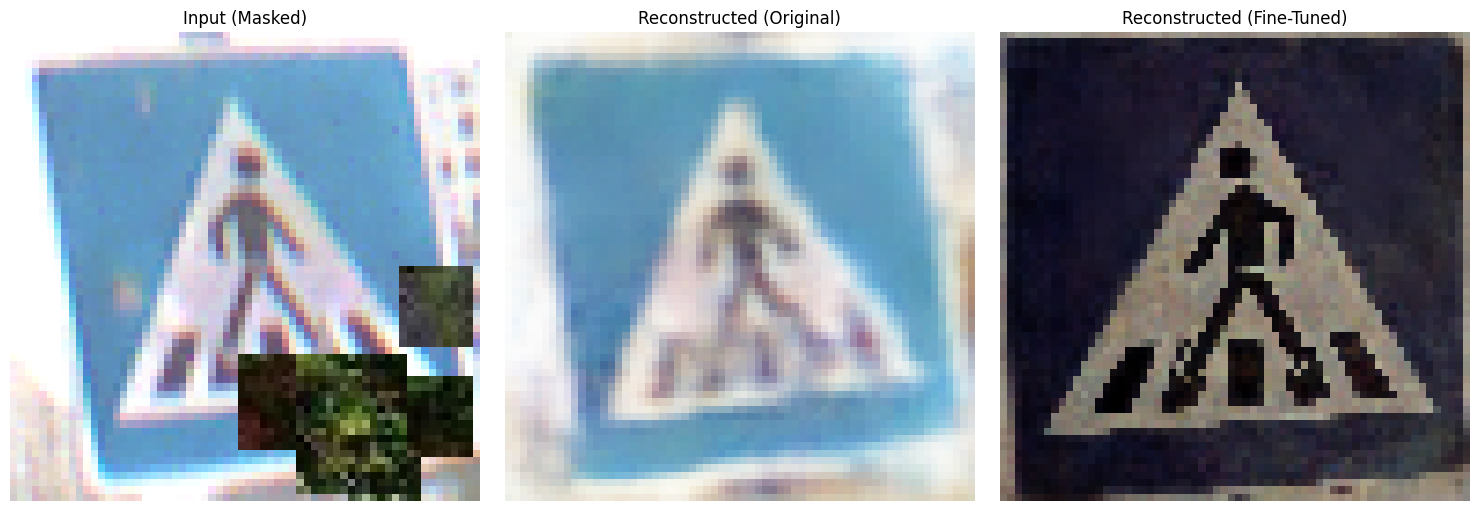

Verarbeite Bild: mask_18.png


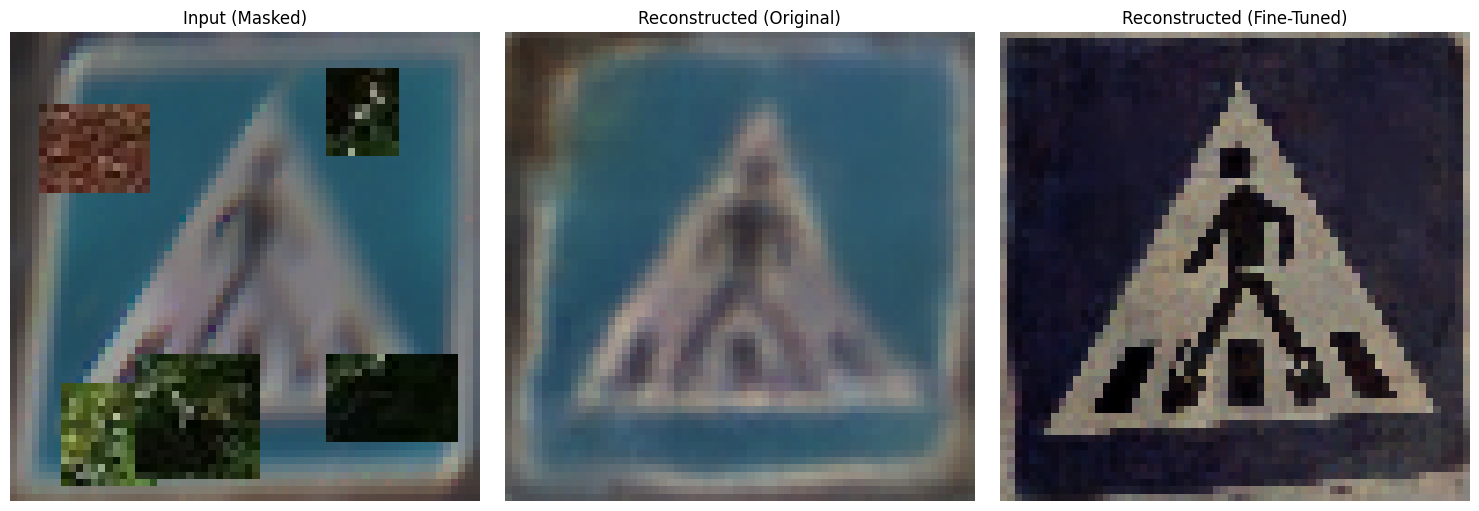

Verarbeite Bild: mask_15.png


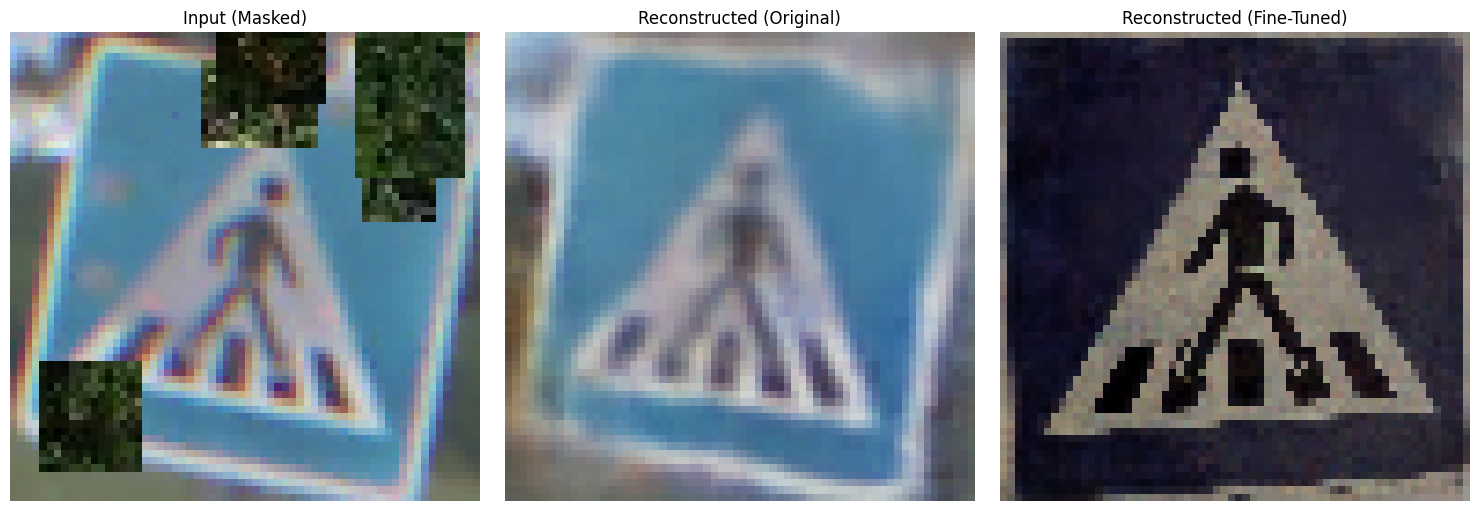

Verarbeite Bild: mask_8.png


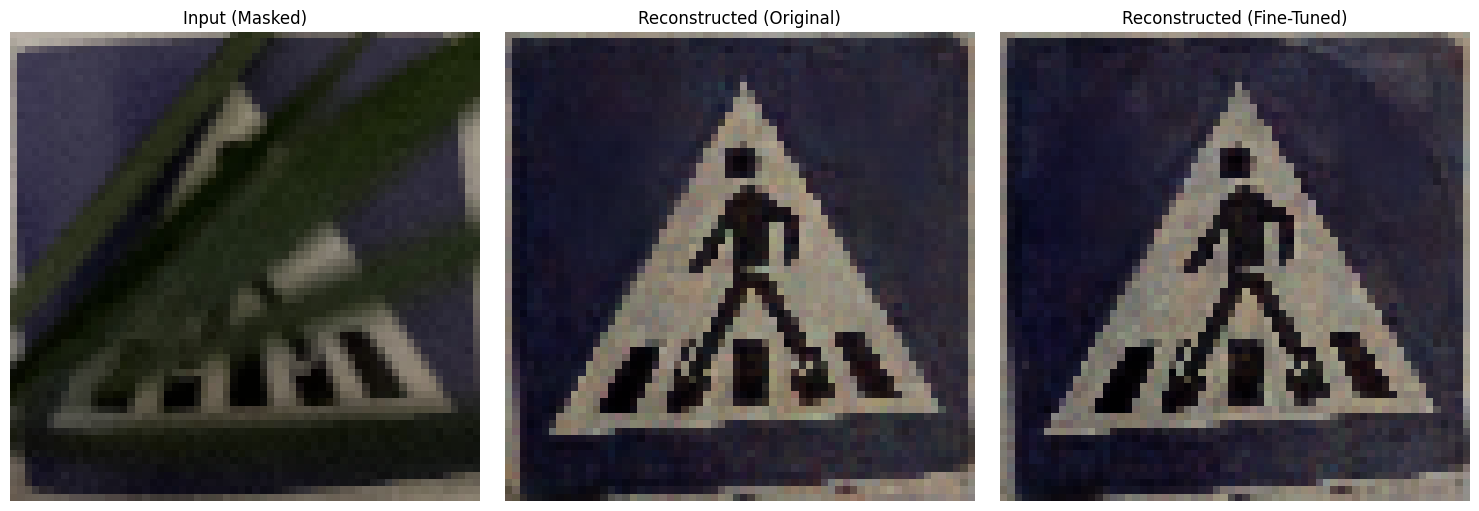

Verarbeite Bild: mask_11.png


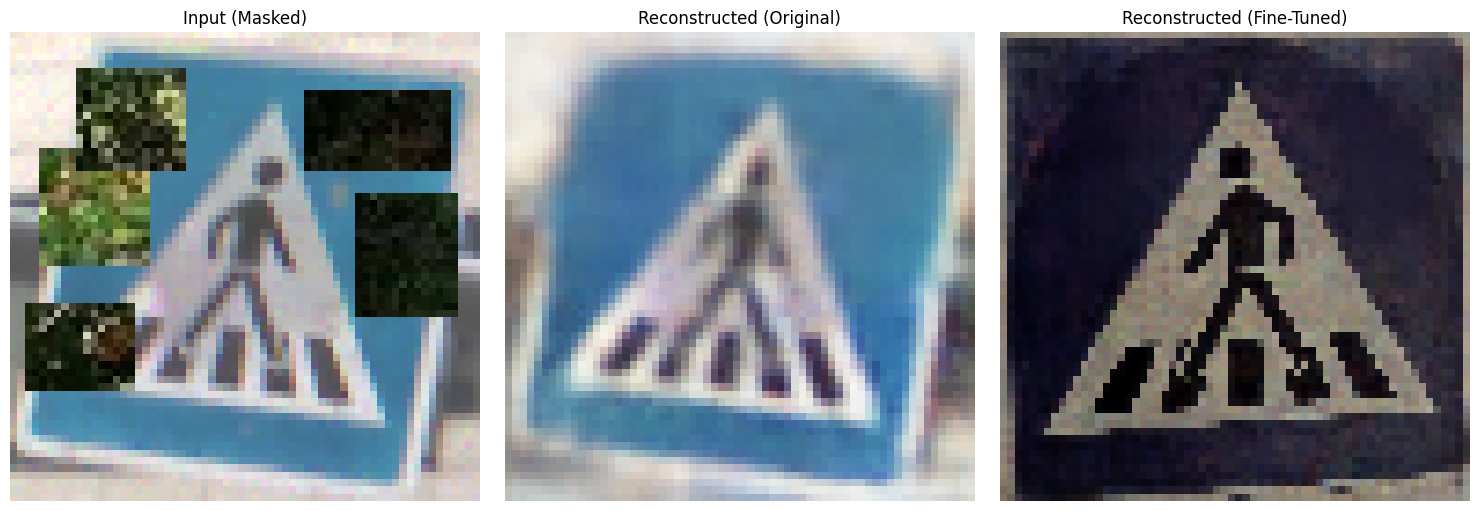

Verarbeite Bild: mask_16.png


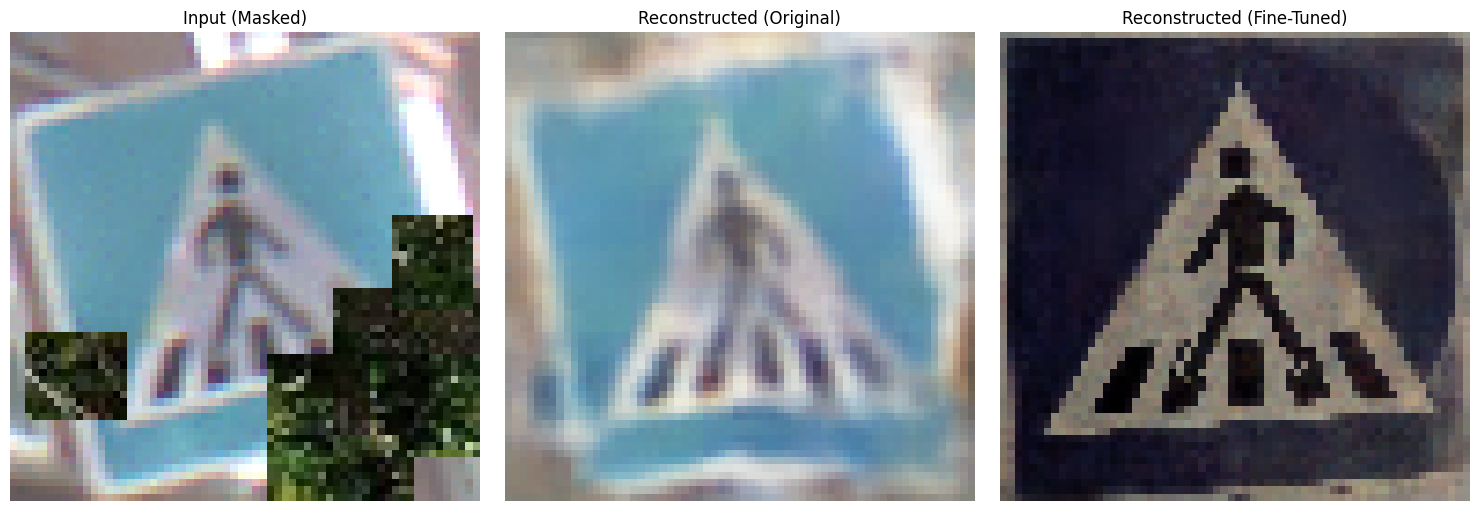

Verarbeite Bild: mask_4.png


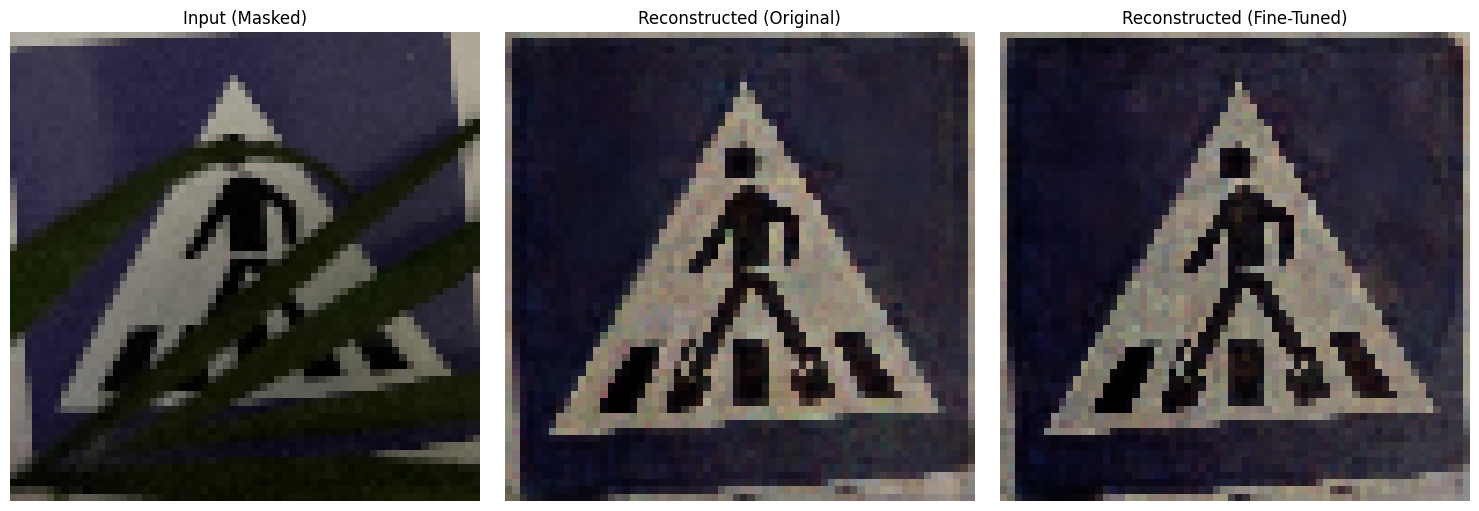

Verarbeite Bild: mask_1.png


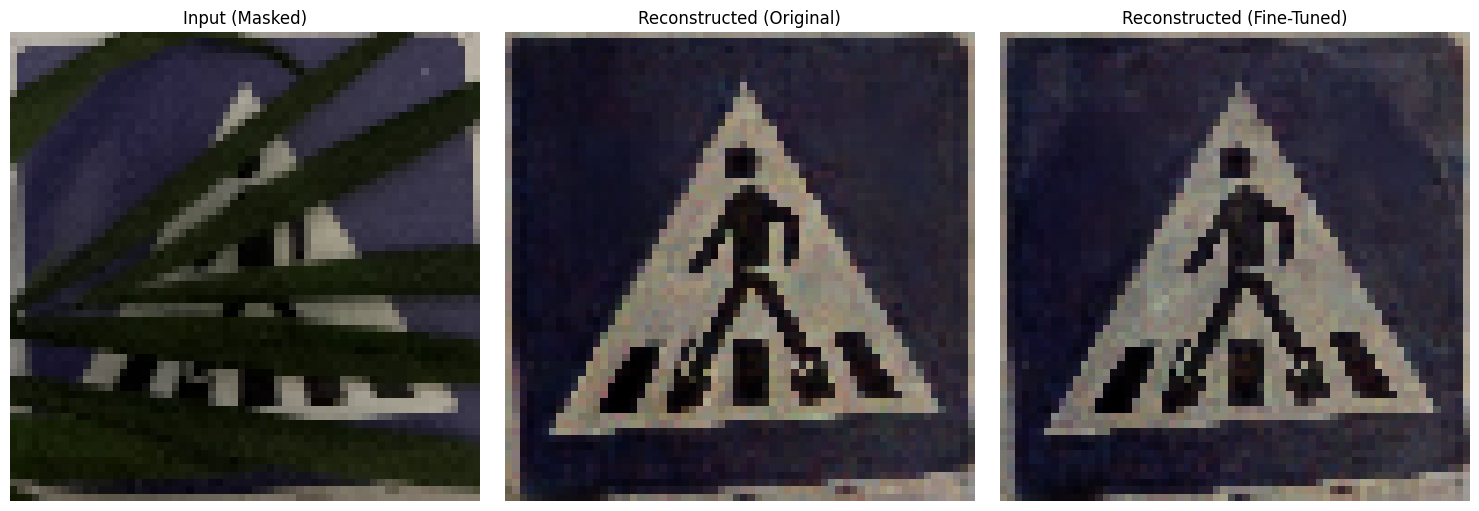

Verarbeite Bild: mask_17.png


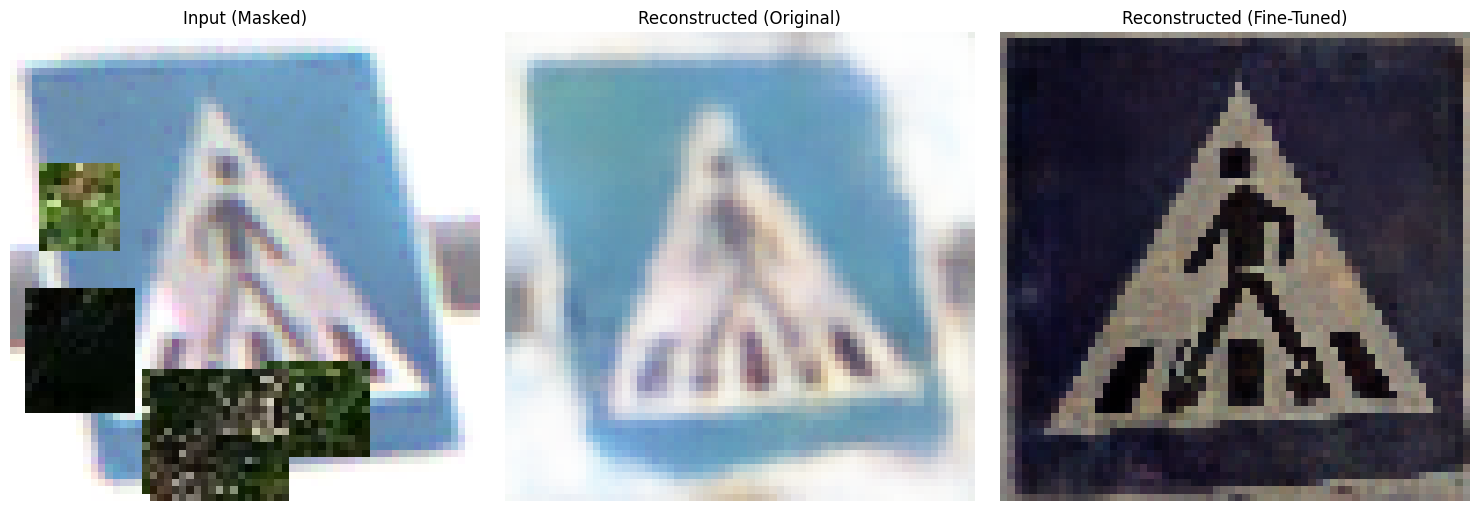

Verarbeite Bild: mask_6.png


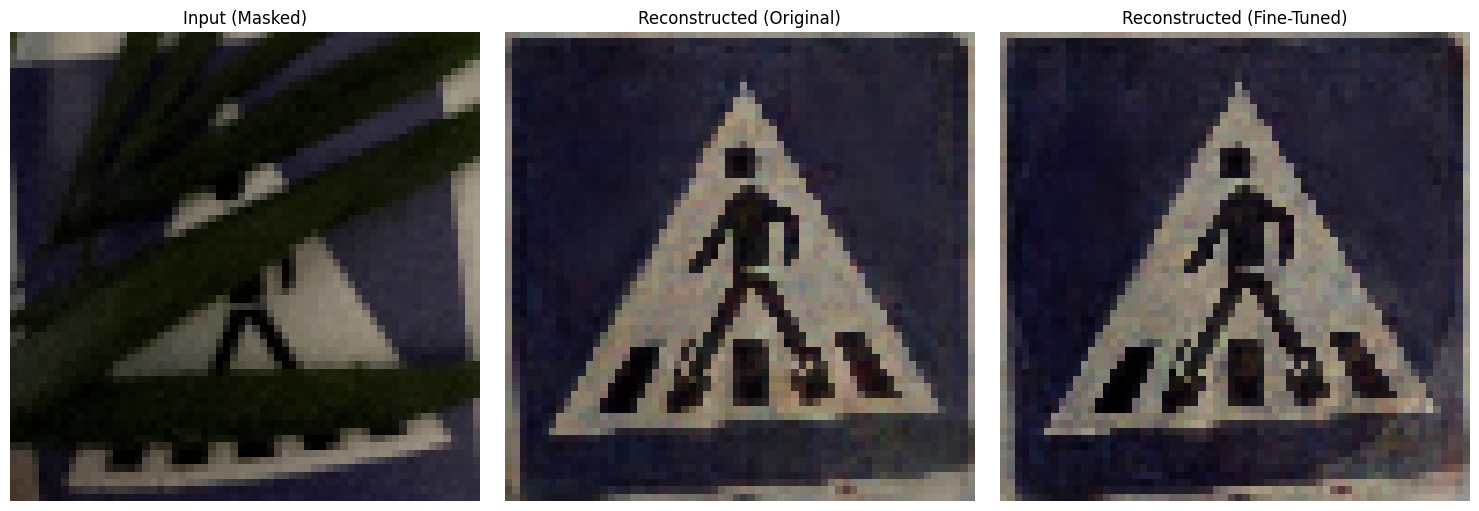

Verarbeite Bild: mask_13.png


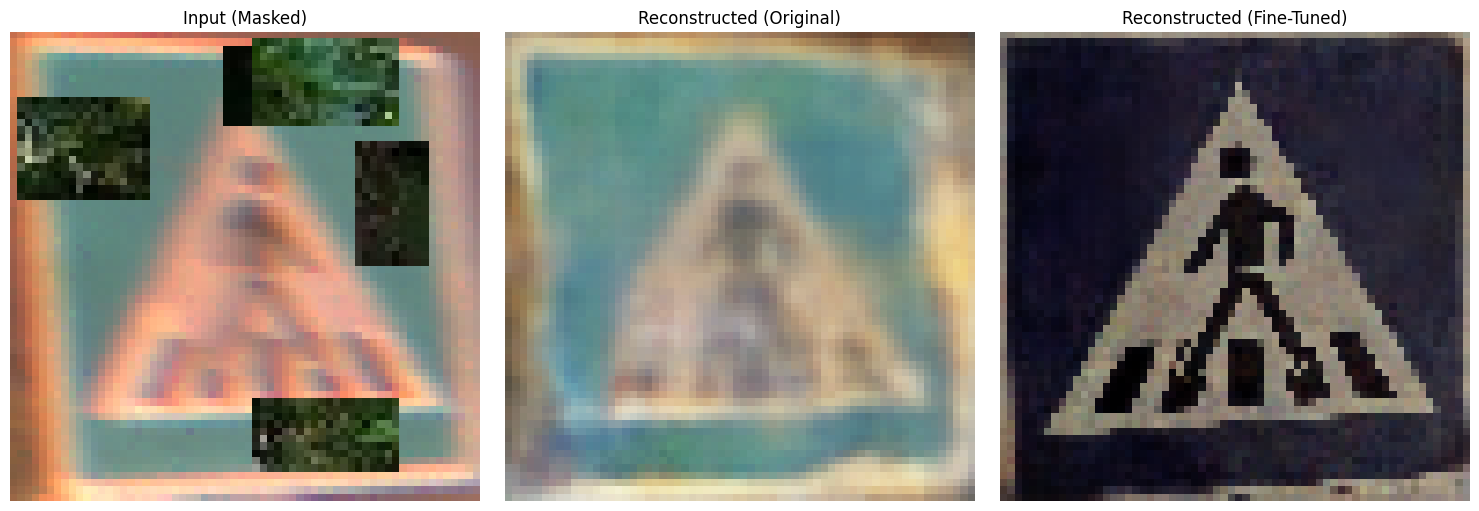

Verarbeite Bild: mask_7.png


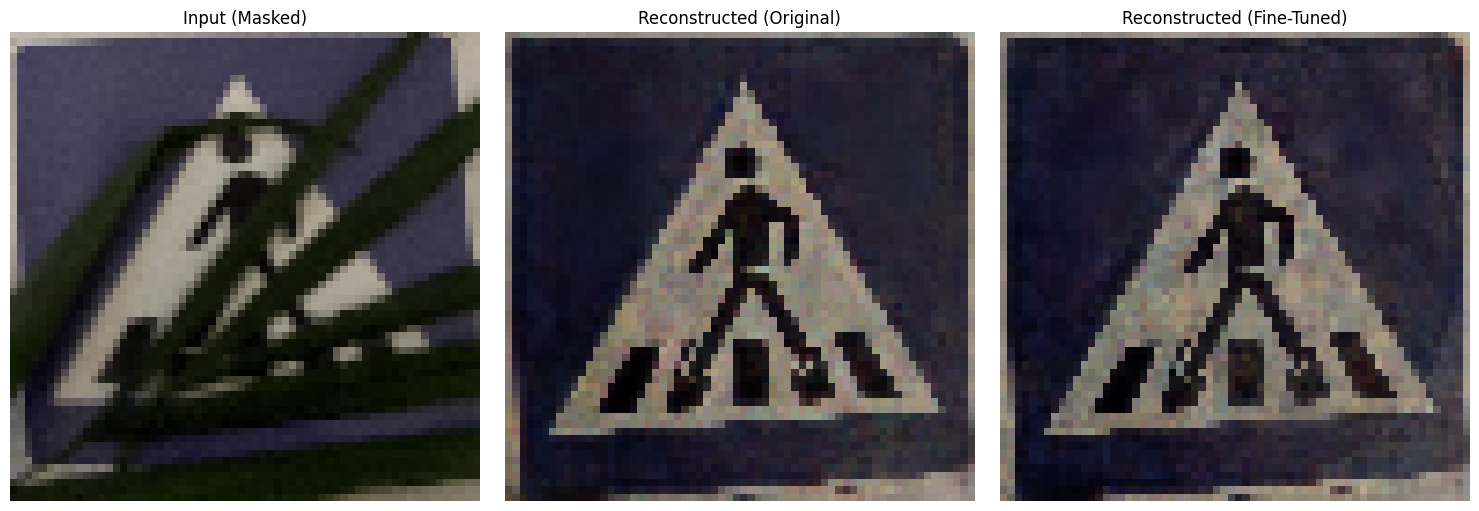

Verarbeite Bild: mask_2.png


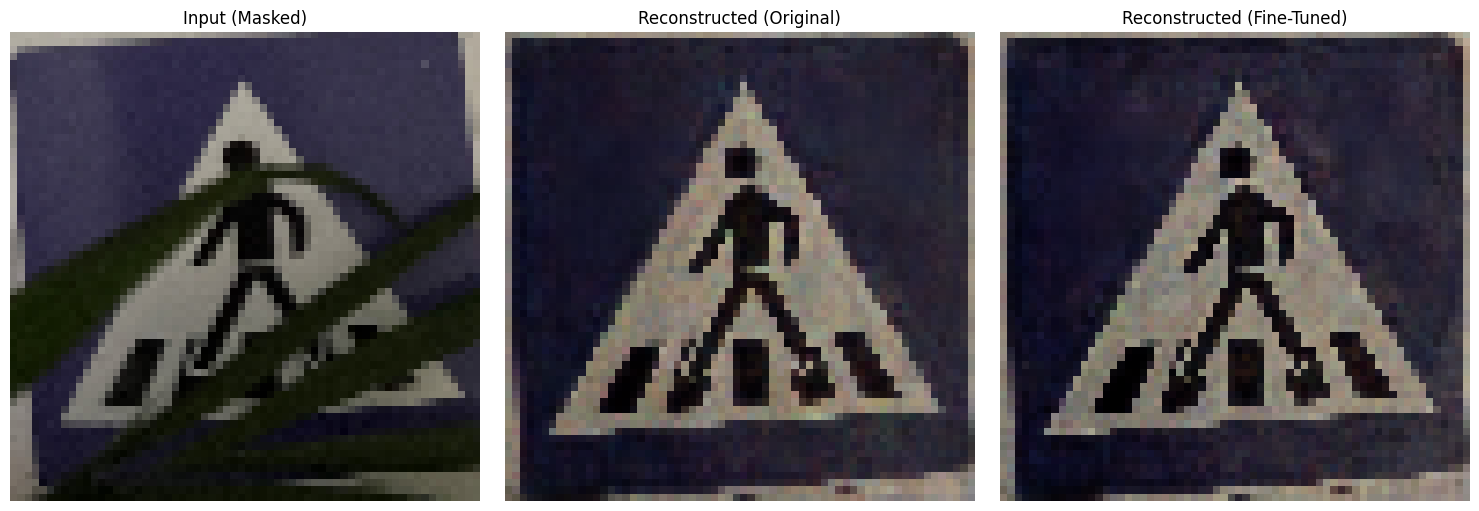

Verarbeite Bild: mask_9.png


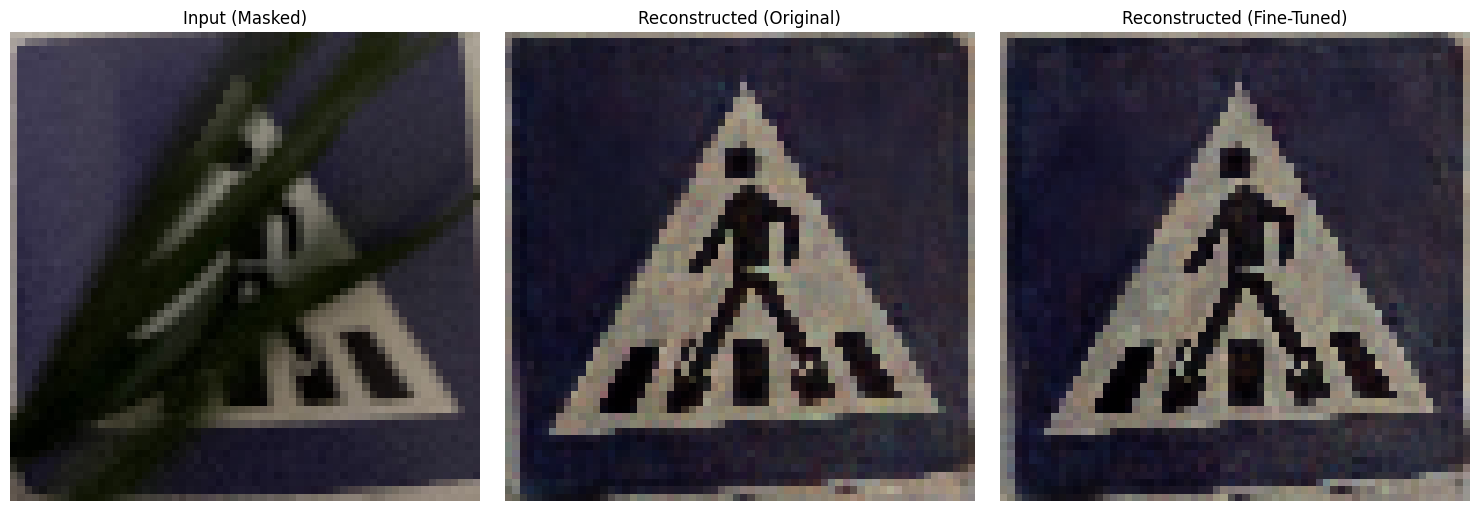

In [47]:
import os
import numpy as np
import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# ONNX-Modellpfade
original_model_path = "autoencoder.onnx"  # Pfad zum ursprünglichen Modell
fine_tuned_model_path = "finetuned_autoencoder.onnx"  # Pfad zum feinjustierten Modell

# Verzeichnis mit Eingabebildern
input_dir = "/content/extracted1/input"  # Verzeichnis mit Eingabebildern

# Bildvorverarbeitung
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalisierung auf [-1, 1]
])

# Rücknormalisierung für Visualisierung
def denormalize(image_tensor):
    return (image_tensor * 0.5 + 0.5).clip(0, 1)  # Rückumwandlung in den Bereich [0, 1]

# Modelle laden und Inferenz-Sessions erstellen
original_session = ort.InferenceSession(original_model_path)
fine_tuned_session = ort.InferenceSession(fine_tuned_model_path)
print("Beide ONNX-Modelle erfolgreich geladen.")

# Funktion, um ein Bild zu rekonstruieren und zu vergleichen
def compare_models(input_path):
    # Eingabebild laden und vorverarbeiten
    image = Image.open(input_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).numpy()  # Hinzufügen der Batch-Dimension

    # Inferenz für beide Modelle
    original_reconstructed = original_session.run(None, {"input": input_tensor})[0]
    fine_tuned_reconstructed = fine_tuned_session.run(None, {"input": input_tensor})[0]

    # Rücknormalisierung und Bildskalierung für die Visualisierung
    original_reconstructed_image = denormalize(original_reconstructed[0]).transpose(1, 2, 0)
    fine_tuned_reconstructed_image = denormalize(fine_tuned_reconstructed[0]).transpose(1, 2, 0)

    # Bilder anzeigen
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(np.array(image) / 255.0)  # Originaleingabe (maskiert)
    axes[0].set_title("Input (Masked)")
    axes[0].axis("off")

    axes[1].imshow(original_reconstructed_image)
    axes[1].set_title("Reconstructed (Original)")
    axes[1].axis("off")

    axes[2].imshow(fine_tuned_reconstructed_image)
    axes[2].set_title("Reconstructed (Fine-Tuned)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Alle Testbilder verarbeiten und vergleichen
for file_name in os.listdir(input_dir):
    if file_name.endswith(".png"):  # Nur PNG-Bilder verarbeiten
        input_path = os.path.join(input_dir, file_name)
        print(f"Verarbeite Bild: {file_name}")
        compare_models(input_path)


Beide ONNX-Modelle erfolgreich geladen.
Verarbeite Bild: cropped_5_pflanze.png


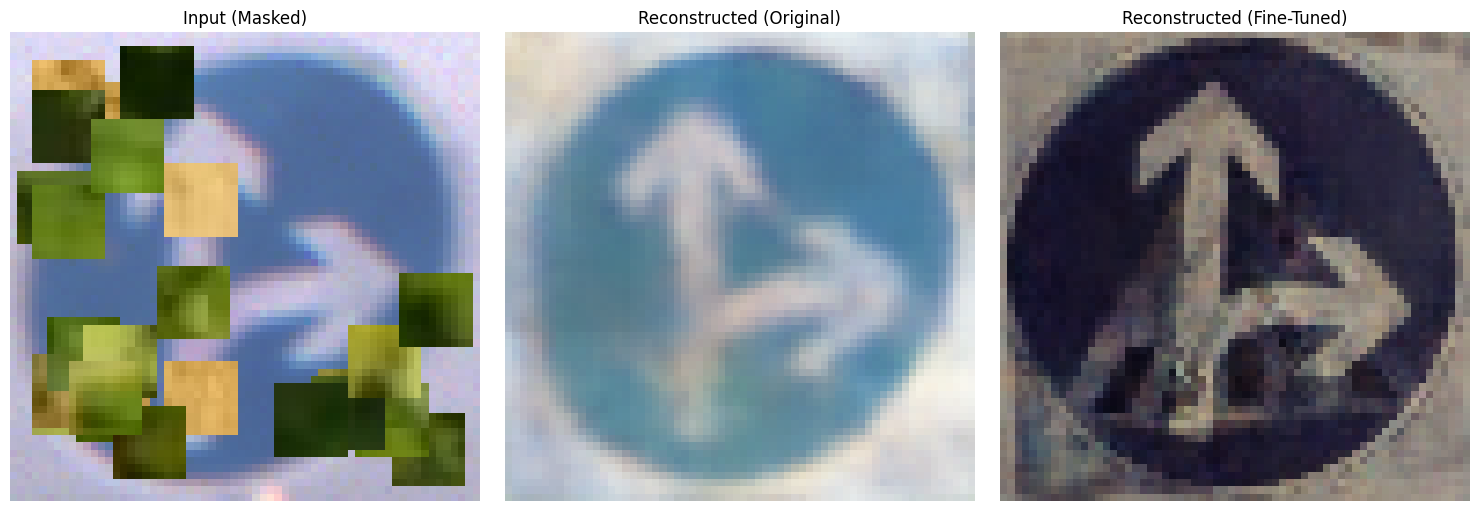

Verarbeite Bild: cropped_0_pflanze.png


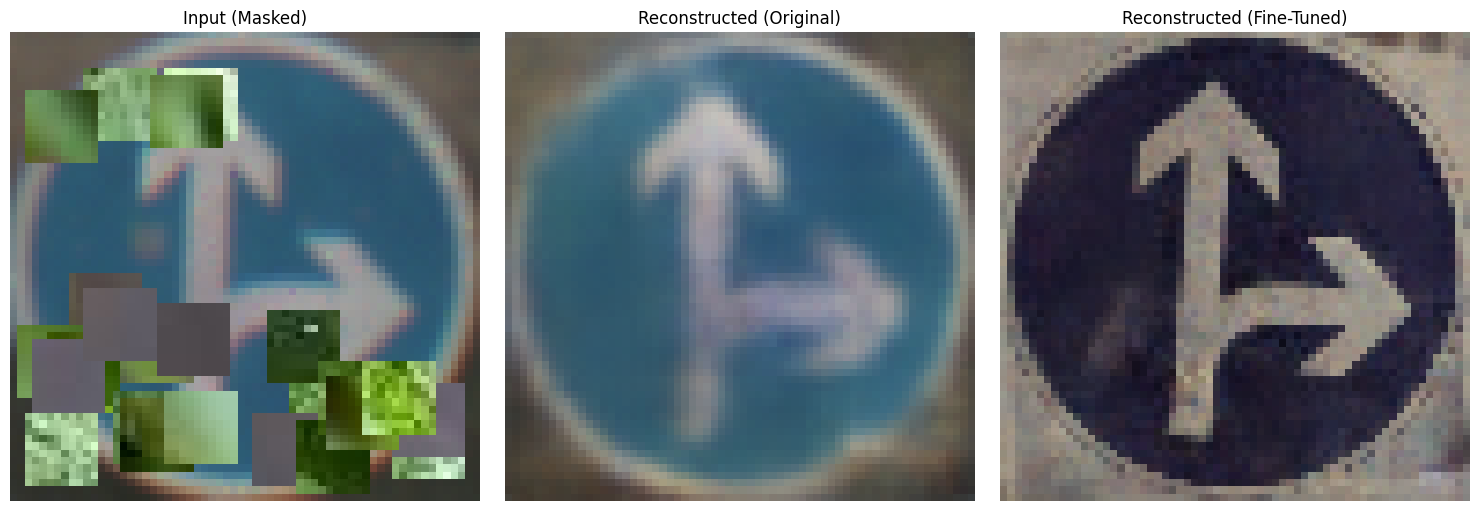

Verarbeite Bild: cropped_3_pflanze.png


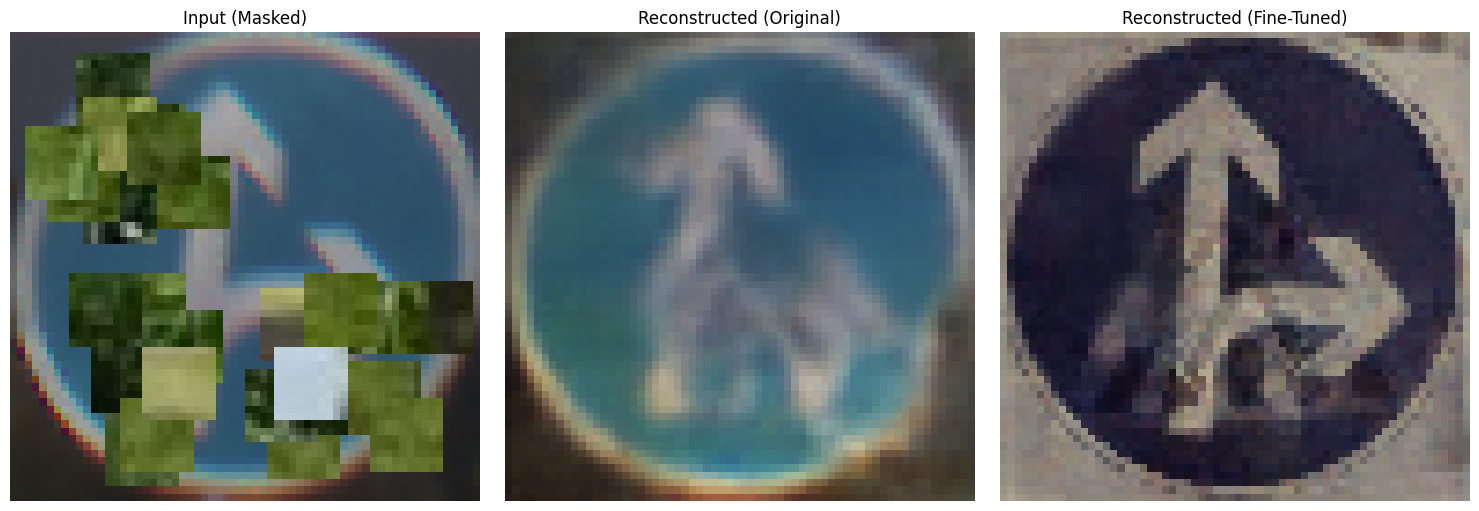

Verarbeite Bild: cropped_4_pflanze.png


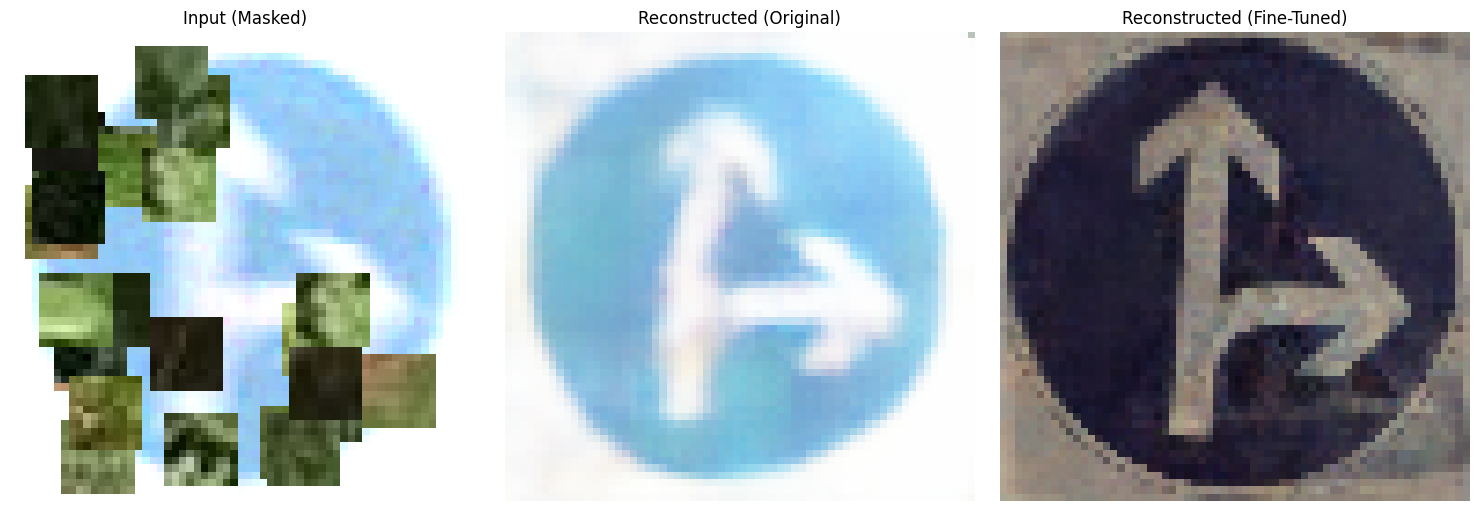

Verarbeite Bild: cropped_2_pflanze.png


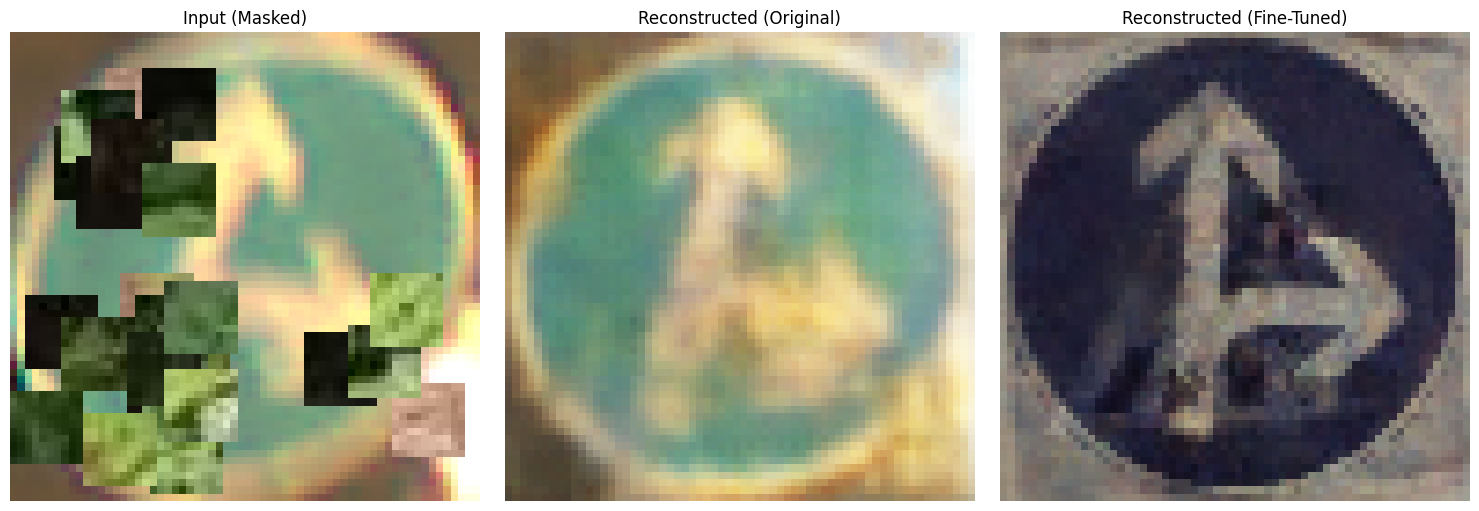

Verarbeite Bild: cropped_1_pflanze.png


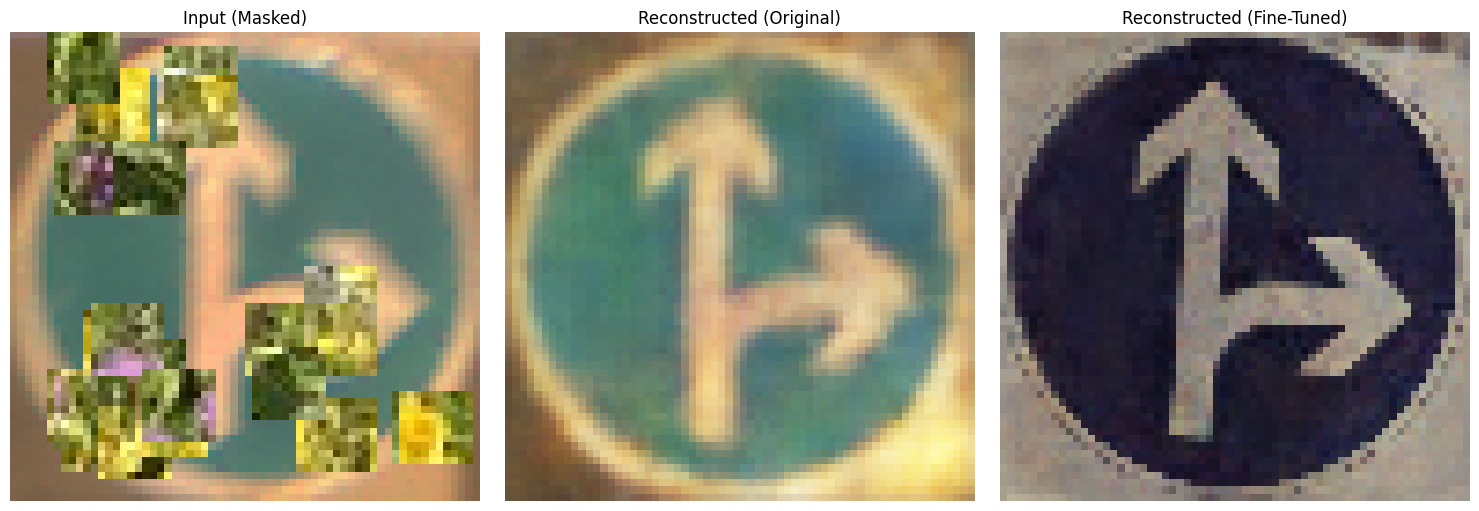

In [44]:
import os
import numpy as np
import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# ONNX-Modellpfade
original_model_path = "autoencoder.onnx"  # Pfad zum ursprünglichen Modell
fine_tuned_model_path = "finetuned_autoencoder.onnx"  # Pfad zum feinjustierten Modell

# Verzeichnis mit Eingabebildern
input_dir = "/content/extracted/test/geradeaus_rechts/input_pflanzen"  # Verzeichnis mit Eingabebildern

# Bildvorverarbeitung
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalisierung auf [-1, 1]
])

# Rücknormalisierung für Visualisierung
def denormalize(image_tensor):
    return (image_tensor * 0.5 + 0.5).clip(0, 1)  # Rückumwandlung in den Bereich [0, 1]

# Modelle laden und Inferenz-Sessions erstellen
original_session = ort.InferenceSession(original_model_path)
fine_tuned_session = ort.InferenceSession(fine_tuned_model_path)
print("Beide ONNX-Modelle erfolgreich geladen.")

# Funktion, um ein Bild zu rekonstruieren und zu vergleichen
def compare_models(input_path):
    # Eingabebild laden und vorverarbeiten
    image = Image.open(input_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).numpy()  # Hinzufügen der Batch-Dimension

    # Inferenz für beide Modelle
    original_reconstructed = original_session.run(None, {"input": input_tensor})[0]
    fine_tuned_reconstructed = fine_tuned_session.run(None, {"input": input_tensor})[0]

    # Rücknormalisierung und Bildskalierung für die Visualisierung
    original_reconstructed_image = denormalize(original_reconstructed[0]).transpose(1, 2, 0)
    fine_tuned_reconstructed_image = denormalize(fine_tuned_reconstructed[0]).transpose(1, 2, 0)

    # Bilder anzeigen
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(np.array(image) / 255.0)  # Originaleingabe (maskiert)
    axes[0].set_title("Input (Masked)")
    axes[0].axis("off")

    axes[1].imshow(original_reconstructed_image)
    axes[1].set_title("Reconstructed (Original)")
    axes[1].axis("off")

    axes[2].imshow(fine_tuned_reconstructed_image)
    axes[2].set_title("Reconstructed (Fine-Tuned)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Alle Testbilder verarbeiten und vergleichen
for file_name in os.listdir(input_dir):
    if file_name.endswith(".png"):  # Nur PNG-Bilder verarbeiten
        input_path = os.path.join(input_dir, file_name)
        print(f"Verarbeite Bild: {file_name}")
        compare_models(input_path)


Beide ONNX-Modelle erfolgreich geladen.
Verarbeite Bild: cropped_1_auto.png


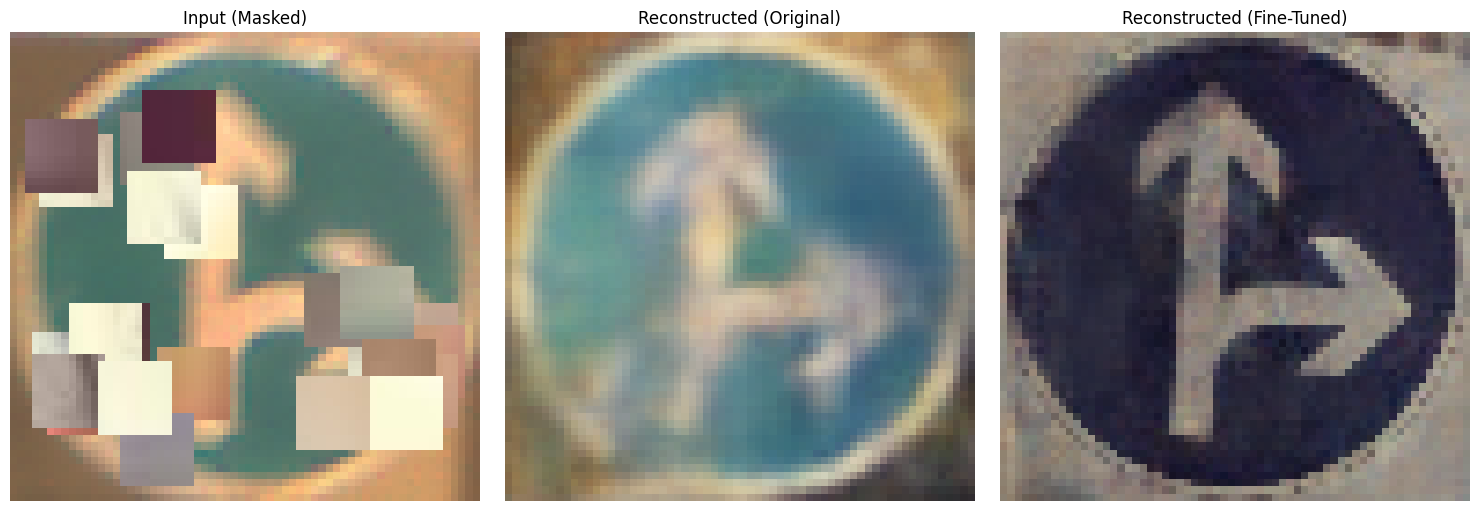

Verarbeite Bild: cropped_4_auto.png


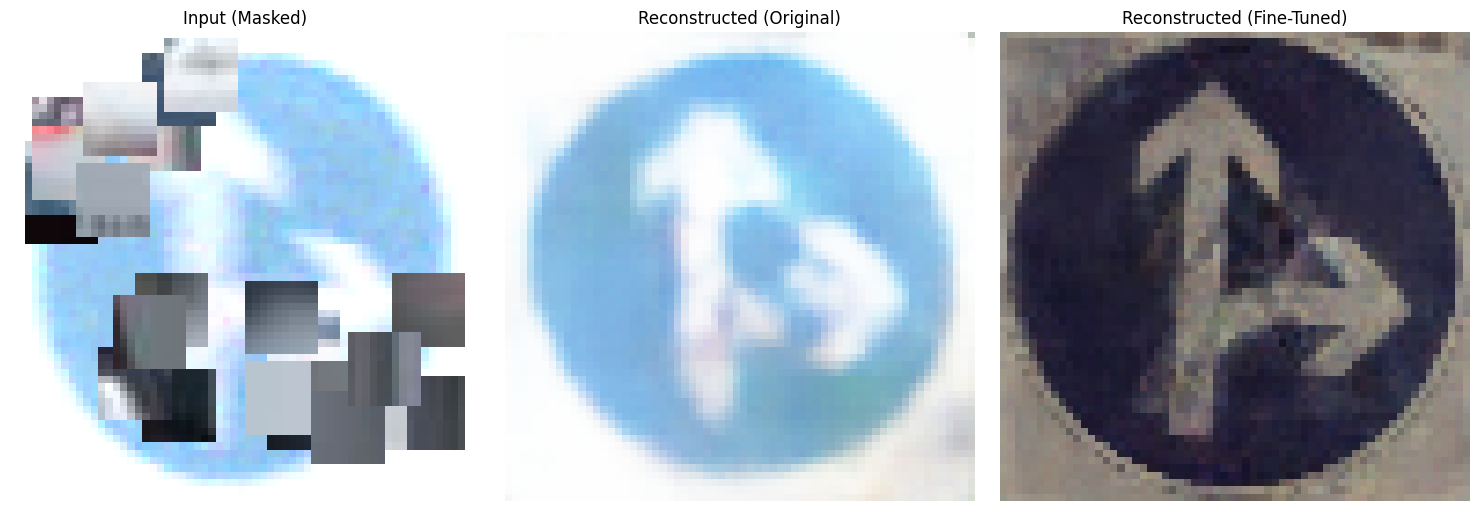

Verarbeite Bild: cropped_0_auto.png


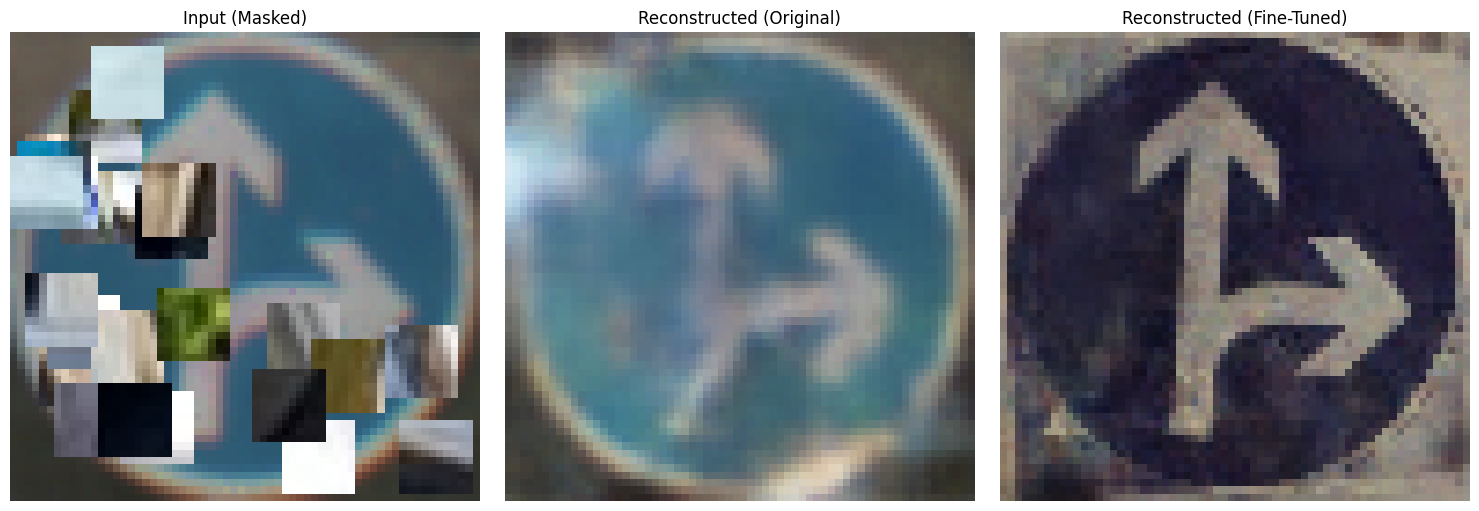

Verarbeite Bild: cropped_3_auto.png


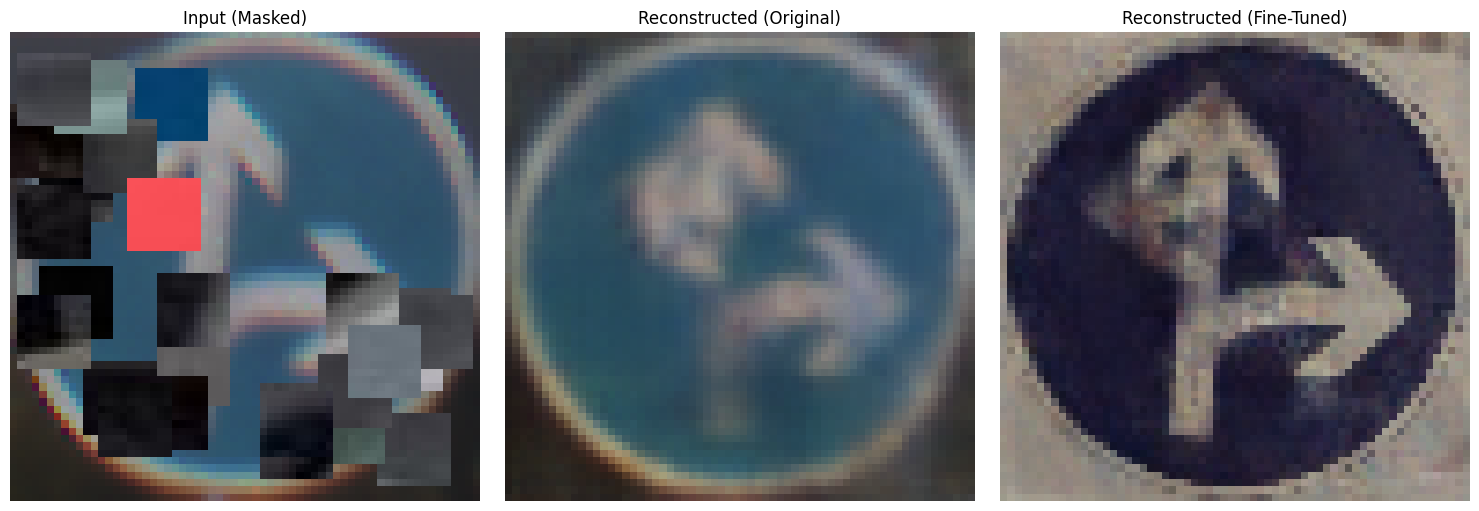

In [46]:
import os
import numpy as np
import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# ONNX-Modellpfade
original_model_path = "autoencoder.onnx"  # Pfad zum ursprünglichen Modell
fine_tuned_model_path = "finetuned_autoencoder.onnx"  # Pfad zum feinjustierten Modell

# Verzeichnis mit Eingabebildern
input_dir = "/content/extracted/test/geradeaus_rechts/input_autos"  # Verzeichnis mit Eingabebildern

# Bildvorverarbeitung
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalisierung auf [-1, 1]
])

# Rücknormalisierung für Visualisierung
def denormalize(image_tensor):
    return (image_tensor * 0.5 + 0.5).clip(0, 1)  # Rückumwandlung in den Bereich [0, 1]

# Modelle laden und Inferenz-Sessions erstellen
original_session = ort.InferenceSession(original_model_path)
fine_tuned_session = ort.InferenceSession(fine_tuned_model_path)
print("Beide ONNX-Modelle erfolgreich geladen.")

# Funktion, um ein Bild zu rekonstruieren und zu vergleichen
def compare_models(input_path):
    # Eingabebild laden und vorverarbeiten
    image = Image.open(input_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).numpy()  # Hinzufügen der Batch-Dimension

    # Inferenz für beide Modelle
    original_reconstructed = original_session.run(None, {"input": input_tensor})[0]
    fine_tuned_reconstructed = fine_tuned_session.run(None, {"input": input_tensor})[0]

    # Rücknormalisierung und Bildskalierung für die Visualisierung
    original_reconstructed_image = denormalize(original_reconstructed[0]).transpose(1, 2, 0)
    fine_tuned_reconstructed_image = denormalize(fine_tuned_reconstructed[0]).transpose(1, 2, 0)

    # Bilder anzeigen
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(np.array(image) / 255.0)  # Originaleingabe (maskiert)
    axes[0].set_title("Input (Masked)")
    axes[0].axis("off")

    axes[1].imshow(original_reconstructed_image)
    axes[1].set_title("Reconstructed (Original)")
    axes[1].axis("off")

    axes[2].imshow(fine_tuned_reconstructed_image)
    axes[2].set_title("Reconstructed (Fine-Tuned)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Alle Testbilder verarbeiten und vergleichen
for file_name in os.listdir(input_dir):
    if file_name.endswith(".png"):  # Nur PNG-Bilder verarbeiten
        input_path = os.path.join(input_dir, file_name)
        print(f"Verarbeite Bild: {file_name}")
        compare_models(input_path)


In [50]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torchvision.transforms as transforms

# Gerät definieren
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Verwendetes Gerät: {device}")

# Custom Dataset für Feintraining
class FineTuningDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = []
        self.transform = transform

        # Iteriere durch die Klassen
        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            input_dir = os.path.join(class_dir, "input")
            target_dir = os.path.join(class_dir, "output")

            if not os.path.exists(target_dir):
                print(f"Kein Zielordner für Klasse: {class_name}")
                continue

            input_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(".png")]
            target_files = [os.path.join(target_dir, f) for f in os.listdir(target_dir) if f.startswith("clear_image") and f.endswith(".png")]

            if len(target_files) == 0:
                print(f"Keine Zielbilder in Klasse: {class_name}")
                continue

            # Ordne jedes Eingabebild zufällig einem Zielbild zu
            for input_file in input_files:
                target_file = target_files[torch.randint(0, len(target_files), (1,)).item()]
                self.data.append({"input": input_file, "target": target_file, "class": class_name})

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        input_image = Image.open(item["input"]).convert("RGB")
        target_image = Image.open(item["target"]).convert("RGB")

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image

# Transformationen für das Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalisierung auf [-1, 1]
])

# Dataset und DataLoader erstellen
train_root = "/content/dataset/train"  # Passe den Pfad an
train_dataset = FineTuningDataset(train_root, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"Anzahl der Trainingsbeispiele: {len(train_dataset)}")

# Modell definieren (Masked Autoencoder)
class MaskedAutoencoder(nn.Module):
    def __init__(self):
        super(MaskedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # 32x32 -> 64x64
            nn.Tanh(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Modell laden
model_path = "autoencoder.pth"  # Passe den Pfad an
model = MaskedAutoencoder().to(device)
model.load_state_dict(torch.load(model_path))
print("Modell erfolgreich geladen.")

# Loss-Funktion und Optimierer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Feintraining
epochs = 30
model.train()

for epoch in range(epochs):
    train_loss = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Vorwärtsdurchlauf
        outputs = model(inputs)

        # Verlust berechnen
        loss = criterion(outputs, targets)

        # Rückwärtsdurchlauf und Optimierung
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

# Feintrainiertes Modell speichern
fine_tuned_path = "/content/fine_tuned_autoencoder.pth"
torch.save(model.state_dict(), fine_tuned_path)
print(f"Feintrainiertes Modell gespeichert unter: {fine_tuned_path}")


Verwendetes Gerät: cuda
Anzahl der Trainingsbeispiele: 3318
Modell erfolgreich geladen.


<ipython-input-50-9614f5bc7b6e>:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Epoch [1/30], Loss: 0.1923
Epoch [2/30], Loss: 0.1595
Epoch [3/30], Loss: 0.1515
Epoch [4/30], Loss: 0.1461
Epoch [5/30], Loss: 0.1417
Epoch [6/30], Loss: 0.1391
Epoch [7/30], Loss: 0.1355
Epoch [8/30], Loss: 0.1330
Epoch [9/30], Loss: 0.1302
Epoch [10/30], Loss: 0.1273
Epoch [11/30], Loss: 0.1240
Epoch [12/30], Loss: 0.1200
Epoch [13/30], Loss: 0.1150
Epoch [14/30], Loss: 0.1110
Epoch [15/30], Loss: 0.1044
Epoch [16/30], Loss: 0.0984
Epoch [17/30], Loss: 0.0913
Epoch [18/30], Loss: 0.0850
Epoch [19/30], Loss: 0.0786
Epoch [20/30], Loss: 0.0726
Epoch [21/30], Loss: 0.0674
Epoch [22/30], Loss: 0.0630
Epoch [23/30], Loss: 0.0589
Epoch [24/30], Loss: 0.0554
Epoch [25/30], Loss: 0.0519
Epoch [26/30], Loss: 0.0489
Epoch [27/30], Loss: 0.0463
Epoch [28/30], Loss: 0.0441
Epoch [29/30], Loss: 0.0418
Epoch [30/30], Loss: 0.0398
Feintrainiertes Modell gespeichert unter: /content/fine_tuned_autoencoder.pth


In [51]:
import torch.onnx

# Dummy-Eingabe für das ONNX-Export
dummy_input = torch.randn(1, 3, 64, 64).to(device)

# Modell exportieren
onnx_export_path = "fine_tuned_autoencoder.onnx"
torch.onnx.export(
    model,
    dummy_input,
    onnx_export_path,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}}
)
print(f"Modell erfolgreich als ONNX exportiert: {onnx_export_path}")


Modell erfolgreich als ONNX exportiert: fine_tuned_autoencoder.onnx


In [52]:
import onnx
import onnxruntime as ort

# ONNX-Modell laden
onnx_model = onnx.load(onnx_export_path)
onnx.checker.check_model(onnx_model)
print("ONNX-Modell erfolgreich validiert.")

# ONNX-Inferenz testen
session = ort.InferenceSession(onnx_export_path)
dummy_input = torch.randn(1, 3, 64, 64).numpy()
outputs = session.run(None, {"input": dummy_input})
print(f"Inferenz erfolgreich. Ausgabeshape: {outputs[0].shape}")

ONNX-Modell erfolgreich validiert.
Inferenz erfolgreich. Ausgabeshape: (1, 3, 64, 64)


Beide ONNX-Modelle erfolgreich geladen.
Verarbeite Bild: mask_3.png


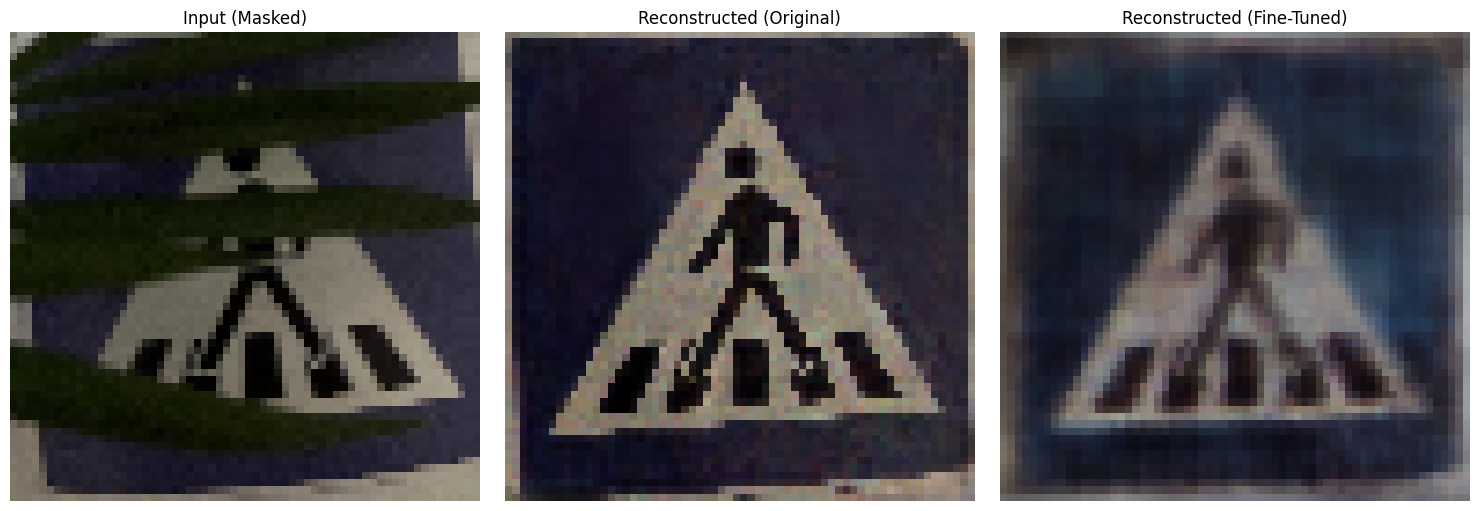

Verarbeite Bild: mask_10.png


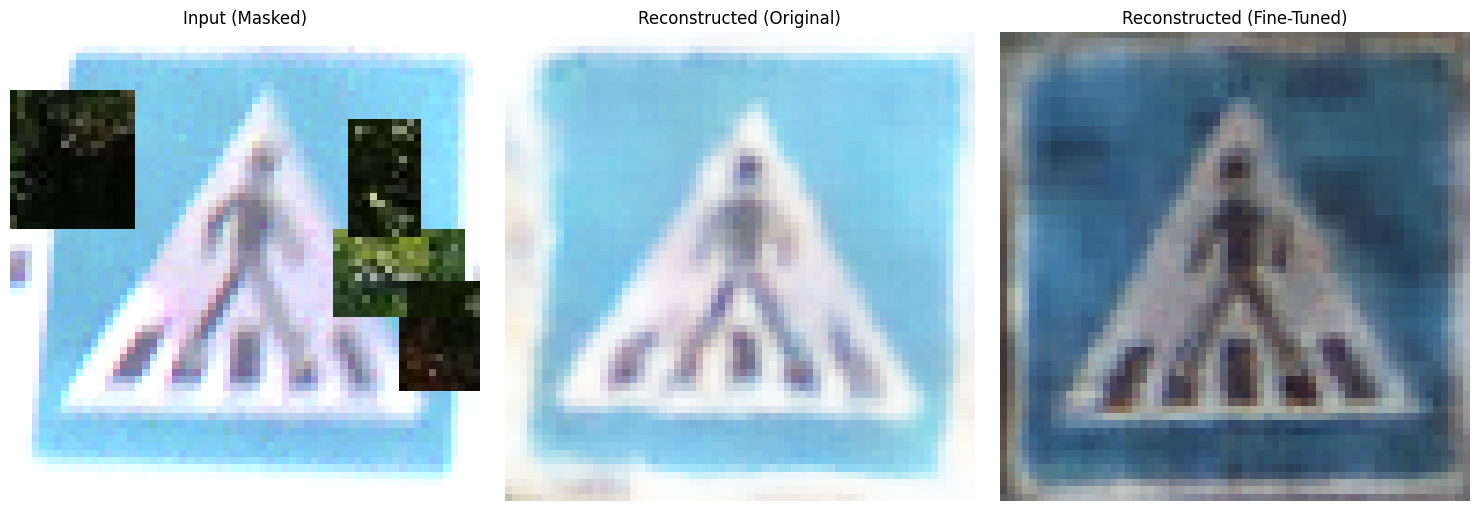

Verarbeite Bild: mask_12.png


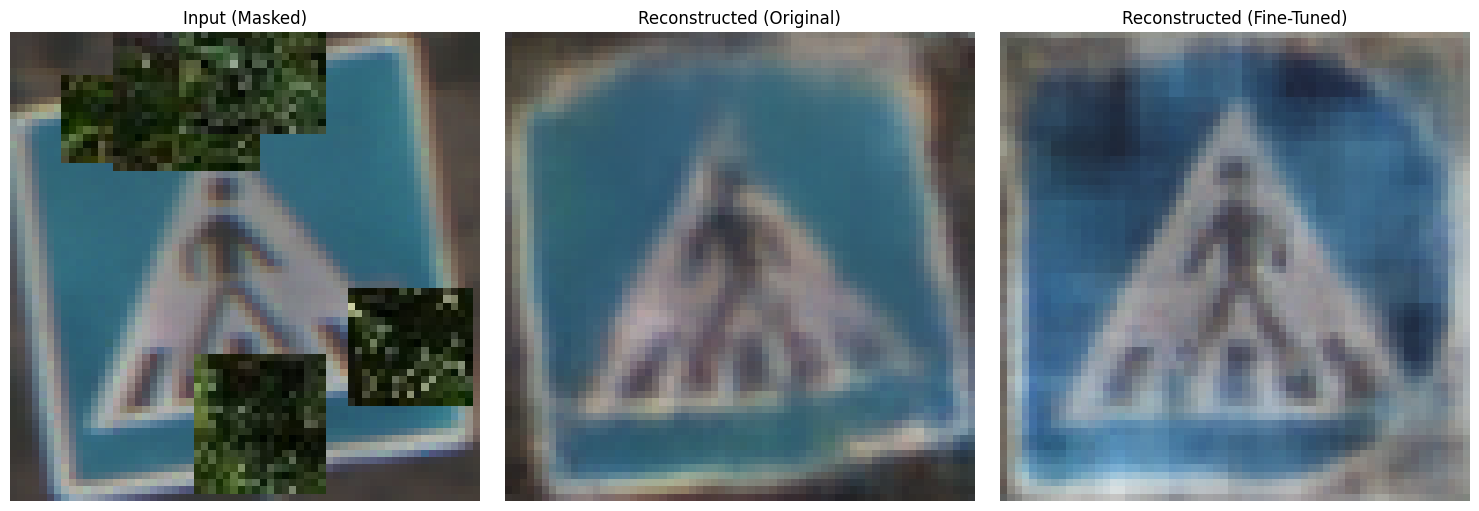

Verarbeite Bild: mask_5.png


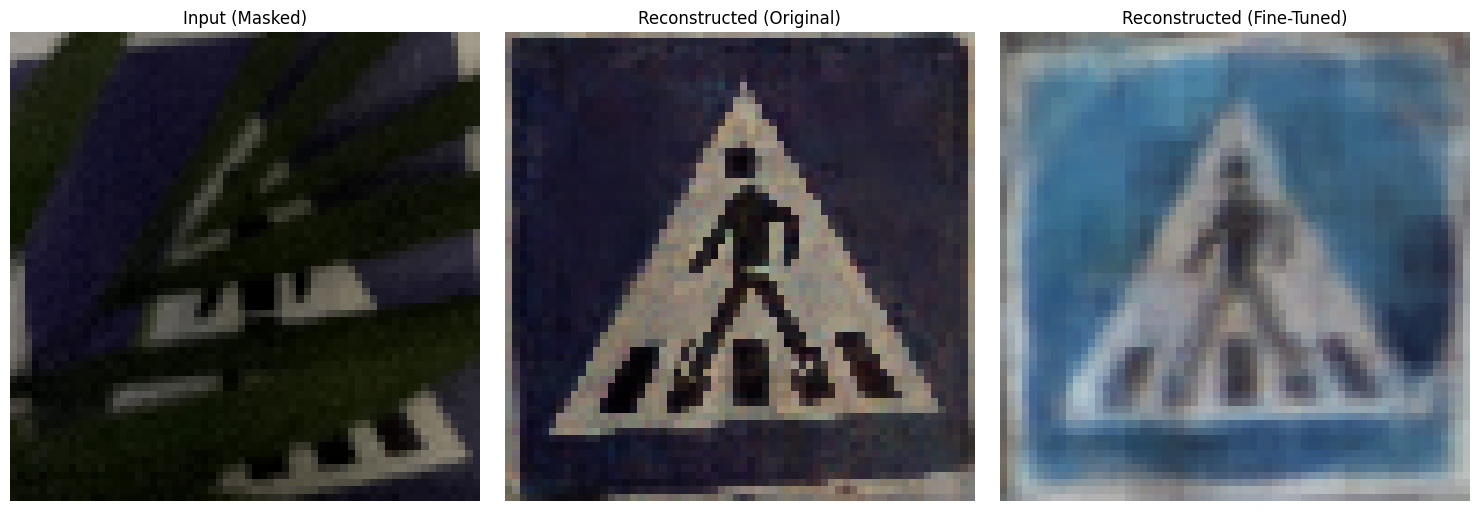

Verarbeite Bild: mask_14.png


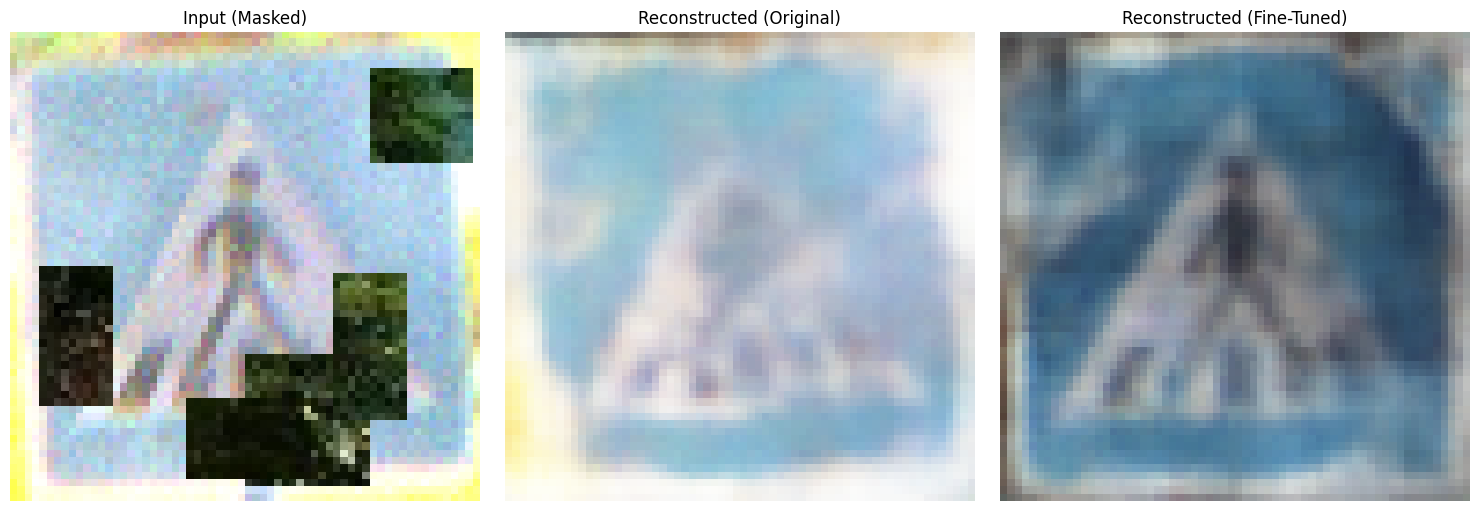

Verarbeite Bild: mask_19.png


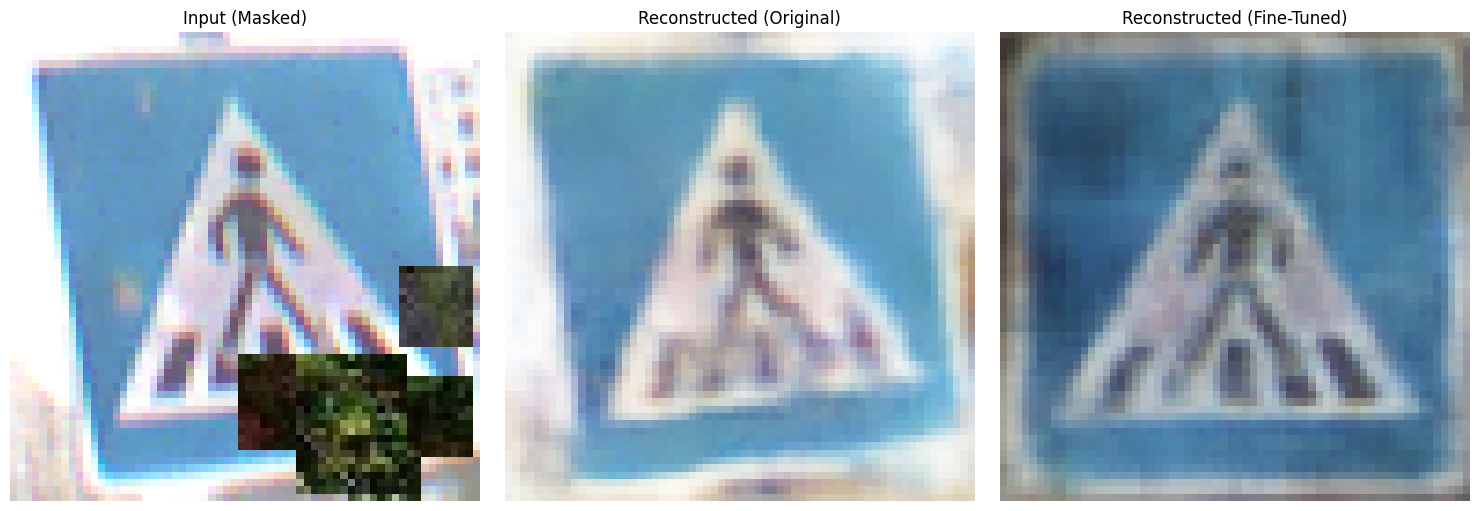

Verarbeite Bild: mask_18.png


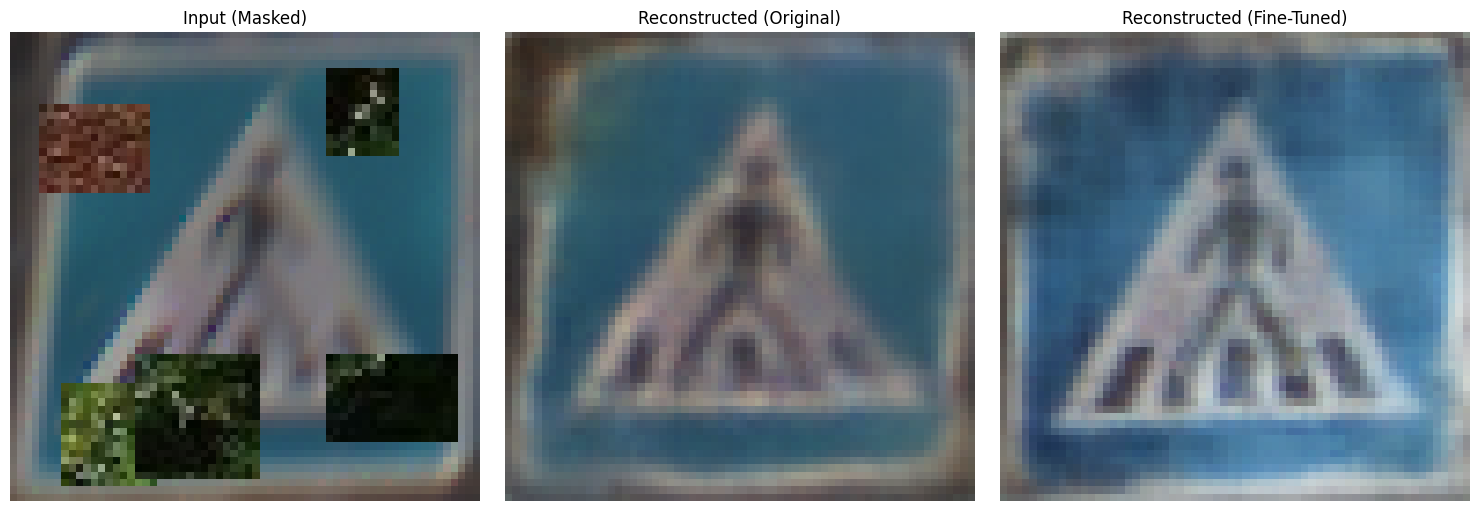

Verarbeite Bild: mask_15.png


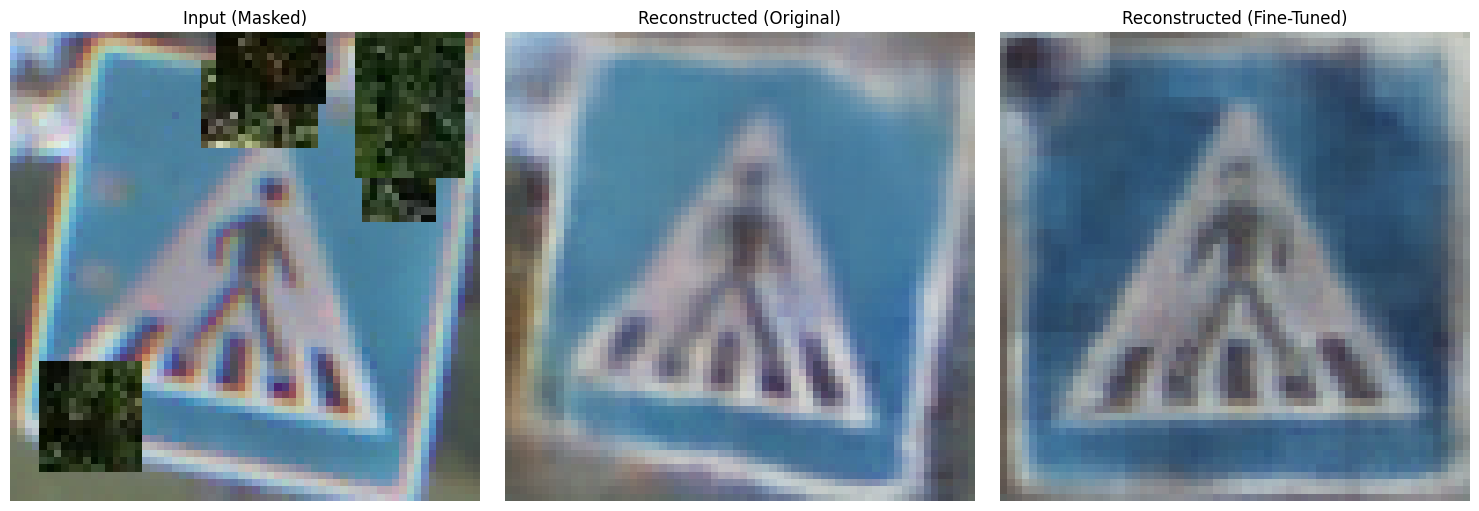

Verarbeite Bild: mask_8.png


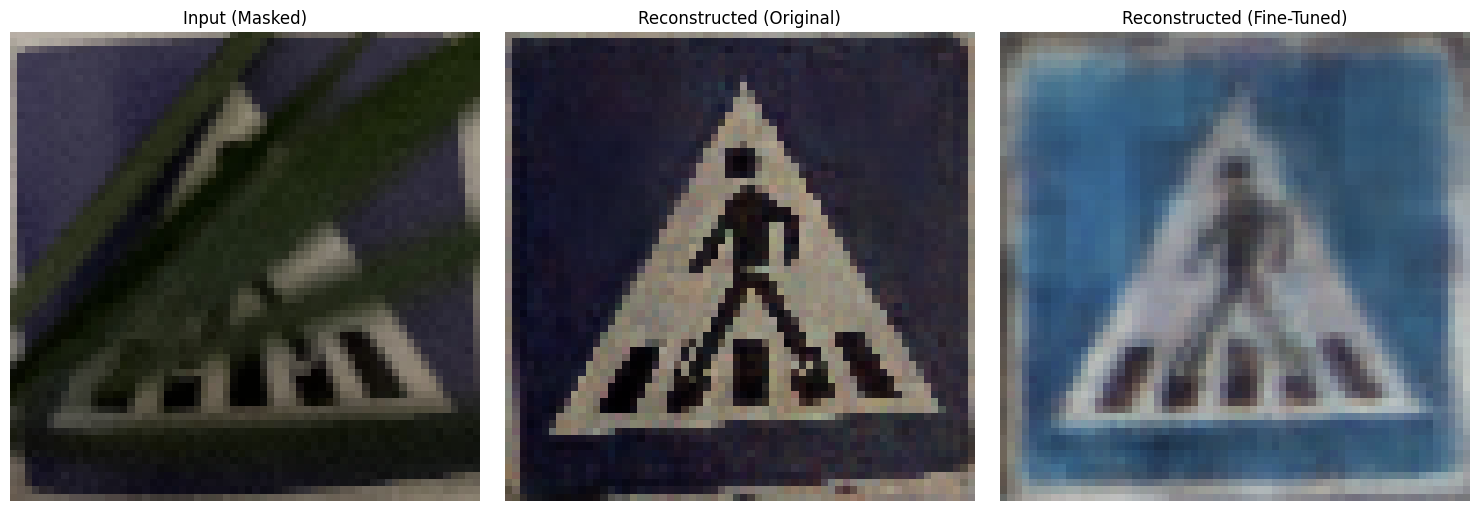

Verarbeite Bild: mask_11.png


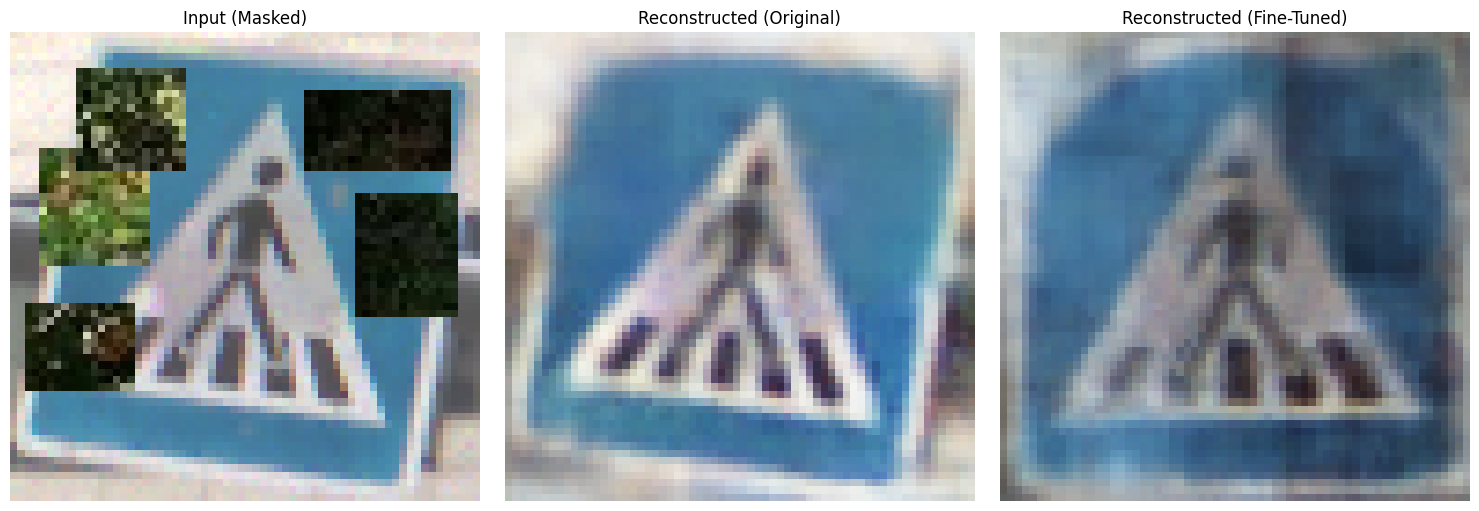

Verarbeite Bild: mask_16.png


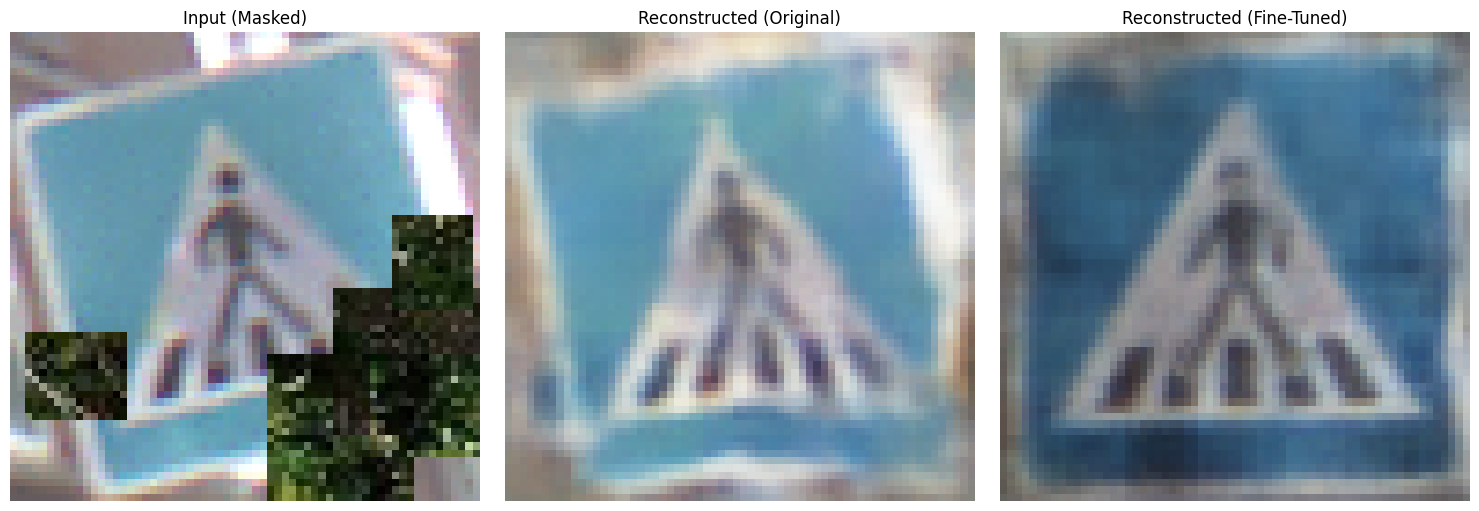

Verarbeite Bild: mask_4.png


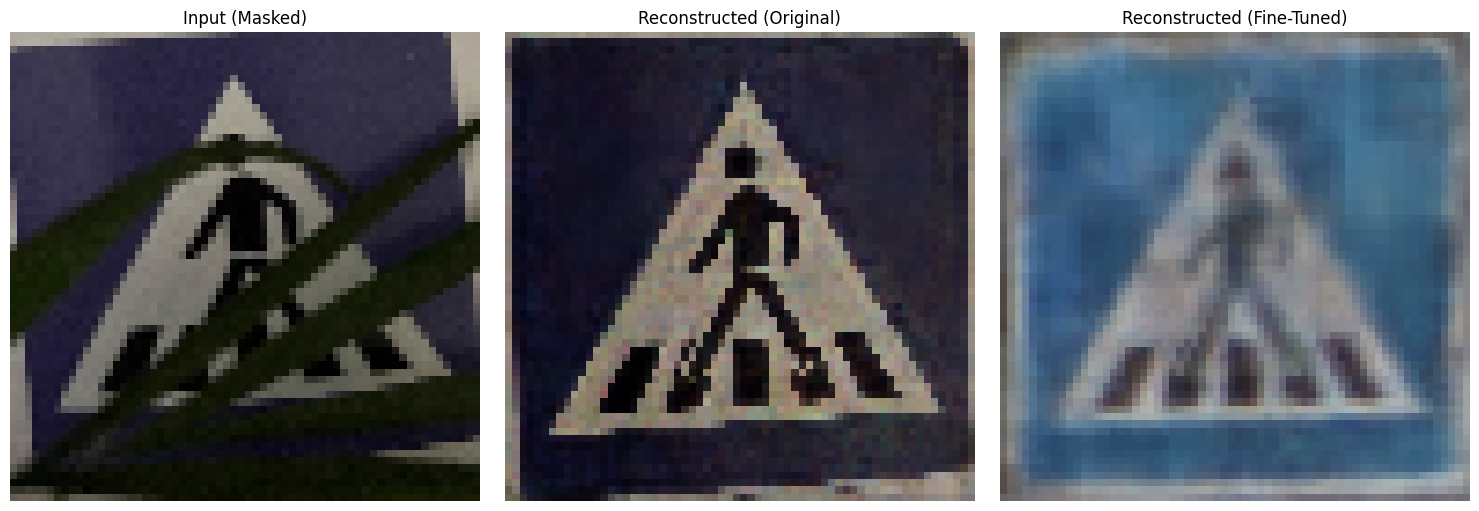

Verarbeite Bild: mask_1.png


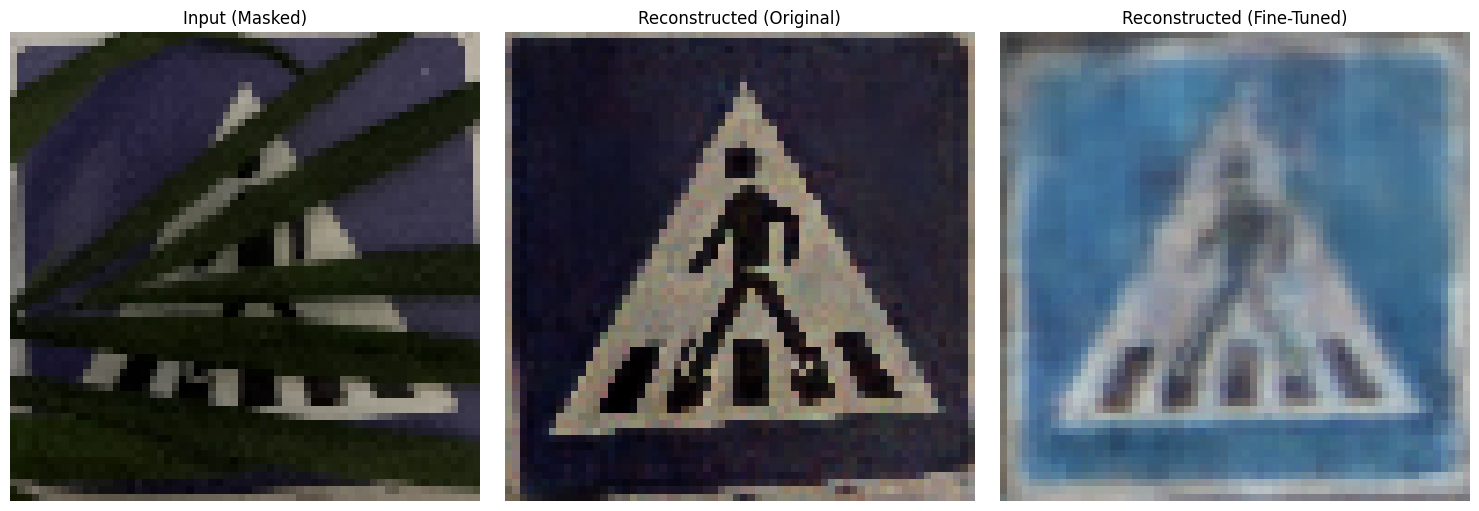

Verarbeite Bild: mask_17.png


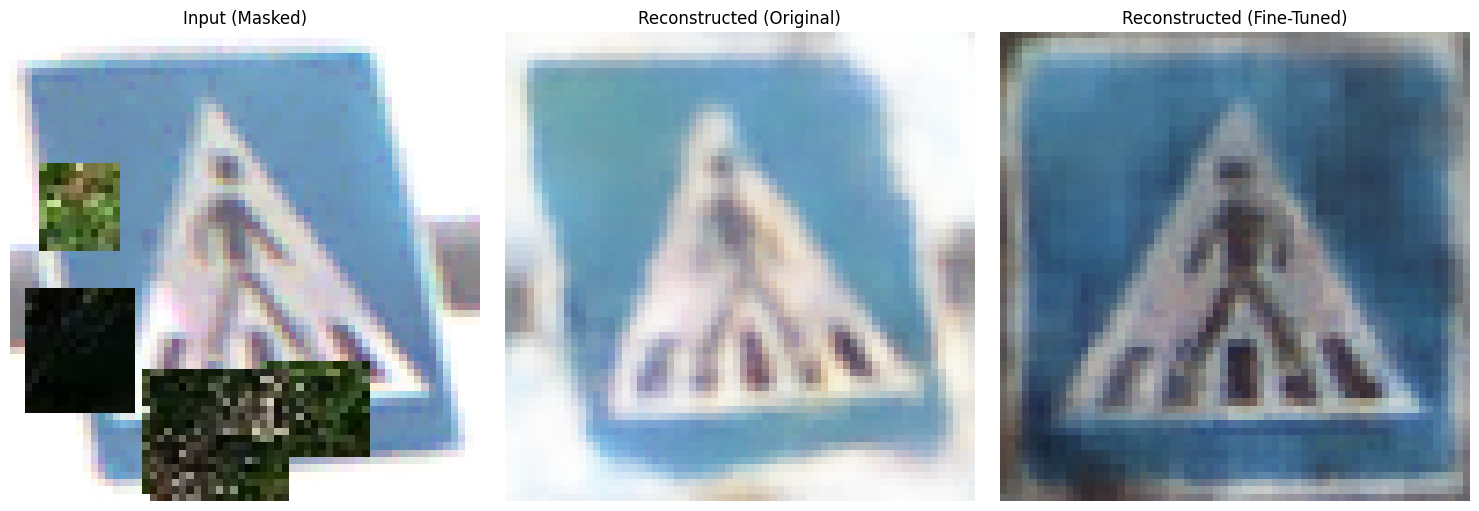

Verarbeite Bild: mask_6.png


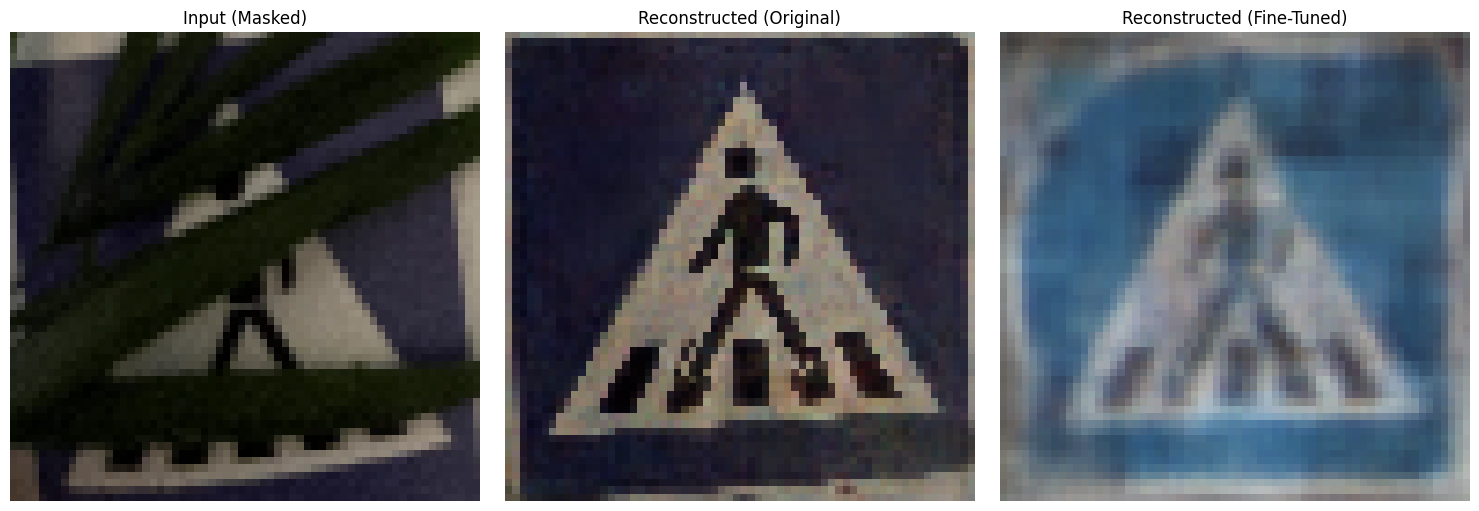

Verarbeite Bild: mask_13.png


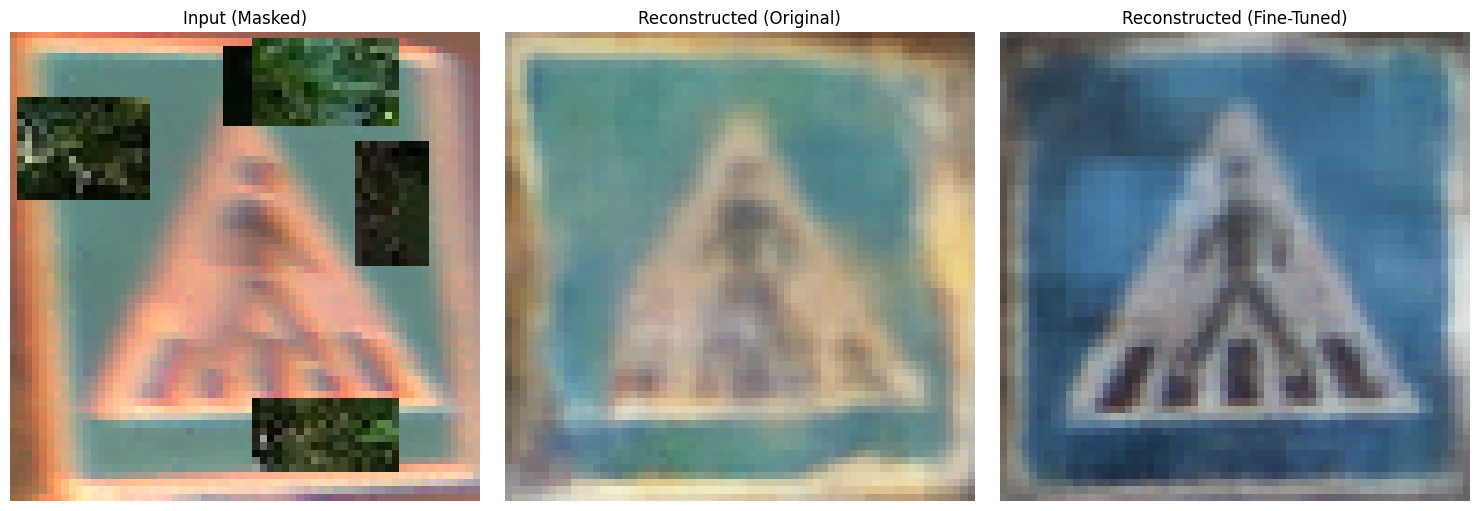

Verarbeite Bild: mask_7.png


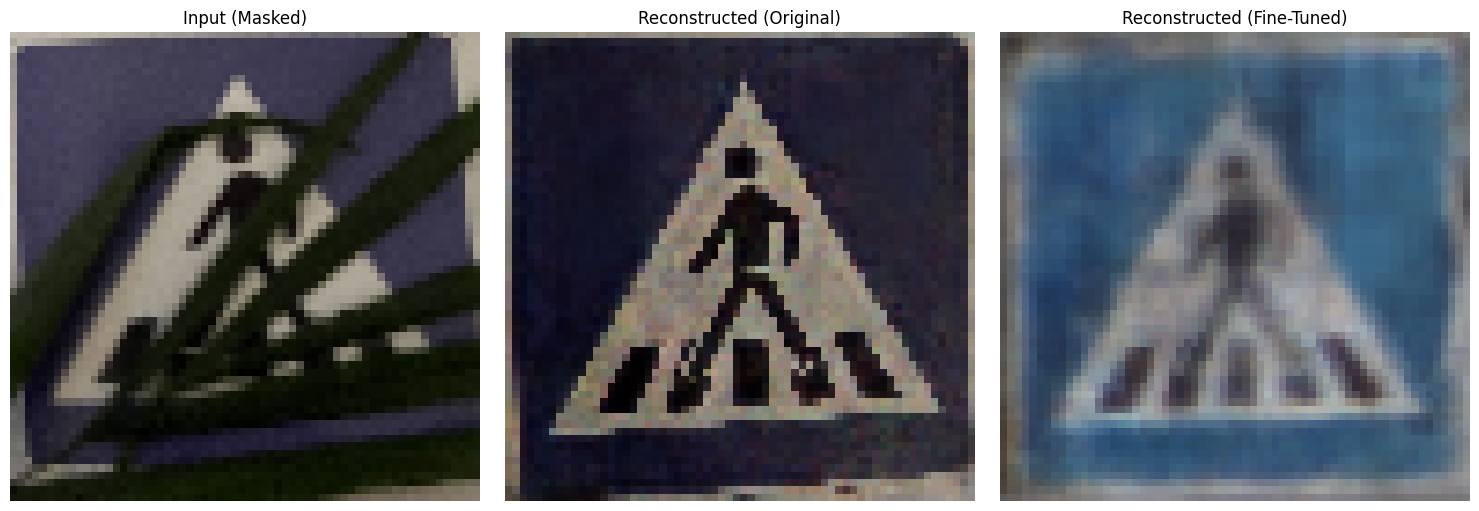

Verarbeite Bild: mask_2.png


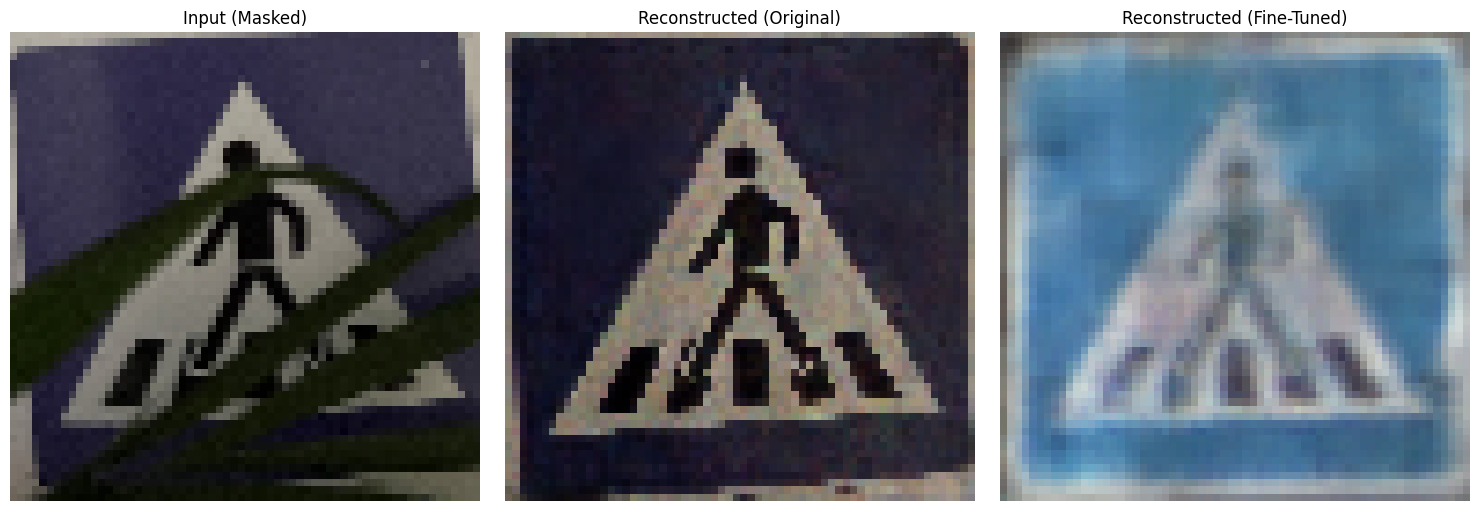

Verarbeite Bild: mask_9.png


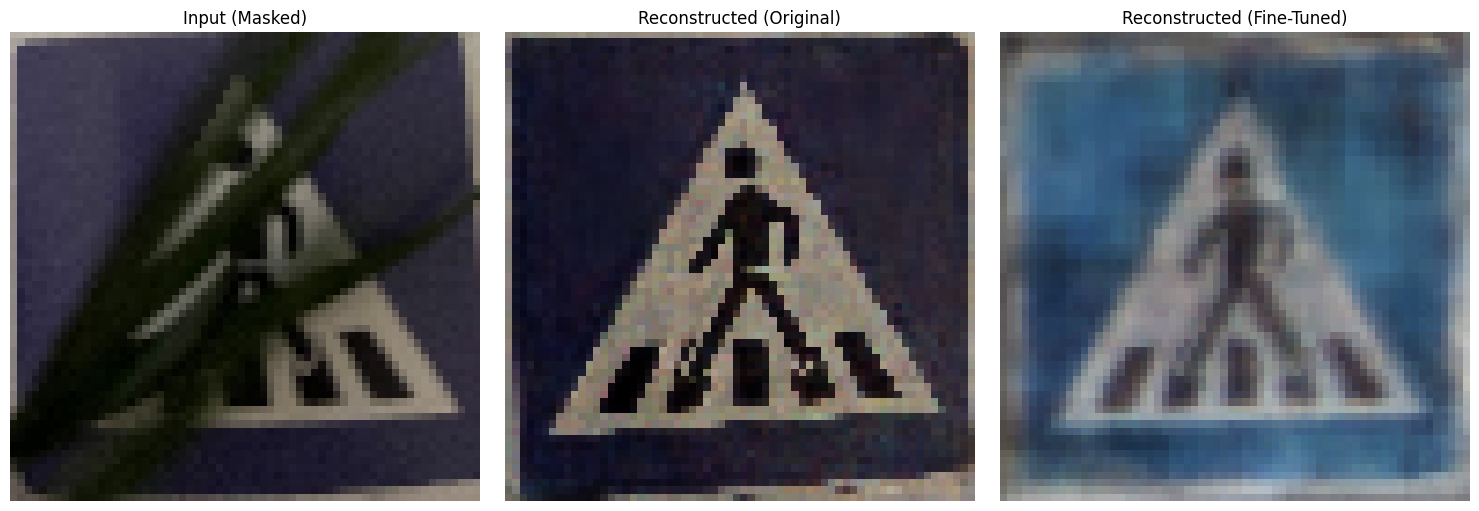

In [53]:
import os
import numpy as np
import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# ONNX-Modellpfade
original_model_path = "autoencoder.onnx"  # Pfad zum ursprünglichen Modell
fine_tuned_model_path = "fine_tuned_autoencoder.onnx"  # Pfad zum feinjustierten Modell

# Verzeichnis mit Eingabebildern
input_dir = "/content/extracted1/input"  # Verzeichnis mit Eingabebildern

# Bildvorverarbeitung
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalisierung auf [-1, 1]
])

# Rücknormalisierung für Visualisierung
def denormalize(image_tensor):
    return (image_tensor * 0.5 + 0.5).clip(0, 1)  # Rückumwandlung in den Bereich [0, 1]

# Modelle laden und Inferenz-Sessions erstellen
original_session = ort.InferenceSession(original_model_path)
fine_tuned_session = ort.InferenceSession(fine_tuned_model_path)
print("Beide ONNX-Modelle erfolgreich geladen.")

# Funktion, um ein Bild zu rekonstruieren und zu vergleichen
def compare_models(input_path):
    # Eingabebild laden und vorverarbeiten
    image = Image.open(input_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).numpy()  # Hinzufügen der Batch-Dimension

    # Inferenz für beide Modelle
    original_reconstructed = original_session.run(None, {"input": input_tensor})[0]
    fine_tuned_reconstructed = fine_tuned_session.run(None, {"input": input_tensor})[0]

    # Rücknormalisierung und Bildskalierung für die Visualisierung
    original_reconstructed_image = denormalize(original_reconstructed[0]).transpose(1, 2, 0)
    fine_tuned_reconstructed_image = denormalize(fine_tuned_reconstructed[0]).transpose(1, 2, 0)

    # Bilder anzeigen
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(np.array(image) / 255.0)  # Originaleingabe (maskiert)
    axes[0].set_title("Input (Masked)")
    axes[0].axis("off")

    axes[1].imshow(original_reconstructed_image)
    axes[1].set_title("Reconstructed (Original)")
    axes[1].axis("off")

    axes[2].imshow(fine_tuned_reconstructed_image)
    axes[2].set_title("Reconstructed (Fine-Tuned)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Alle Testbilder verarbeiten und vergleichen
for file_name in os.listdir(input_dir):
    if file_name.endswith(".png"):  # Nur PNG-Bilder verarbeiten
        input_path = os.path.join(input_dir, file_name)
        print(f"Verarbeite Bild: {file_name}")
        compare_models(input_path)


Beide ONNX-Modelle erfolgreich geladen.
Verarbeite Bild: mask_3.png


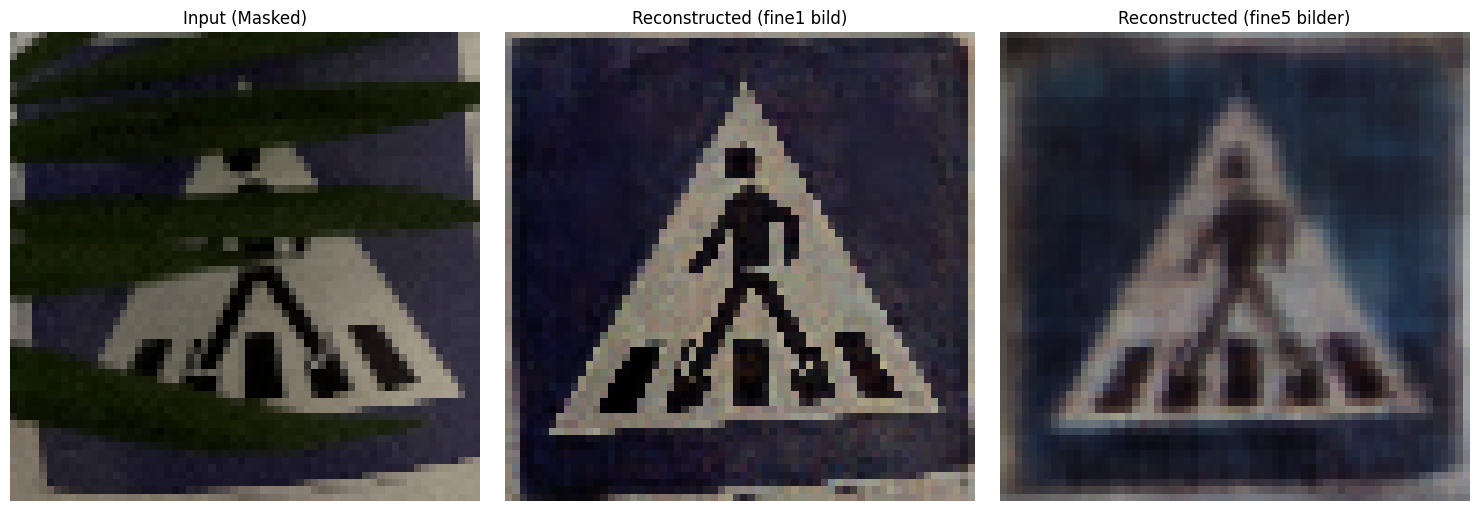

Verarbeite Bild: mask_10.png


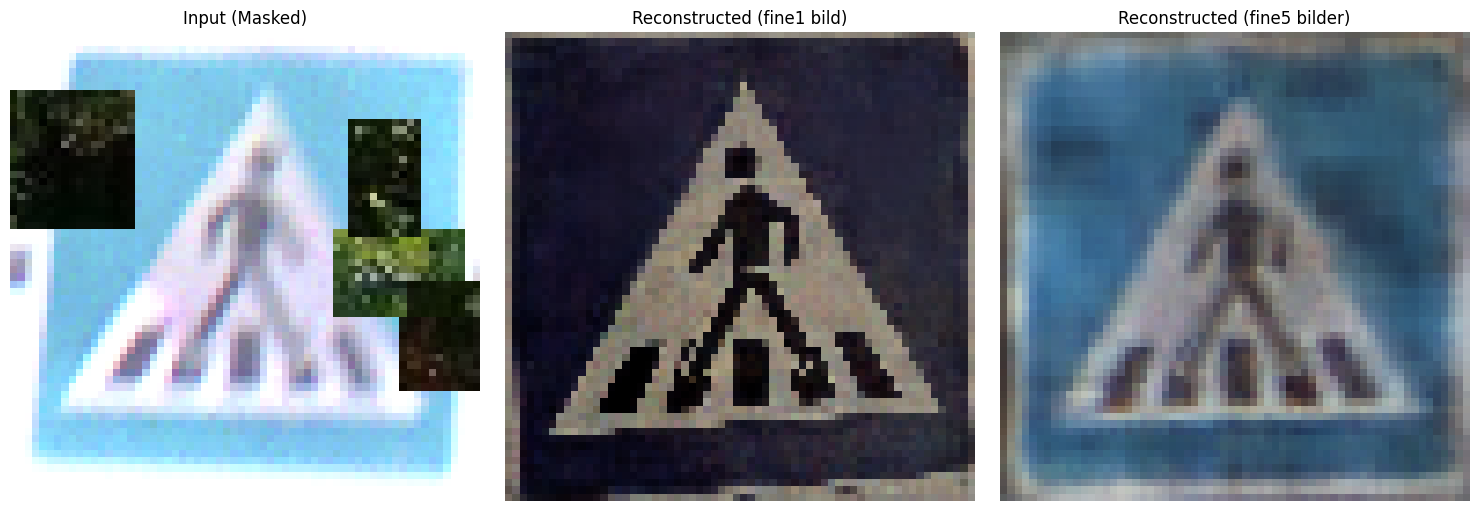

Verarbeite Bild: mask_12.png


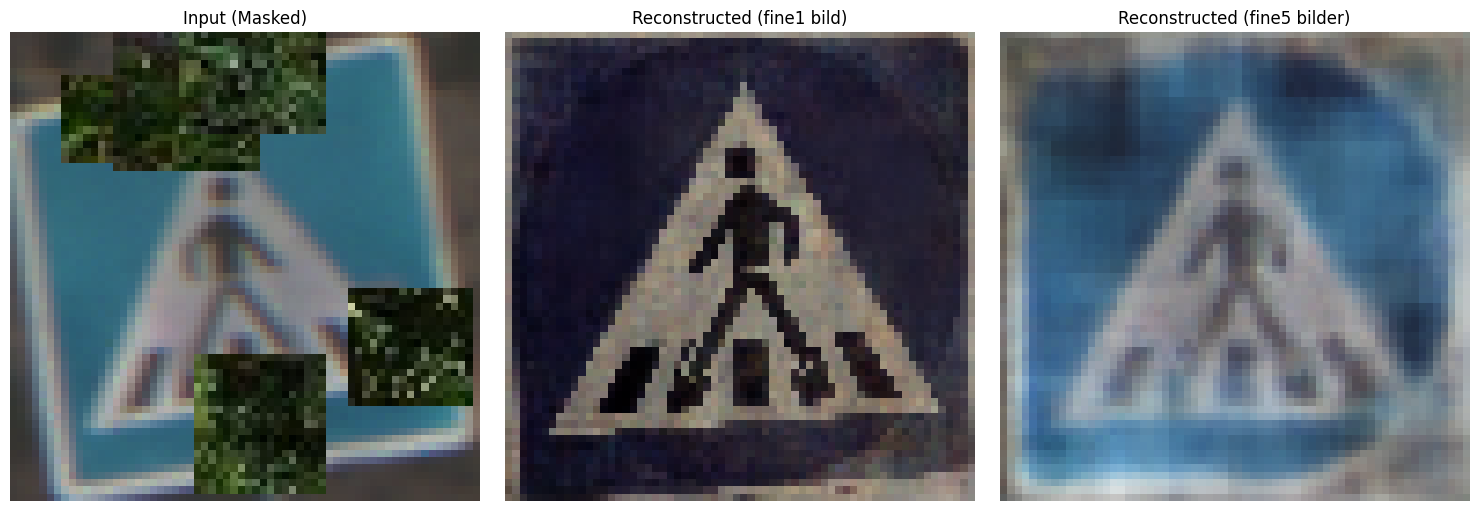

Verarbeite Bild: mask_5.png


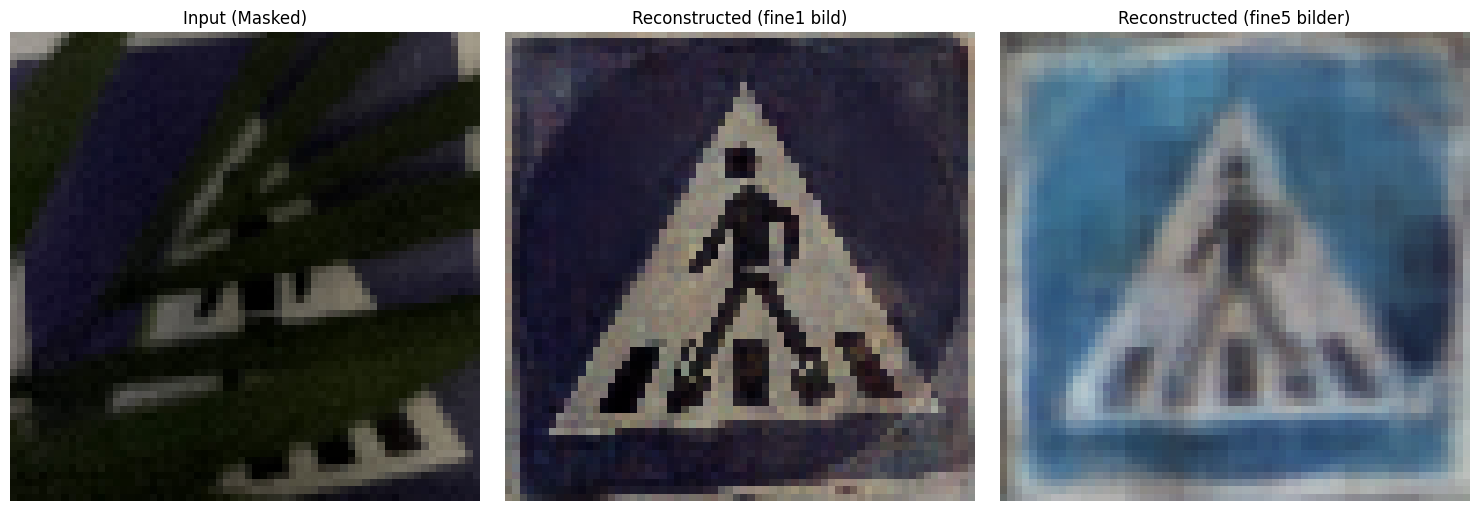

Verarbeite Bild: mask_14.png


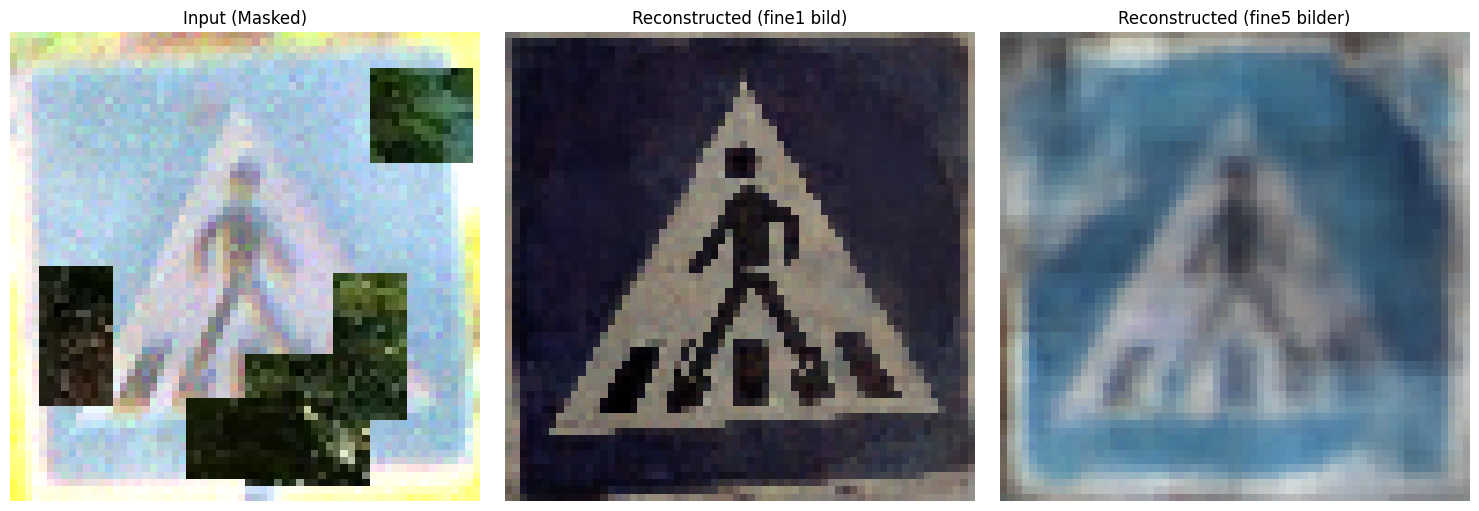

Verarbeite Bild: mask_19.png


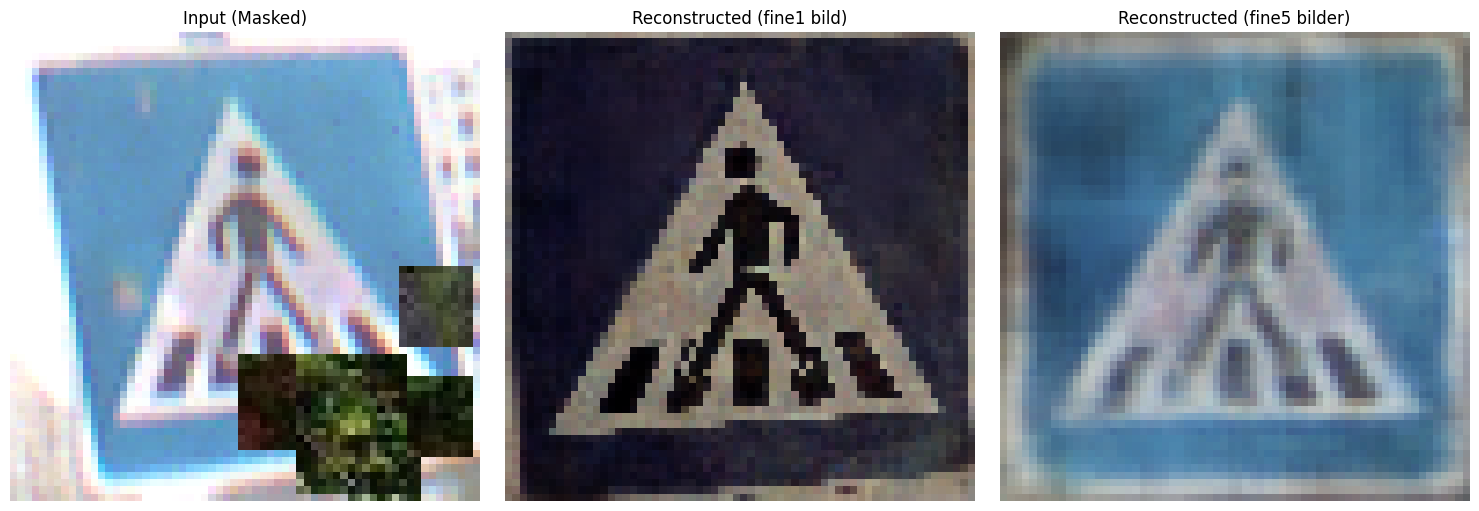

Verarbeite Bild: mask_18.png


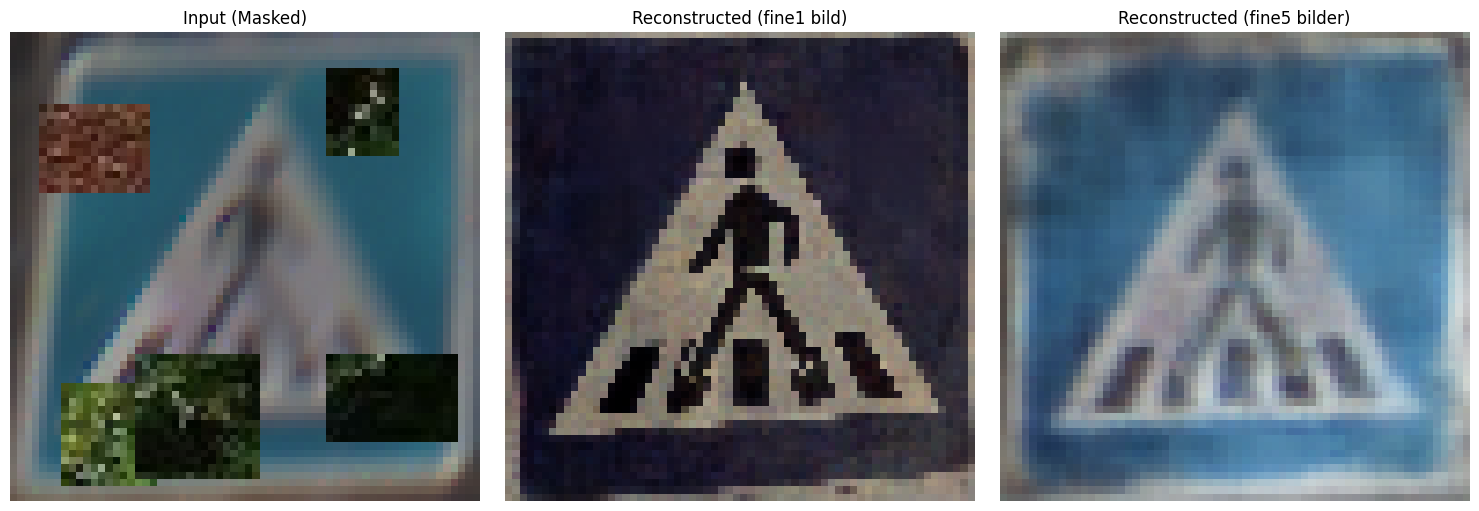

Verarbeite Bild: mask_15.png


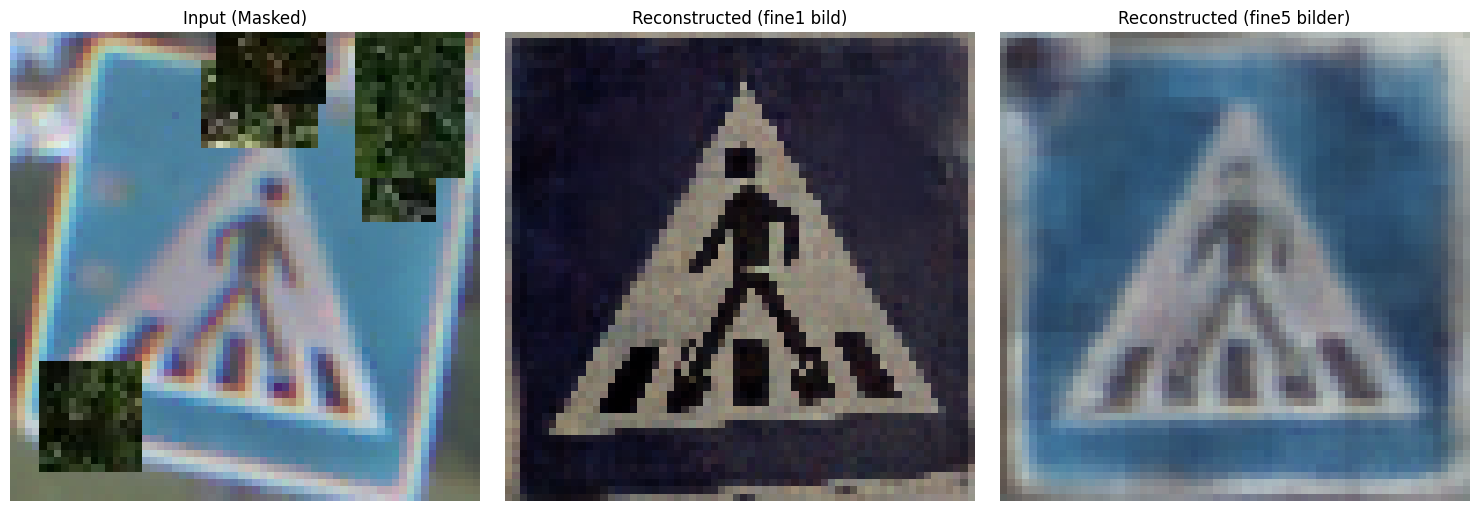

Verarbeite Bild: mask_8.png


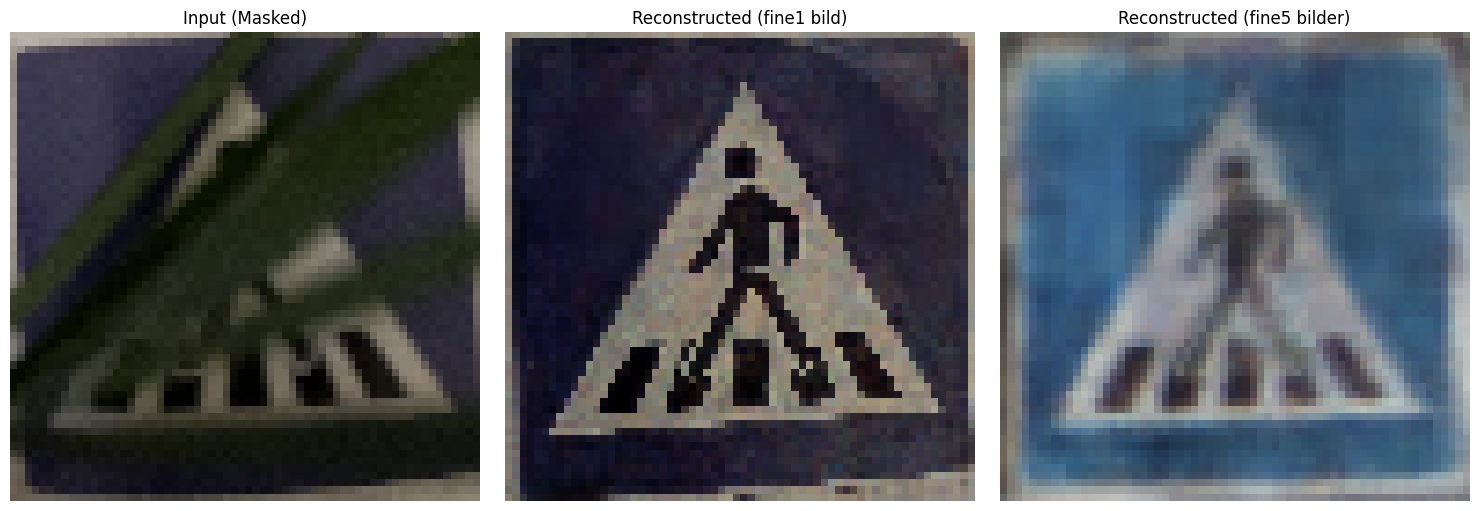

Verarbeite Bild: mask_11.png


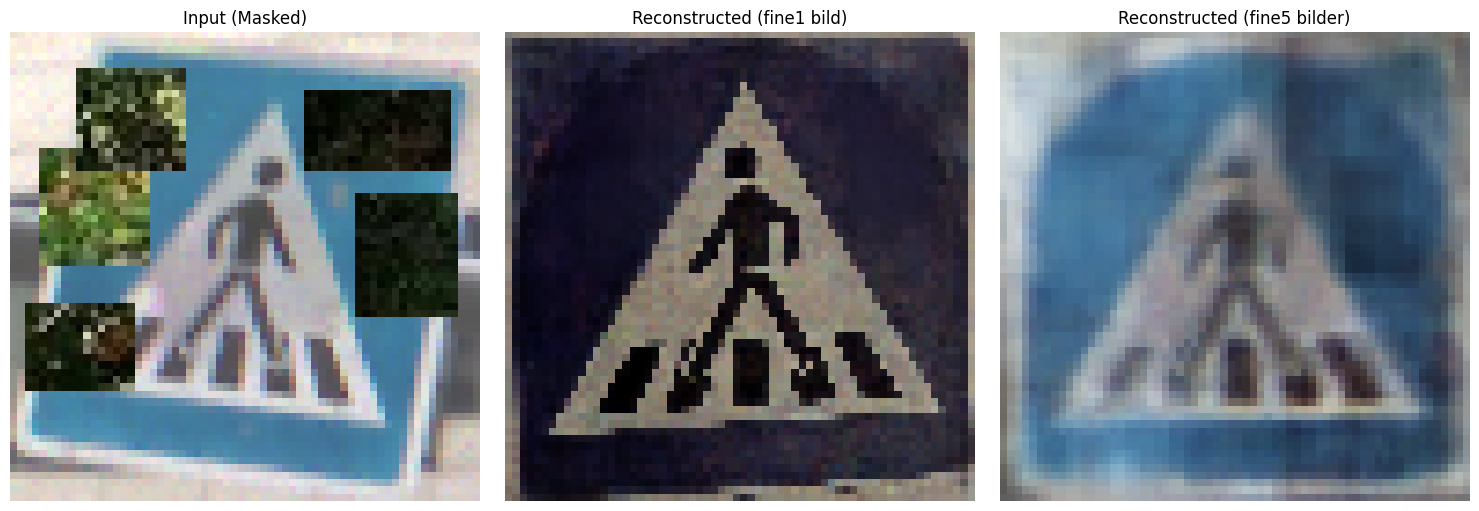

Verarbeite Bild: mask_16.png


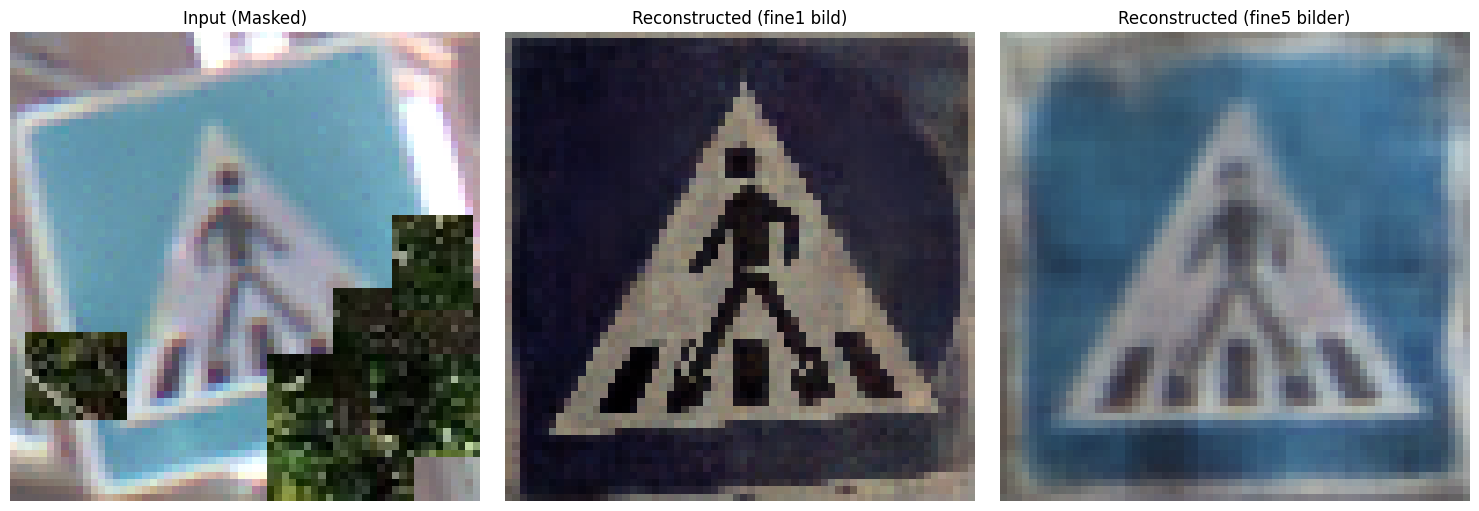

Verarbeite Bild: mask_4.png


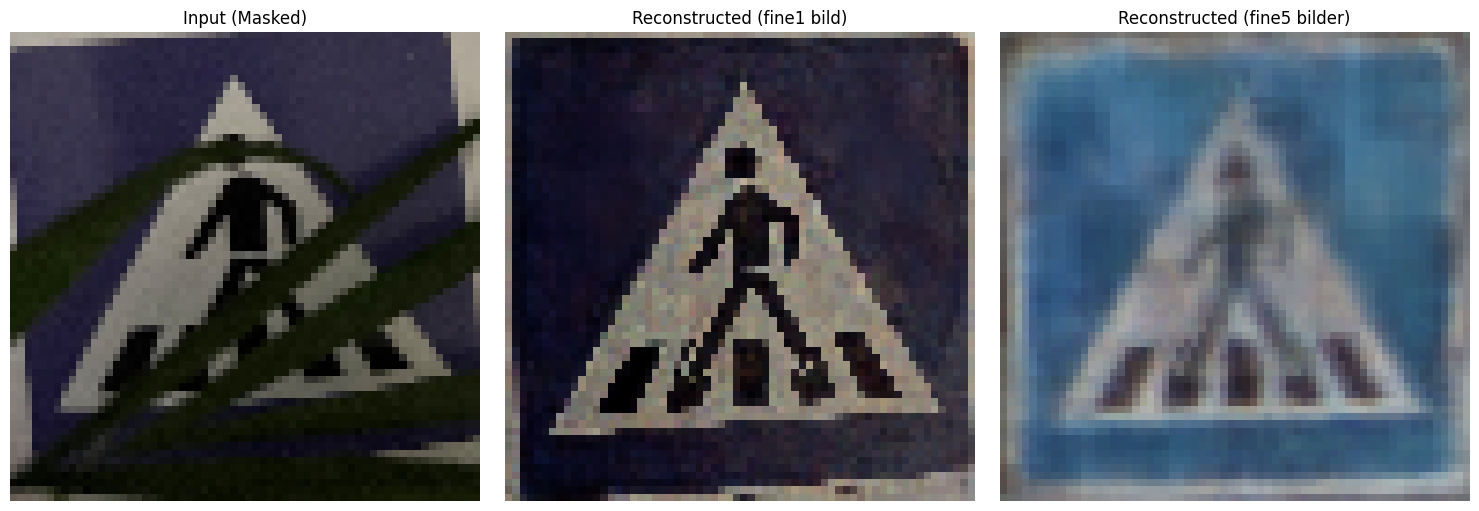

Verarbeite Bild: mask_1.png


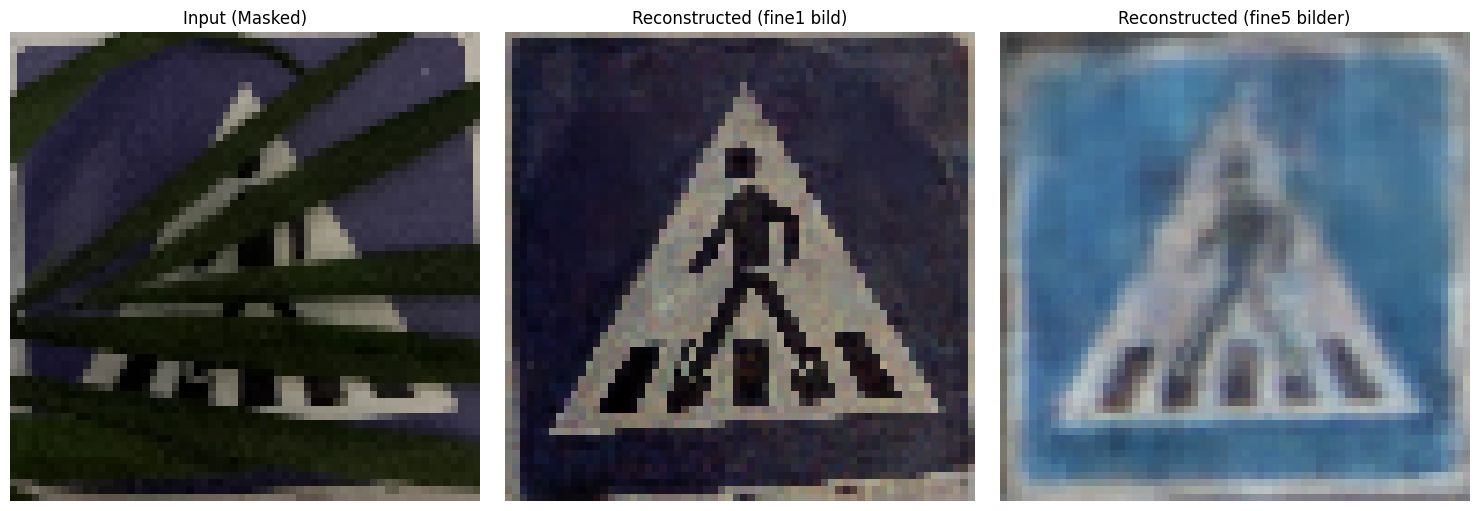

Verarbeite Bild: mask_17.png


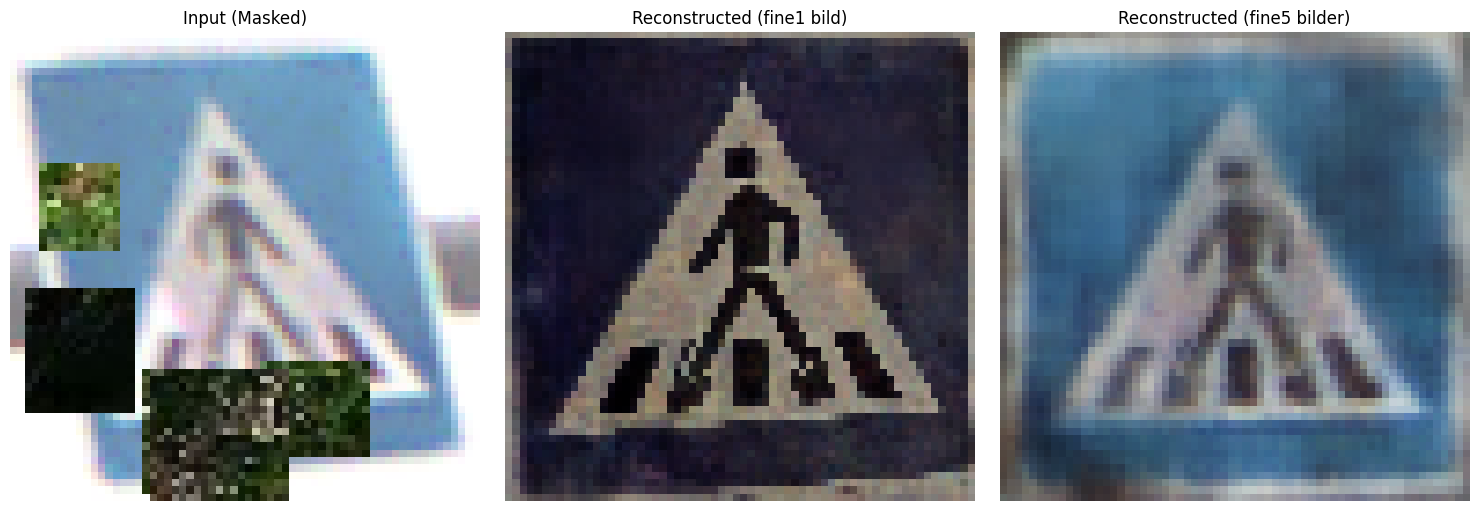

Verarbeite Bild: mask_6.png


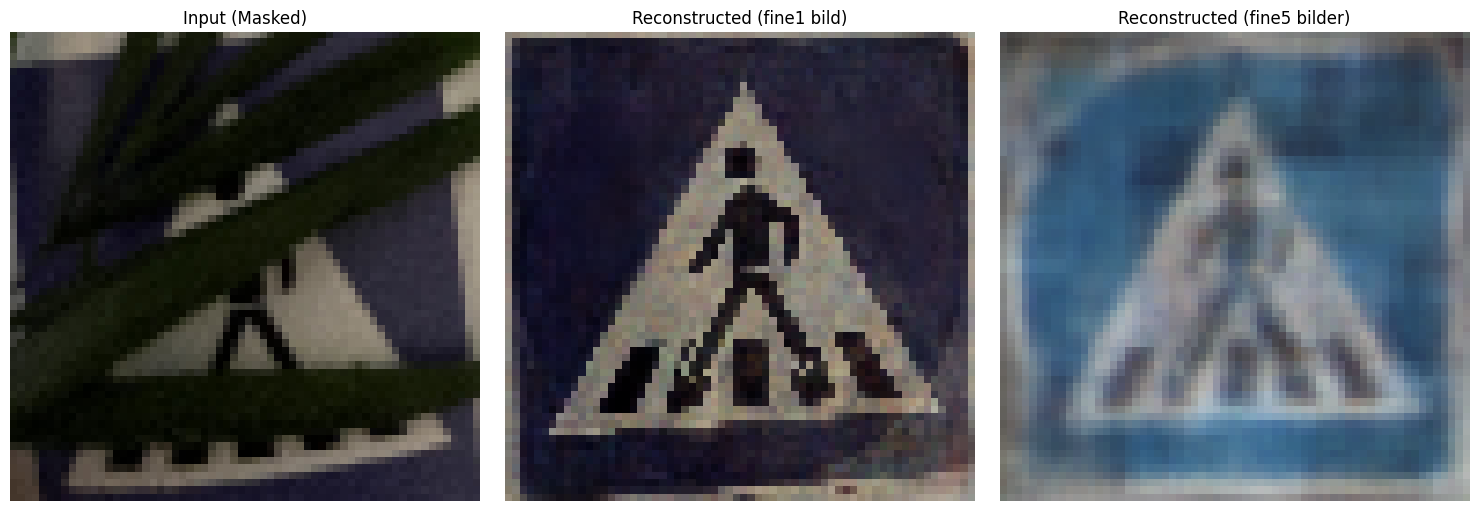

Verarbeite Bild: mask_13.png


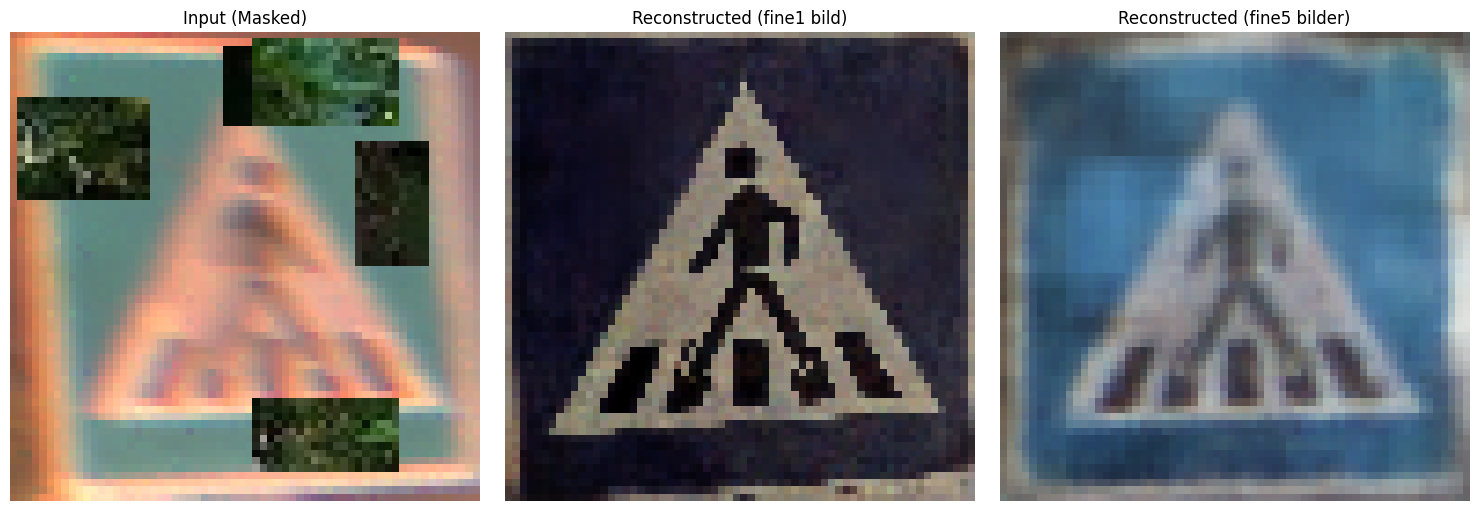

Verarbeite Bild: mask_7.png


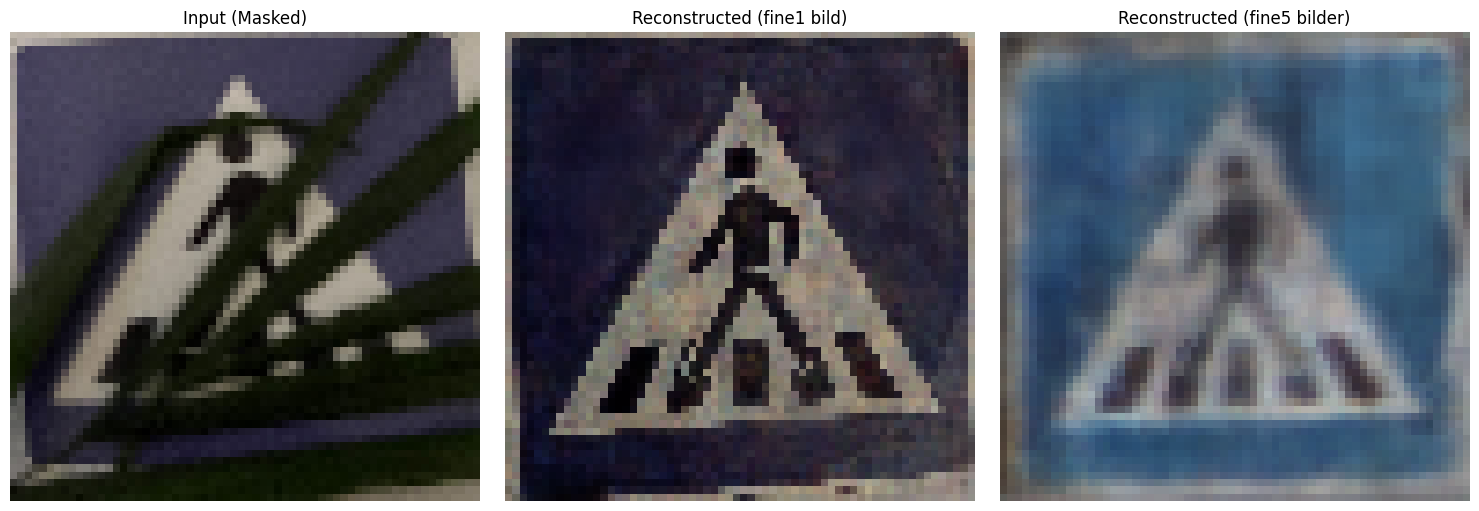

Verarbeite Bild: mask_2.png


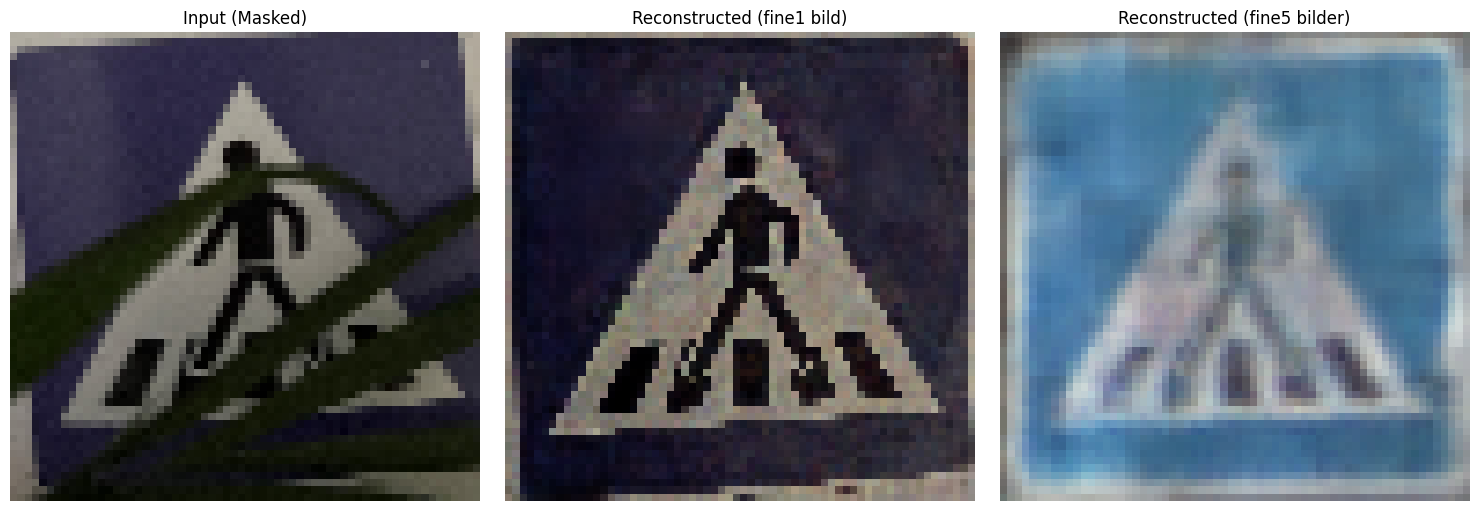

Verarbeite Bild: mask_9.png


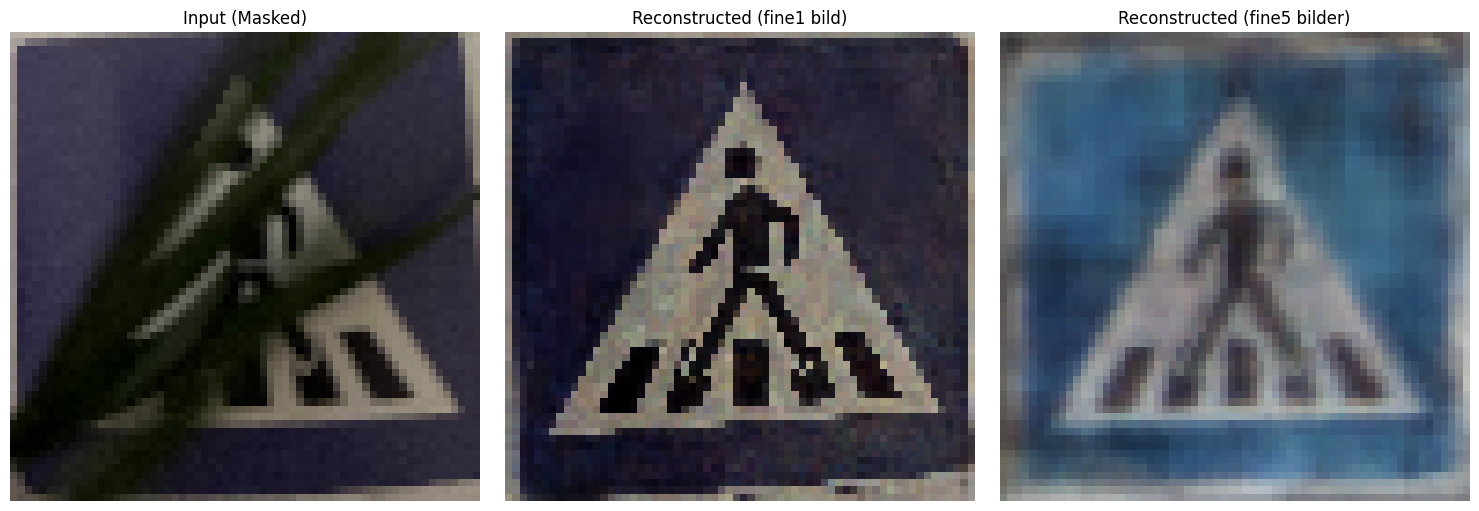

In [56]:
import os
import numpy as np
import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# ONNX-Modellpfade
original_model_path = "finetuned_autoencoder.onnx"  # Pfad zum ursprünglichen Modell
fine_tuned_model_path = "fine_tuned_autoencoder.onnx"  # Pfad zum feinjustierten Modell

# Verzeichnis mit Eingabebildern
input_dir = "/content/extracted1/input"  # Verzeichnis mit Eingabebildern

# Bildvorverarbeitung
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalisierung auf [-1, 1]
])

# Rücknormalisierung für Visualisierung
def denormalize(image_tensor):
    return (image_tensor * 0.5 + 0.5).clip(0, 1)  # Rückumwandlung in den Bereich [0, 1]

# Modelle laden und Inferenz-Sessions erstellen
original_session = ort.InferenceSession(original_model_path)
fine_tuned_session = ort.InferenceSession(fine_tuned_model_path)
print("Beide ONNX-Modelle erfolgreich geladen.")

# Funktion, um ein Bild zu rekonstruieren und zu vergleichen
def compare_models(input_path):
    # Eingabebild laden und vorverarbeiten
    image = Image.open(input_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).numpy()  # Hinzufügen der Batch-Dimension

    # Inferenz für beide Modelle
    original_reconstructed = original_session.run(None, {"input": input_tensor})[0]
    fine_tuned_reconstructed = fine_tuned_session.run(None, {"input": input_tensor})[0]

    # Rücknormalisierung und Bildskalierung für die Visualisierung
    original_reconstructed_image = denormalize(original_reconstructed[0]).transpose(1, 2, 0)
    fine_tuned_reconstructed_image = denormalize(fine_tuned_reconstructed[0]).transpose(1, 2, 0)

    # Bilder anzeigen
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(np.array(image) / 255.0)  # Originaleingabe (maskiert)
    axes[0].set_title("Input (Masked)")
    axes[0].axis("off")

    axes[1].imshow(original_reconstructed_image)
    axes[1].set_title("Reconstructed (fine1 bild)")
    axes[1].axis("off")

    axes[2].imshow(fine_tuned_reconstructed_image)
    axes[2].set_title("Reconstructed (fine5 bilder)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Alle Testbilder verarbeiten und vergleichen
for file_name in os.listdir(input_dir):
    if file_name.endswith(".png"):  # Nur PNG-Bilder verarbeiten
        input_path = os.path.join(input_dir, file_name)
        print(f"Verarbeite Bild: {file_name}")
        compare_models(input_path)


Beide ONNX-Modelle erfolgreich geladen.
Verarbeite Bild: cropped_5_pflanze.png


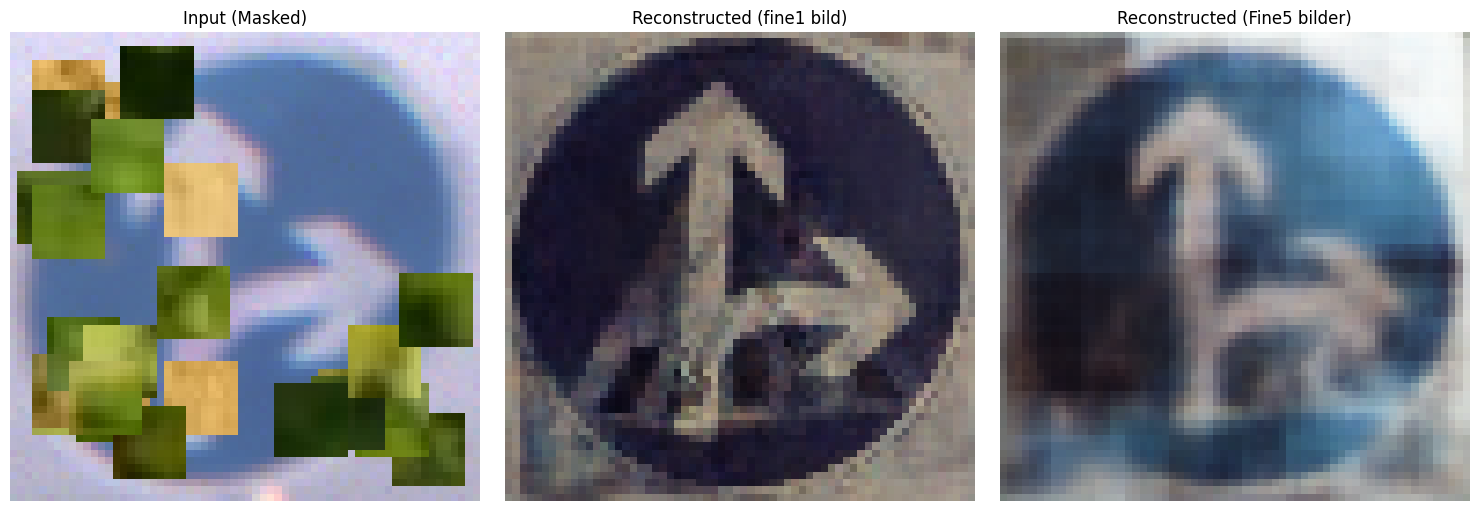

Verarbeite Bild: cropped_0_pflanze.png


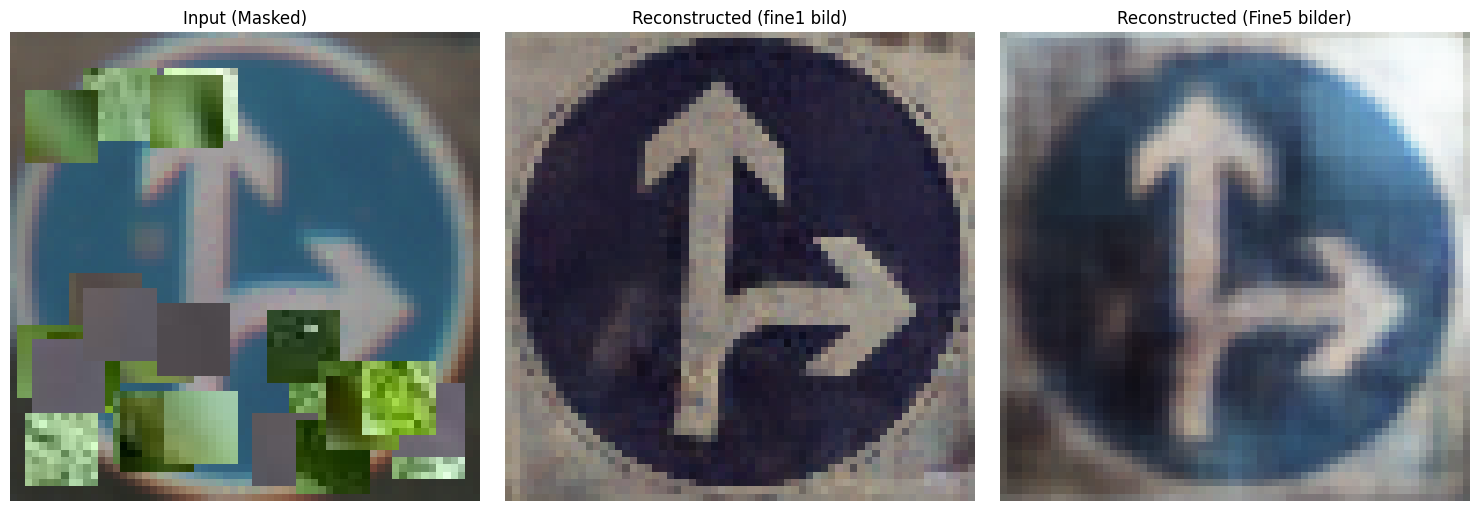

Verarbeite Bild: cropped_3_pflanze.png


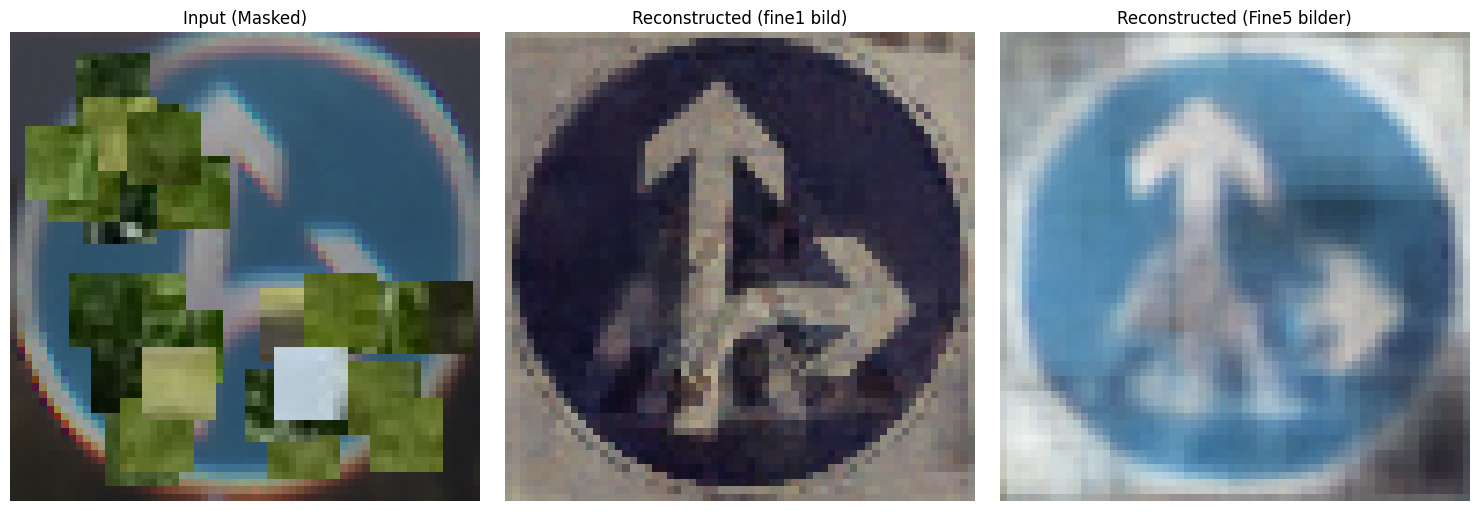

Verarbeite Bild: cropped_4_pflanze.png


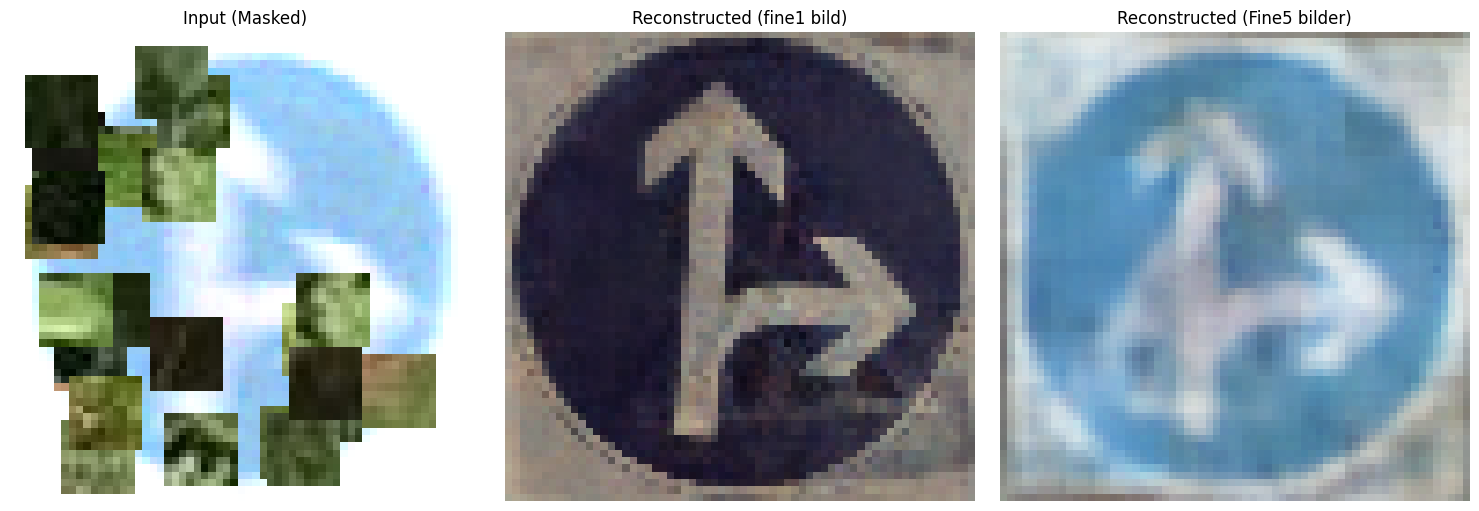

Verarbeite Bild: cropped_2_pflanze.png


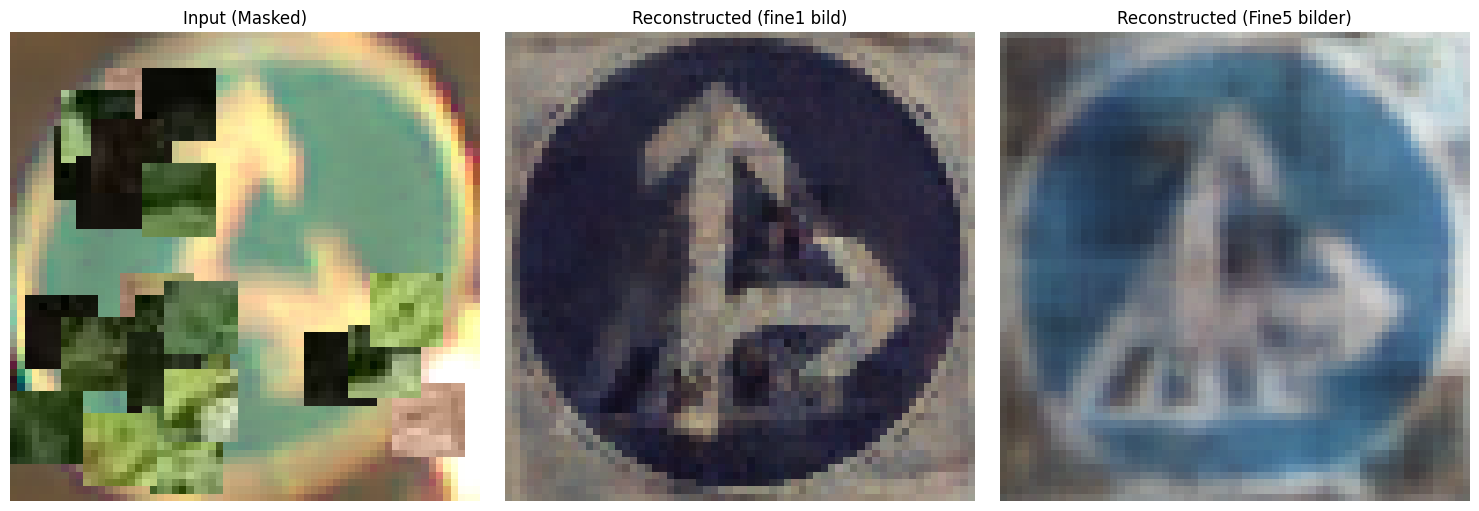

Verarbeite Bild: cropped_1_pflanze.png


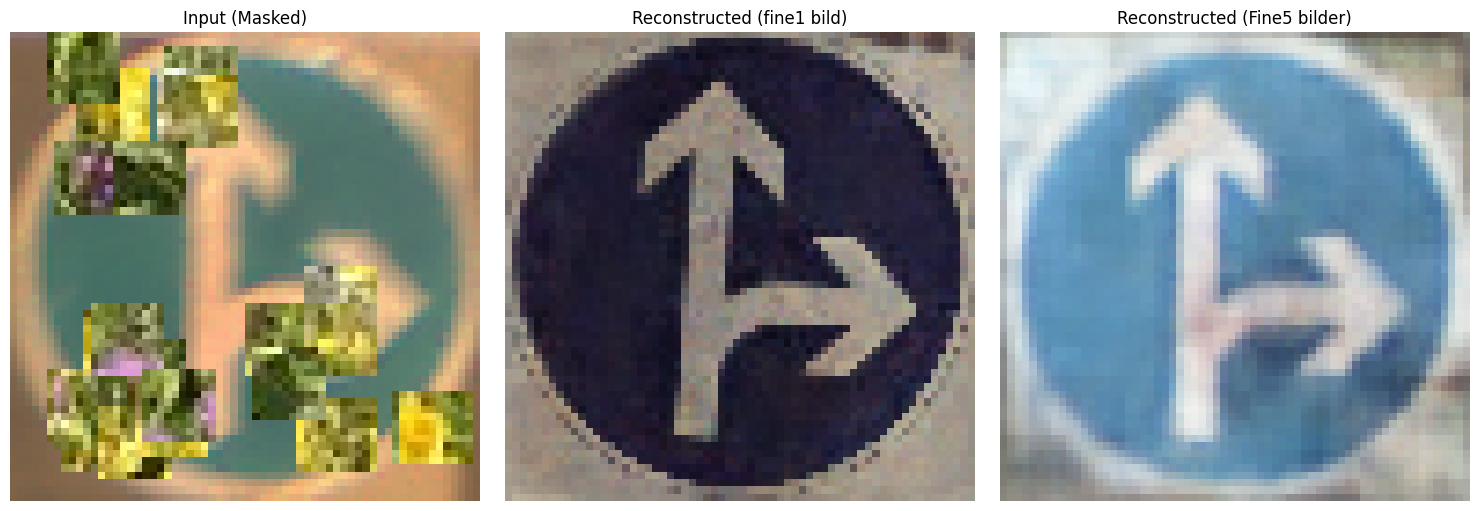

In [57]:
import os
import numpy as np
import onnxruntime as ort
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# ONNX-Modellpfade
original_model_path = "finetuned_autoencoder.onnx"  # Pfad zum ursprünglichen Modell
fine_tuned_model_path = "fine_tuned_autoencoder.onnx"  # Pfad zum feinjustierten Modell

# Verzeichnis mit Eingabebildern
input_dir = "/content/extracted/test/geradeaus_rechts/input_pflanzen"  # Verzeichnis mit Eingabebildern

# Bildvorverarbeitung
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalisierung auf [-1, 1]
])

# Rücknormalisierung für Visualisierung
def denormalize(image_tensor):
    return (image_tensor * 0.5 + 0.5).clip(0, 1)  # Rückumwandlung in den Bereich [0, 1]

# Modelle laden und Inferenz-Sessions erstellen
original_session = ort.InferenceSession(original_model_path)
fine_tuned_session = ort.InferenceSession(fine_tuned_model_path)
print("Beide ONNX-Modelle erfolgreich geladen.")

# Funktion, um ein Bild zu rekonstruieren und zu vergleichen
def compare_models(input_path):
    # Eingabebild laden und vorverarbeiten
    image = Image.open(input_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).numpy()  # Hinzufügen der Batch-Dimension

    # Inferenz für beide Modelle
    original_reconstructed = original_session.run(None, {"input": input_tensor})[0]
    fine_tuned_reconstructed = fine_tuned_session.run(None, {"input": input_tensor})[0]

    # Rücknormalisierung und Bildskalierung für die Visualisierung
    original_reconstructed_image = denormalize(original_reconstructed[0]).transpose(1, 2, 0)
    fine_tuned_reconstructed_image = denormalize(fine_tuned_reconstructed[0]).transpose(1, 2, 0)

    # Bilder anzeigen
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(np.array(image) / 255.0)  # Originaleingabe (maskiert)
    axes[0].set_title("Input (Masked)")
    axes[0].axis("off")

    axes[1].imshow(original_reconstructed_image)
    axes[1].set_title("Reconstructed (fine1 bild)")
    axes[1].axis("off")

    axes[2].imshow(fine_tuned_reconstructed_image)
    axes[2].set_title("Reconstructed (Fine5 bilder)")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

# Alle Testbilder verarbeiten und vergleichen
for file_name in os.listdir(input_dir):
    if file_name.endswith(".png"):  # Nur PNG-Bilder verarbeiten
        input_path = os.path.join(input_dir, file_name)
        print(f"Verarbeite Bild: {file_name}")
        compare_models(input_path)
